

# missRanger包
--Fast Imputation of Missing Values by Chained Random Forests

本教程借助missRanger包介绍随机森林在填补缺失值方面的功能

## Description

Uses the "ranger" package (Wright & Ziegler) to do fast missing value imputation by chained random forests, see Stekhoven & Buehlmann and Van Buuren & Groothuis-Oudshoorn. Between the iterative model fitting, it offers the option of predictive mean matching. This firstly avoids imputation with values not present in the original data (like a value 0.3334 in a 0-1 coded variable). Secondly, predictive mean matching tries to raise the variance in the resulting conditional distributions to a realistic level. This allows to do multiple imputation when repeating the call to `missRanger()`.

## Usage

```r
missRanger(
  data,
  formula = . ~ .,
  pmm.k = 0L,
  maxiter = 10L,
  seed = NULL,
  verbose = 1,
  returnOOB = FALSE,
  case.weights = NULL,
  data_only = TRUE,
  keep_forests = FALSE,
  ...
)
```

## Arguments

|                |                                                              |
| -------------- | ------------------------------------------------------------ |
| `data`         | A `data.frame` with missing values to impute.                |
| `formula`      | A two-sided formula specifying variables to be imputed (left hand side) and variables used to impute (right hand side). Defaults to `. ~ .`, i.e., use all variables to impute all variables. For instance, if all variables (with missings) should be imputed by all variables except variable "ID", use `. ~ . - ID`. Note that a "." is evaluated separately for each side of the formula. Further note that variables with missings must appear in the left hand side if they should be used on the right hand side. |
| `pmm.k`        | Number of candidate non-missing values to sample from in the predictive mean matching steps. 0 to avoid this step. |
| `maxiter`      | Maximum number of chaining iterations.                       |
| `seed`         | Integer seed to initialize the random generator.             |
| `verbose`      | Controls how much info is printed to screen. 0 to print nothing. 1 (default) to print a progress bar per iteration, 2 to print the OOB prediction error per iteration and variable (1 minus R-squared for regression). Furthermore, if `verbose` is positive, the variables used for imputation are listed as well as the variables to be imputed (in the imputation order). This will be useful to detect if some variables are unexpectedly skipped. |
| `returnOOB`    | Logical flag. If TRUE, the final average out-of-bag prediction errors per variable is added to the resulting data as attribute "oob". Only relevant when `data_only = TRUE` (and when forests are grown). |
| `case.weights` | Vector with non-negative case weights.                       |
| `data_only`    | If `TRUE` (default), only the imputed data is returned. Otherwise, a "missRanger" object with additional information is returned. |
| `keep_forests` | Should the random forests of the final imputations be returned? The default is `FALSE`. Setting this option will use a lot of memory. Only relevant when `data_only = TRUE` (and when forests are grown). |
| `...`          | Arguments passed to `ranger::ranger()`. If the data set is large, better use less trees (e.g. `num.trees = 20`) and/or a low value of `sample.fraction`. The following arguments are incompatible, amongst others: `write.forest`, `probability`, `split.select.weights`, `dependent.variable.name`, and `classification`. |

## Details

The iterative chaining stops as soon as `maxiter` is reached or if the average out-of-bag (OOB) prediction errors stop reducing. In the latter case, except for the first iteration, the second last (= best) imputed data is returned.

OOB prediction errors are quantified as 1 - R^2 for numeric variables, and as classification error otherwise. If a variable has been imputed only univariately, the value is 1.

A note on `mtry`: Be careful when passing a non-default `mtry` to `ranger::ranger()` because the number of available covariates might be growing during the first iteration, depending on the missing pattern. Values `NULL` (default) and 1 are safe choices. Additionally, recent versions of `ranger::ranger()` allow `mtry` to be a single-argument function of the number of available covariables, e.g., `mtry = function(m) max(1, m %/% 3)`.

## Value

If `data_only` an imputed `data.frame`. Otherwise, a "missRanger" object with the following elements that can be extracted via `$`:

- `data`: The imputed data.
- `forests`: When `keep_forests = TRUE`, a list of "ranger" models used to generate the imputed data. `NULL` otherwise.
- `visit_seq`: Variables to be imputed (in this order).
- `impute_by`: Variables used for imputation.
- `best_iter`: Best iteration.
- `pred_errors`: Per-iteration OOB prediction errors (1 - R^2 for regression, classification error otherwise).
- `mean_pred_errors`: Per-iteration averages of OOB prediction errors.

## References

1. Wright, M. N. & Ziegler, A. (2016). ranger: A Fast Implementation of Random Forests for High Dimensional Data in C++ and R. Journal of Statistical Software, in press. <arxiv.org/abs/1508.04409>.
2. Stekhoven, D.J. and Buehlmann, P. (2012). 'MissForest - nonparametric missing value imputation for mixed-type data', Bioinformatics, 28(1) 2012, 112-118. https://doi.org/10.1093/bioinformatics/btr597.
3. Van Buuren, S., Groothuis-Oudshoorn, K. (2011). mice: Multivariate Imputation by Chained Equations in R. Journal of Statistical Software, 45(3), 1-67. http://www.jstatsoft.org/v45/i03/

## 训练集缺失

In [4]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 22, repr.plot.height = 10) # 满幅

p_load(rpart, missForest, VIM, missRanger, treemisc, AppliedPredictiveModeling, skimr)
s <- skim_tee

In [4]:
data(abalone)
ab <- abalone
ab$Rings <- factor((ab$Rings) > 9, labels = c("L", "H")) # 处理成二类，逻辑型factor的levels的排序默认是：FALSE,TRUE，分别对应于"L","H"
s(ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             4177  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   2     
  numeric                  7     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts               
1 Type                  0             1 FALSE          3 M: 1528, I: 1342, F: 1307
2 Rings                 0             1 FALSE          2 L: 2096, H: 2081         

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50   p75  p100 h

### 单特征

--训练集的某个自变量一定程度缺失，测试集完整，比较随机森林算法训练集填补前后rpart决策树的测试集错判率。

#### 无缺失

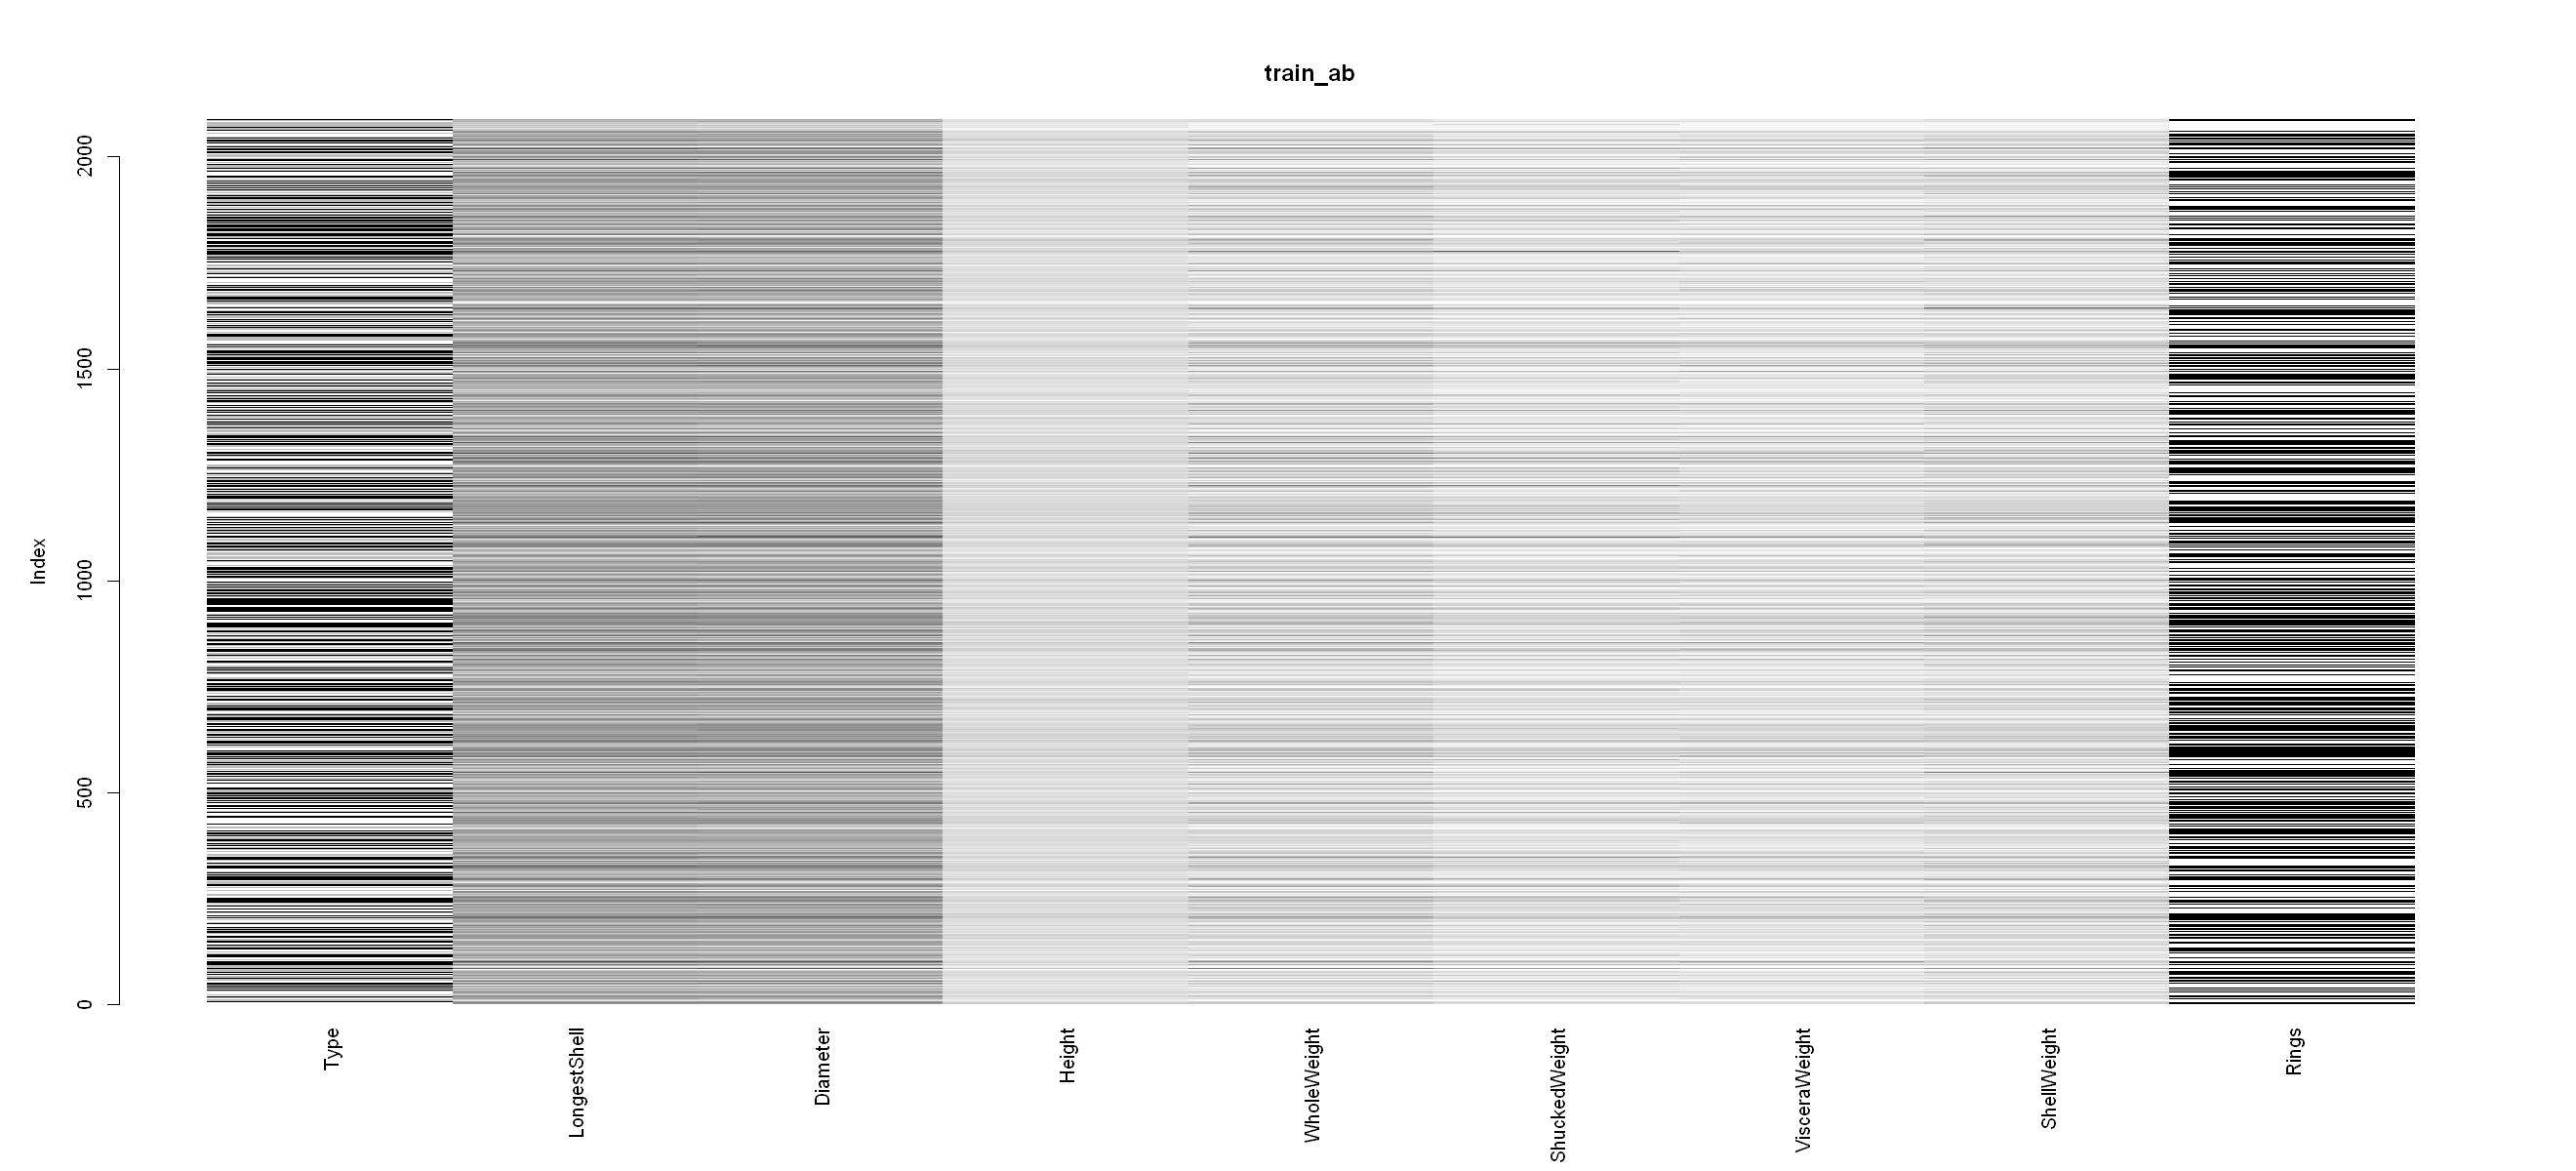

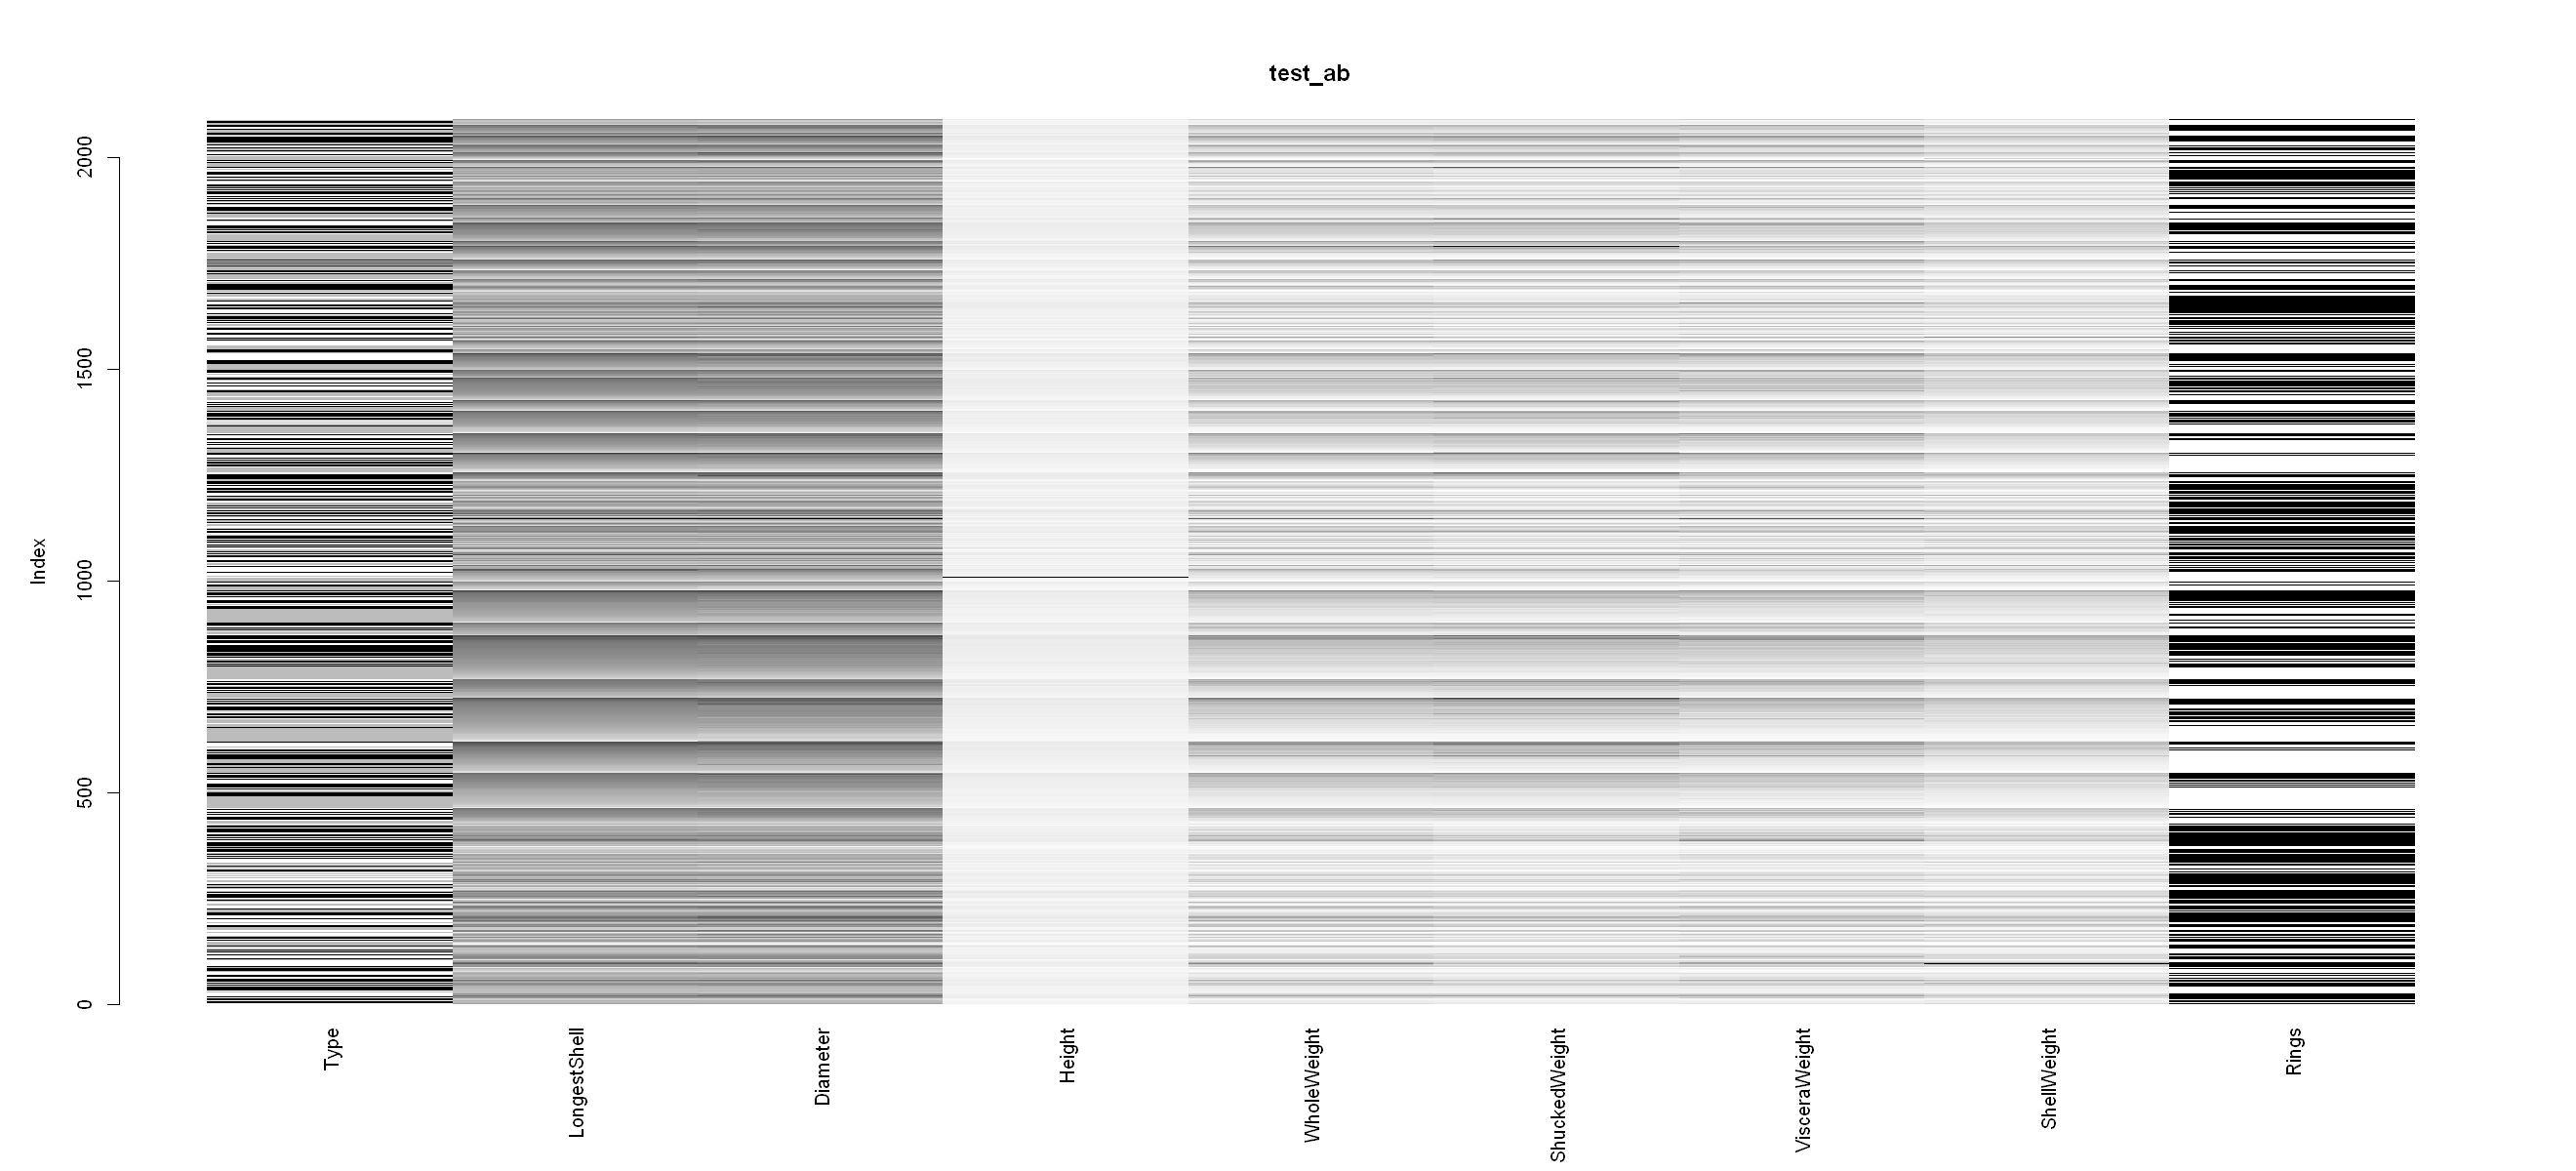

In [4]:
# 将数据集1:1随机分割成训练集和测试集
set.seed(100)
I <- sample(nrow(ab), nrow(ab) * 0.5)

train_ab <- ab[I, ]
test_ab <- ab[-I, ]
par(oma = c(2,1,1,1))
matrixplot(train_ab, main = "train_ab")   
matrixplot(test_ab, main = "test_ab")   

In [10]:
summary(aggr(train_ab, plot = FALSE))

set.seed(2)    #固定xstd：xerror具有随机性--数据随机分割的原因
ct_ab <- rpart(Rings ~ ., data = train_ab, method = "class", cp = 0)  
cto_ab <- prune_se(ct_ab, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率


 Missings per variable: 
      Variable Count
          Type     0
  LongestShell     0
      Diameter     0
        Height     0
   WholeWeight     0
 ShuckedWeight     0
 VisceraWeight     0
   ShellWeight     0
         Rings     0

 Missings in combinations of variables: 
      Combinations Count Percent
 0:0:0:0:0:0:0:0:0  2088     100

[1] 0.2192437

#### 缺失10%

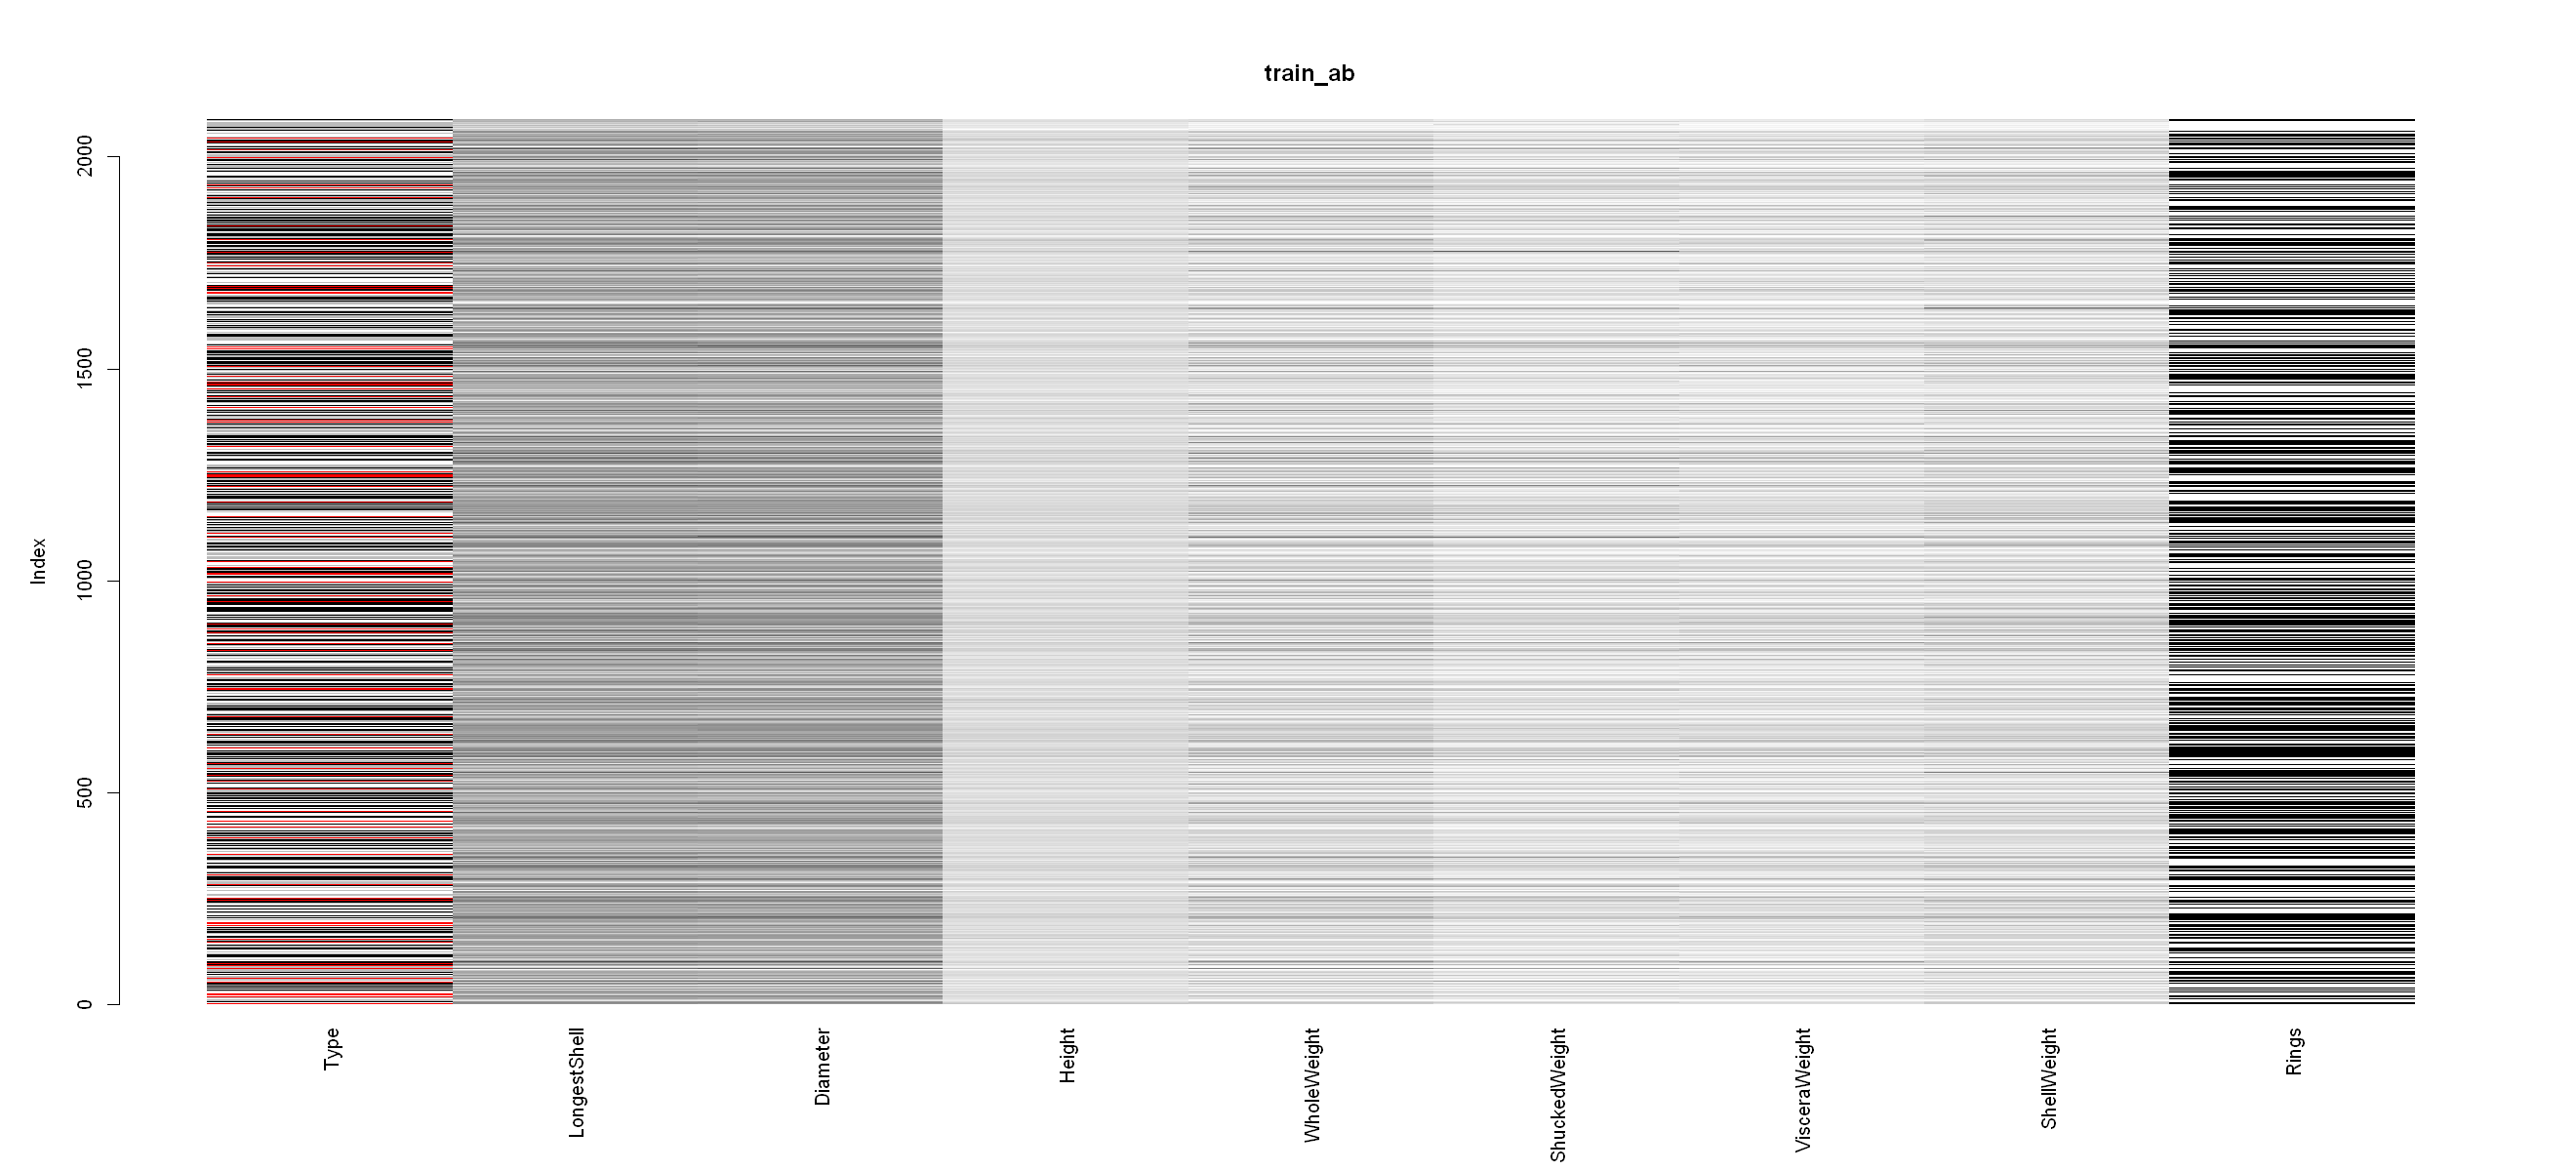

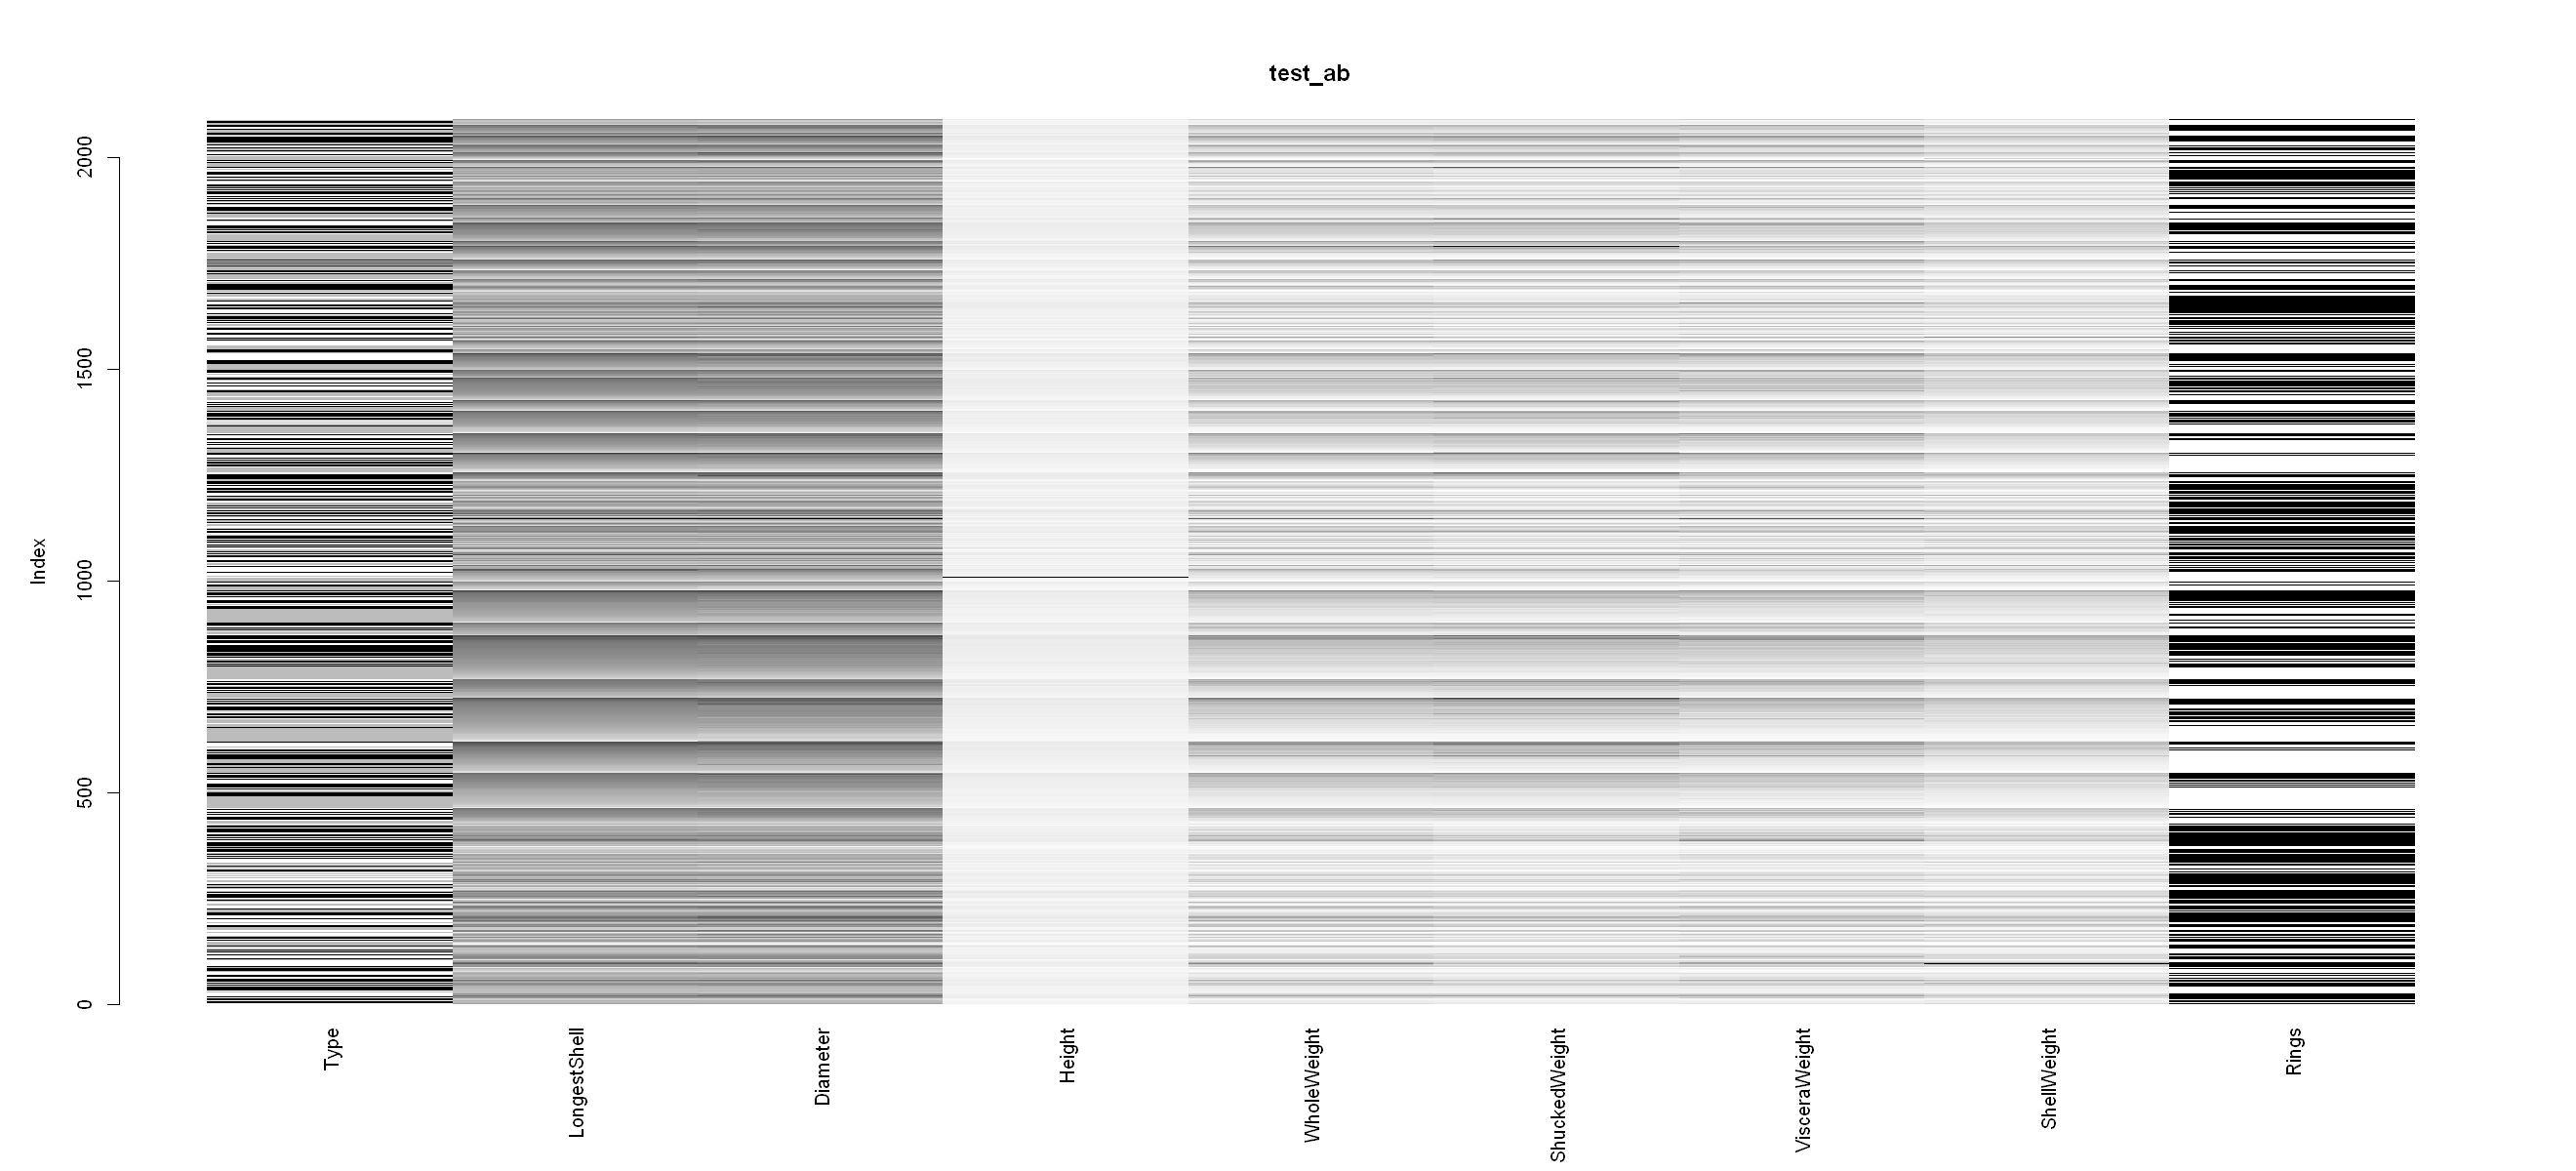

In [6]:
# 将数据集1:1随机分割成训练集和测试集
set.seed(100)
I <- sample(nrow(ab), nrow(ab) * 0.5)
n <- length(I)
k <- sample(I,n * 0.1)
ab_mis <- ab
ab_mis[k,1] <- NA
ab_mis[-I,9] <- NA

train_ab_mis <- ab_mis[I, ]
test_ab <- ab[-I, ]
par(oma = c(2,1,1,1))
matrixplot(train_ab_mis, main = "train_ab")   
matrixplot(test_ab, main = "test_ab")   

不填补缺失值的情形：

In [7]:
set.seed(2)    #固定xstd：xerror具有随机性--数据随机分割的原因
ct_ab_mis <- rpart(Rings ~ ., data = train_ab_mis, method = "class", cp = 0)  
cto_ab_mis <- prune_se(ct_ab_mis, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2202011

填补后的情形：

In [11]:
train_ab_mis_r <- missRanger(train_ab_mis, seed = 10, verbose = 0)   ##填补训练集缺失值

set.seed(2) 
ct_ab_mis_r <- rpart(Rings ~ ., data = train_ab_mis_r, method = "class", cp = 0)  
cto_ab_mis_r <- prune_se(ct_ab_mis_r, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis_r, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2096697

--上值竟然比无缺失值时的更低--纯属偶然

#### 缺失20%

In [10]:
set.seed(81)
train_ab_mis <- train_ab
n <- nrow(train_ab_mis)
set.seed(100)
k <- sample(n,n * 0.2)
train_ab_mis[k,1] <- NA
summary(aggr(train_ab_mis, plot = FALSE))


 Missings per variable: 
      Variable Count
          Type   417
  LongestShell     0
      Diameter     0
        Height     0
   WholeWeight     0
 ShuckedWeight     0
 VisceraWeight     0
   ShellWeight     0
         Rings     0

 Missings in combinations of variables: 
      Combinations Count  Percent
 0:0:0:0:0:0:0:0:0  1671 80.02874
 1:0:0:0:0:0:0:0:0   417 19.97126

不填补缺失值的情形：

In [11]:
set.seed(2)    #固定xstd：xerror具有随机性--数据随机分割的原因
ct_ab_mis <- rpart(Rings ~ ., data = train_ab_mis, method = "class", cp = 0)  
cto_ab_mis <- prune_se(ct_ab_mis, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2202011

填补后的情形：

In [12]:
set.seed(2) 

train_ab_mis_r <- missRanger(train_ab_mis, seed = 10, verbose = 0)   ##填补训练集缺失值

ct_ab_mis_r <- rpart(Rings ~ ., data = train_ab_mis_r, method = "class", cp = 0)  
cto_ab_mis_r <- prune_se(ct_ab_mis_r, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis_r, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2125419

#### 缺失30%

In [22]:
set.seed(81)
train_ab_mis <- train_ab
n <- nrow(train_ab_mis)
set.seed(100)
k <- sample(n,n * 0.3)
train_ab_mis[k,1] <- NA
summary(aggr(train_ab_mis, plot = FALSE))


 Missings per variable: 
      Variable Count
          Type   626
  LongestShell     0
      Diameter     0
        Height     0
   WholeWeight     0
 ShuckedWeight     0
 VisceraWeight     0
   ShellWeight     0
         Rings     0

 Missings in combinations of variables: 
      Combinations Count  Percent
 0:0:0:0:0:0:0:0:0  1462 70.01916
 1:0:0:0:0:0:0:0:0   626 29.98084

不填补缺失值的情形：

In [23]:
set.seed(2)    #固定xstd：xerror具有随机性--数据随机分割的原因
ct_ab_mis <- rpart(Rings ~ ., data = train_ab_mis, method = "class", cp = 0)  
cto_ab_mis <- prune_se(ct_ab_mis, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2202011

填补后的情形：

In [24]:
set.seed(2) 

train_ab_mis_r <- missRanger(train_ab_mis, seed = 10, verbose = 0)   ##填补训练集缺失值

ct_ab_mis_r <- rpart(Rings ~ ., data = train_ab_mis_r, method = "class", cp = 0)  
cto_ab_mis_r <- prune_se(ct_ab_mis_r, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis_r, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2096697

#### 缺失40%

In [25]:
set.seed(81)
train_ab_mis <- train_ab
n <- nrow(train_ab_mis)
set.seed(100)
k <- sample(n,n * 0.4)
train_ab_mis[k,1] <- NA
summary(aggr(train_ab_mis, plot = FALSE))


 Missings per variable: 
      Variable Count
          Type   835
  LongestShell     0
      Diameter     0
        Height     0
   WholeWeight     0
 ShuckedWeight     0
 VisceraWeight     0
   ShellWeight     0
         Rings     0

 Missings in combinations of variables: 
      Combinations Count  Percent
 0:0:0:0:0:0:0:0:0  1253 60.00958
 1:0:0:0:0:0:0:0:0   835 39.99042

不填补缺失值的情形：

In [26]:
set.seed(2)    #固定xstd：xerror具有随机性--数据随机分割的原因
ct_ab_mis <- rpart(Rings ~ ., data = train_ab_mis, method = "class", cp = 0)  
cto_ab_mis <- prune_se(ct_ab_mis, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2202011

填补后的情形：

In [27]:
set.seed(2) 

train_ab_mis_r <- missRanger(train_ab_mis, seed = 10, verbose = 0)   ##填补训练集缺失值

ct_ab_mis_r <- rpart(Rings ~ ., data = train_ab_mis_r, method = "class", cp = 0)  
cto_ab_mis_r <- prune_se(ct_ab_mis_r, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis_r, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2134993

可见，若测试集完整，填补后得到的决策树的测试集错判率优于未填补的。

### 所有自、因变量

--训练集的所有自、因变量一定程度缺失，测试集完整，比较随机森林算法训练集填补前后rpart决策树的测试集错判率。

#### 缺失10%

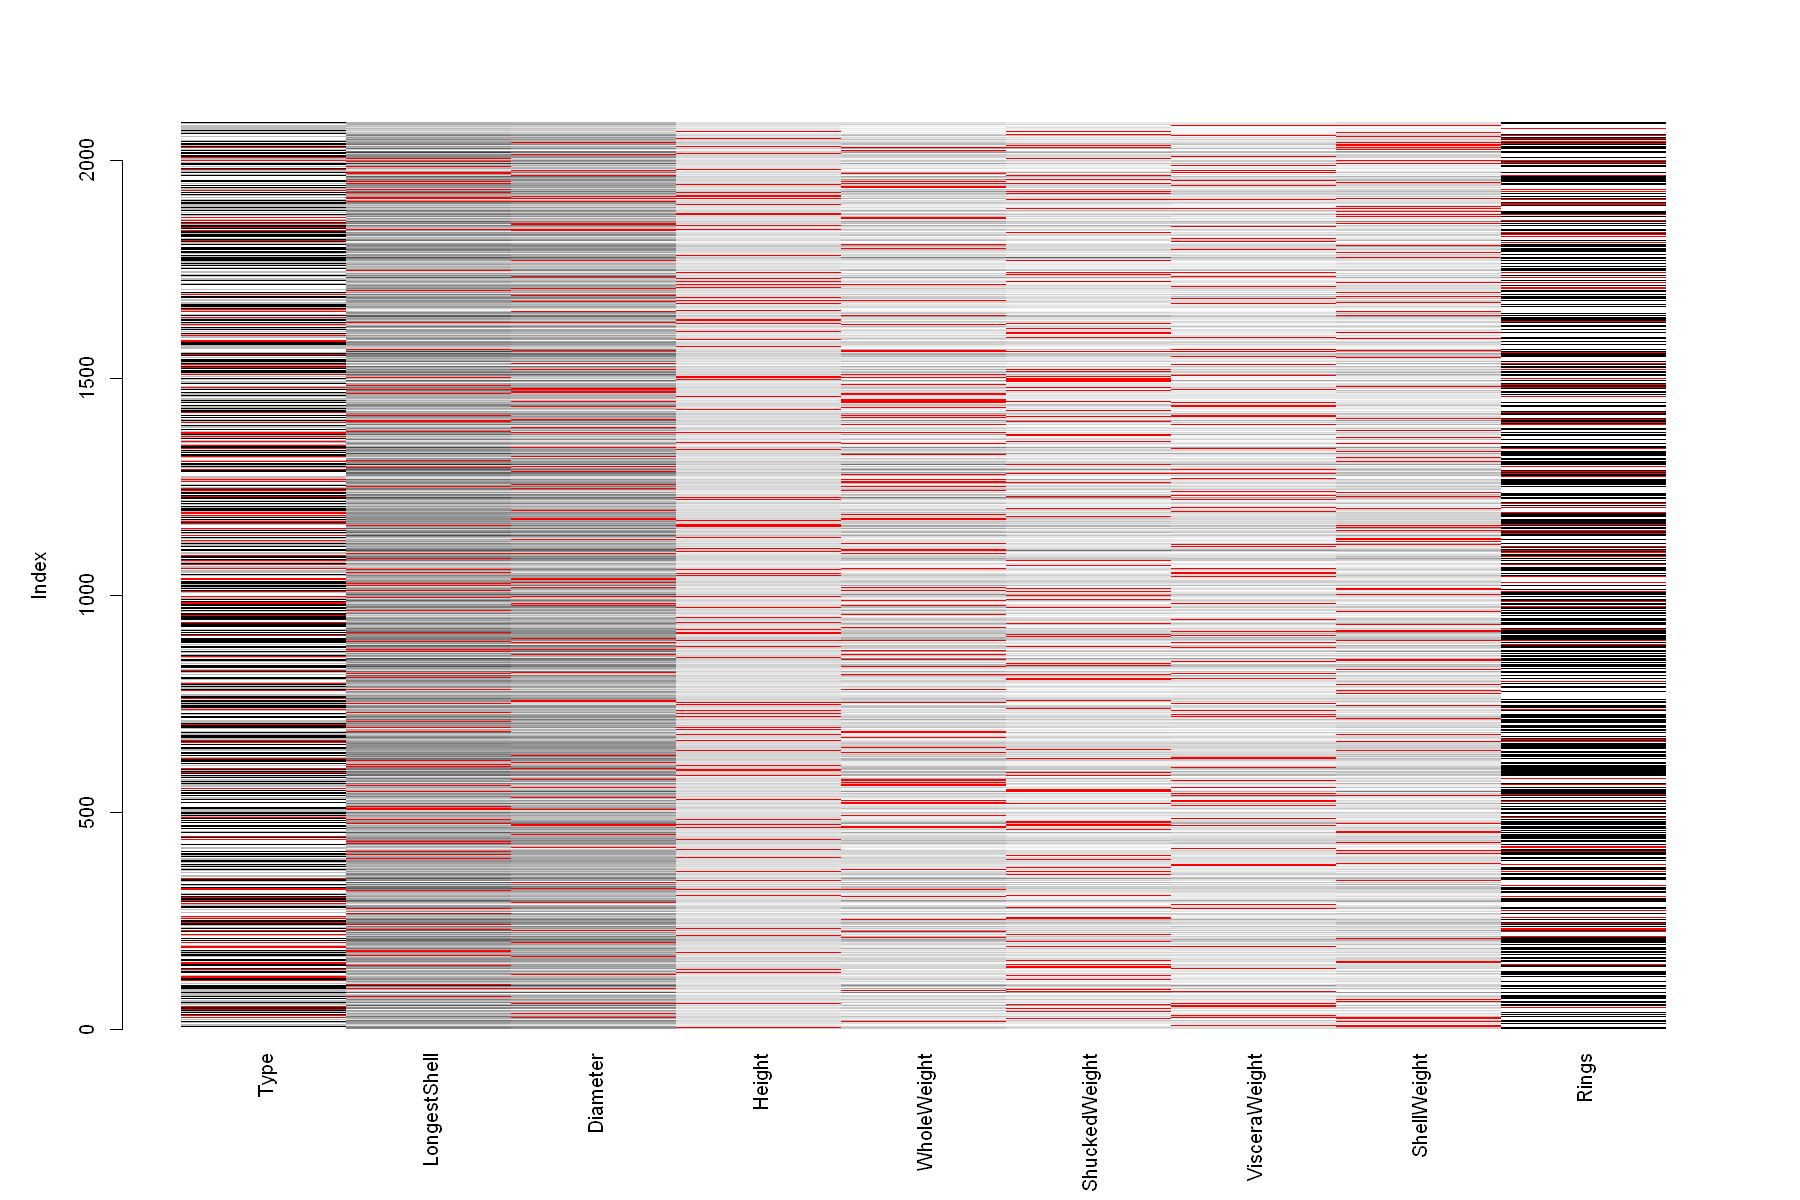

In [28]:
set.seed(81)
train_ab_mis <- prodNA(train_ab, 0.1)

par(oma = c(2,1,1,1))
matrixplot(train_ab_mis)    

不填补缺失值的情形：

In [29]:
set.seed(2)    #固定xstd：xerror具有随机性--数据随机分割的原因
ct_ab_mis <- rpart(Rings ~ ., data = train_ab_mis, method = "class", cp = 0)  
cto_ab_mis <- prune_se(ct_ab_mis, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2316898

填补后的情形：

In [30]:
set.seed(2) 

train_ab_mis_r <- missRanger(train_ab_mis, seed = 10, verbose = 0)   ##填补训练集缺失值

ct_ab_mis_r <- rpart(Rings ~ ., data = train_ab_mis_r, method = "class", cp = 0)  
cto_ab_mis_r <- prune_se(ct_ab_mis_r, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis_r, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2144567

#### 缺失20%

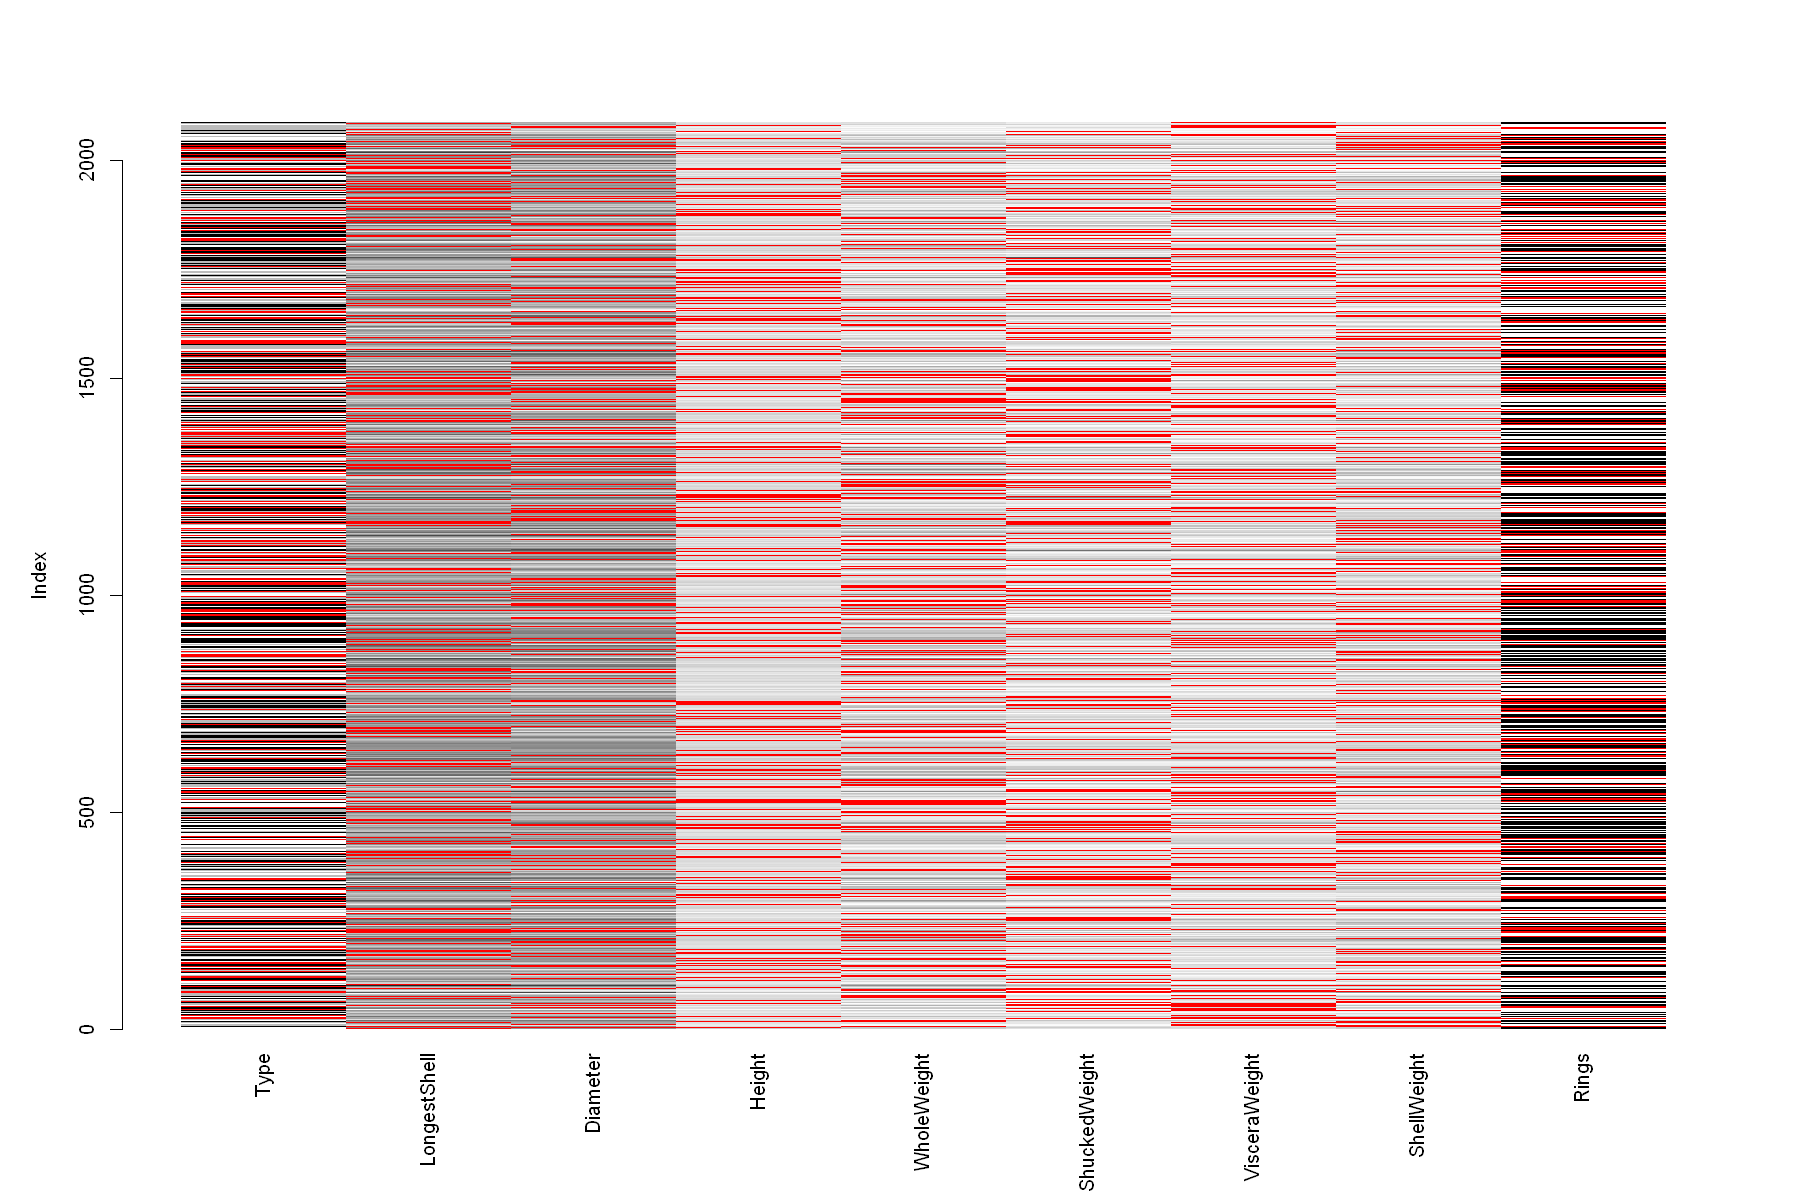

In [31]:
set.seed(81)
train_ab_mis <- prodNA(train_ab, 0.2)

par(oma = c(2,1,1,1))
matrixplot(train_ab_mis)    

不填补缺失值的情形：

In [32]:
set.seed(2)    #固定xstd：xerror具有随机性--数据随机分割的原因
ct_ab_mis <- rpart(Rings ~ ., data = train_ab_mis, method = "class", cp = 0)  
cto_ab_mis <- prune_se(ct_ab_mis, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2326472

填补后的情形：

In [33]:
set.seed(2) 

train_ab_mis_r <- missRanger(train_ab_mis, seed = 10, verbose = 0)   ##填补训练集缺失值

ct_ab_mis_r <- rpart(Rings ~ ., data = train_ab_mis_r, method = "class", cp = 0)  
cto_ab_mis_r <- prune_se(ct_ab_mis_r, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis_r, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2206798

#### 缺失30%

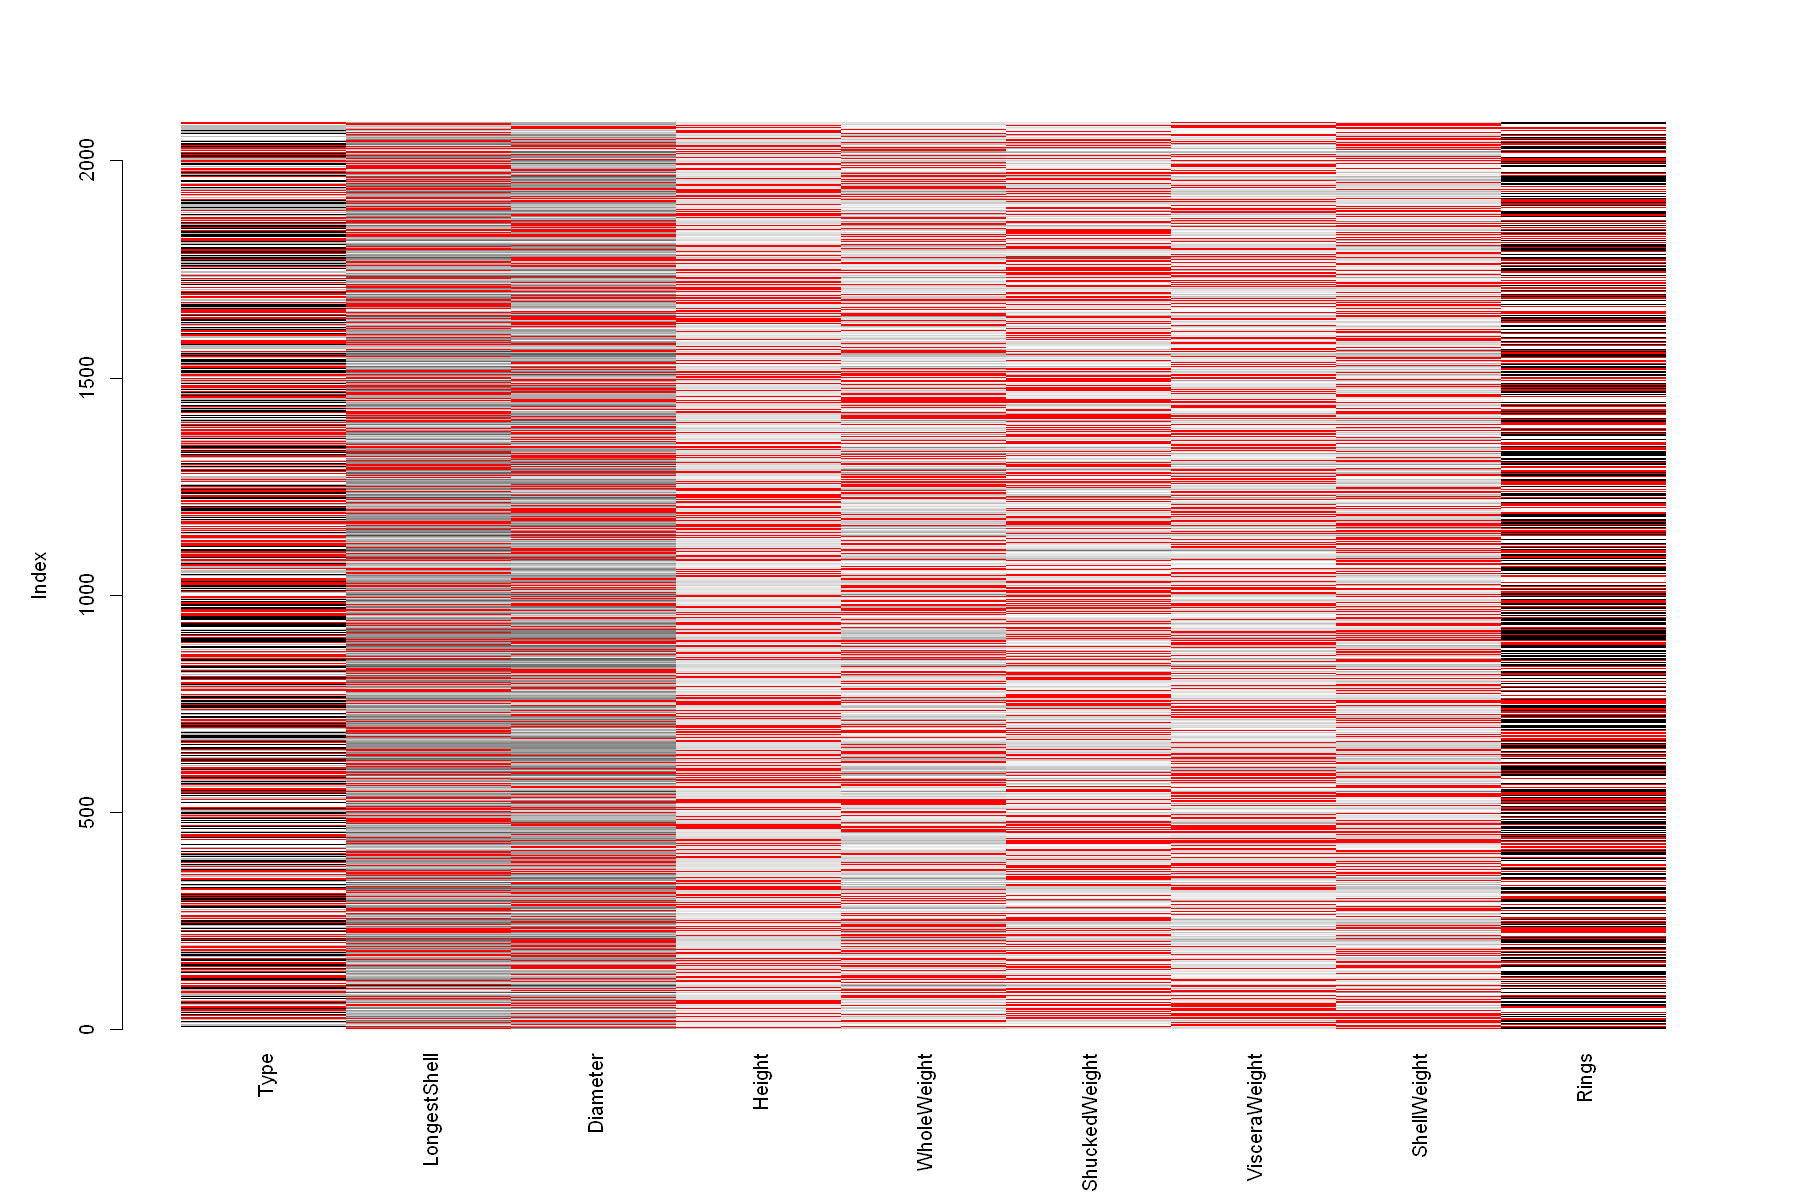

In [34]:
set.seed(81)
train_ab_mis <- prodNA(train_ab, 0.3)

par(oma = c(2,1,1,1))
matrixplot(train_ab_mis)    

不填补缺失值的情形：

In [35]:
set.seed(2)    #固定xstd：xerror具有随机性--数据随机分割的原因
ct_ab_mis <- rpart(Rings ~ ., data = train_ab_mis, method = "class", cp = 0)  
cto_ab_mis <- prune_se(ct_ab_mis, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2312111

填补后的情形：

In [36]:
set.seed(2) 

train_ab_mis_r <- missRanger(train_ab_mis, seed = 10, verbose = 0)   ##填补训练集缺失值

ct_ab_mis_r <- rpart(Rings ~ ., data = train_ab_mis_r, method = "class", cp = 0)  
cto_ab_mis_r <- prune_se(ct_ab_mis_r, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis_r, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2206798

#### 缺失40%

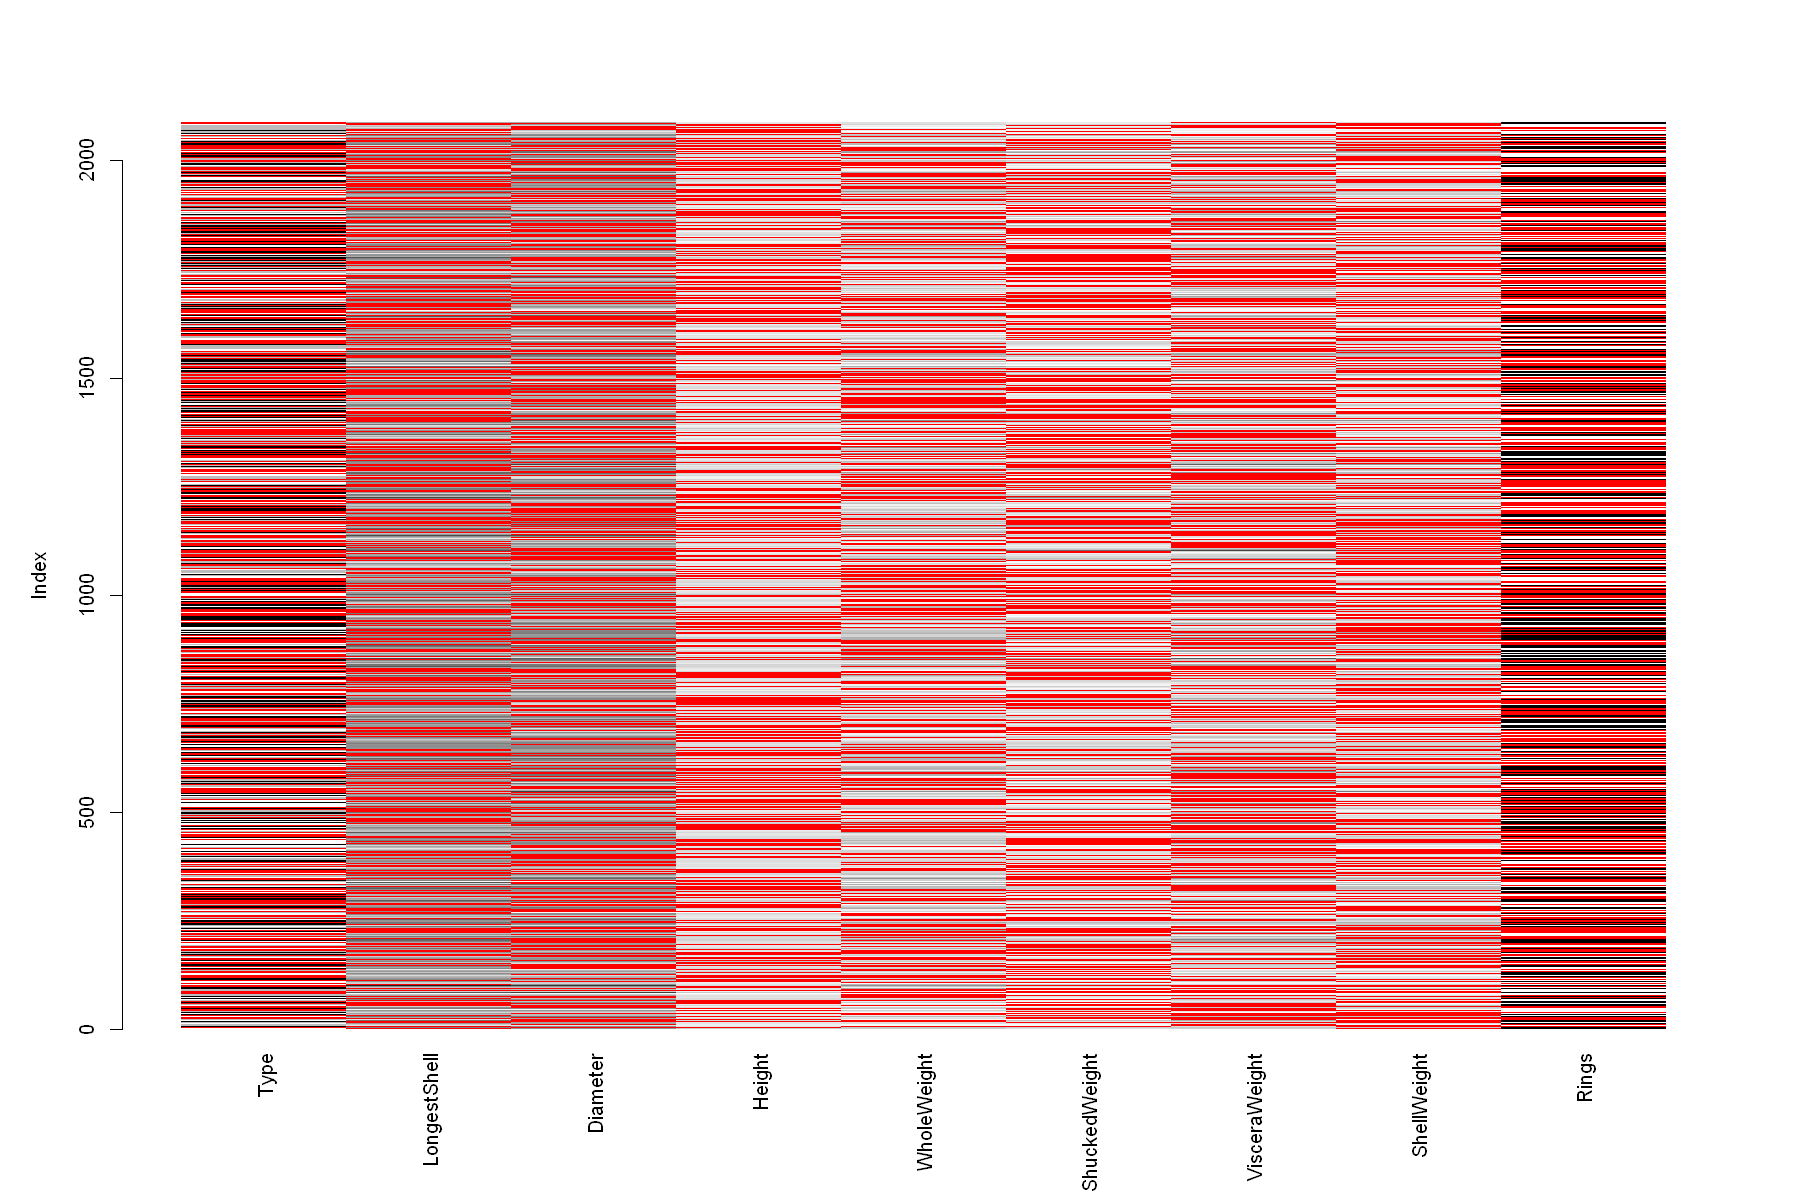

In [37]:
set.seed(81)
train_ab_mis <- prodNA(train_ab, 0.4)

par(oma = c(2,1,1,1))
matrixplot(train_ab_mis)    

不填补缺失值的情形：

In [38]:
set.seed(2)    #固定xstd：xerror具有随机性--数据随机分割的原因
ct_ab_mis <- rpart(Rings ~ ., data = train_ab_mis, method = "class", cp = 0)  
cto_ab_mis <- prune_se(ct_ab_mis, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2398277

填补后的情形：

In [39]:
set.seed(2) 

train_ab_mis_r <- missRanger(train_ab_mis, seed = 10, verbose = 0)   ##填补训练集缺失值

ct_ab_mis_r <- rpart(Rings ~ ., data = train_ab_mis_r, method = "class", cp = 0)  
cto_ab_mis_r <- prune_se(ct_ab_mis_r, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis_r, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2302537

#### 缺失50%

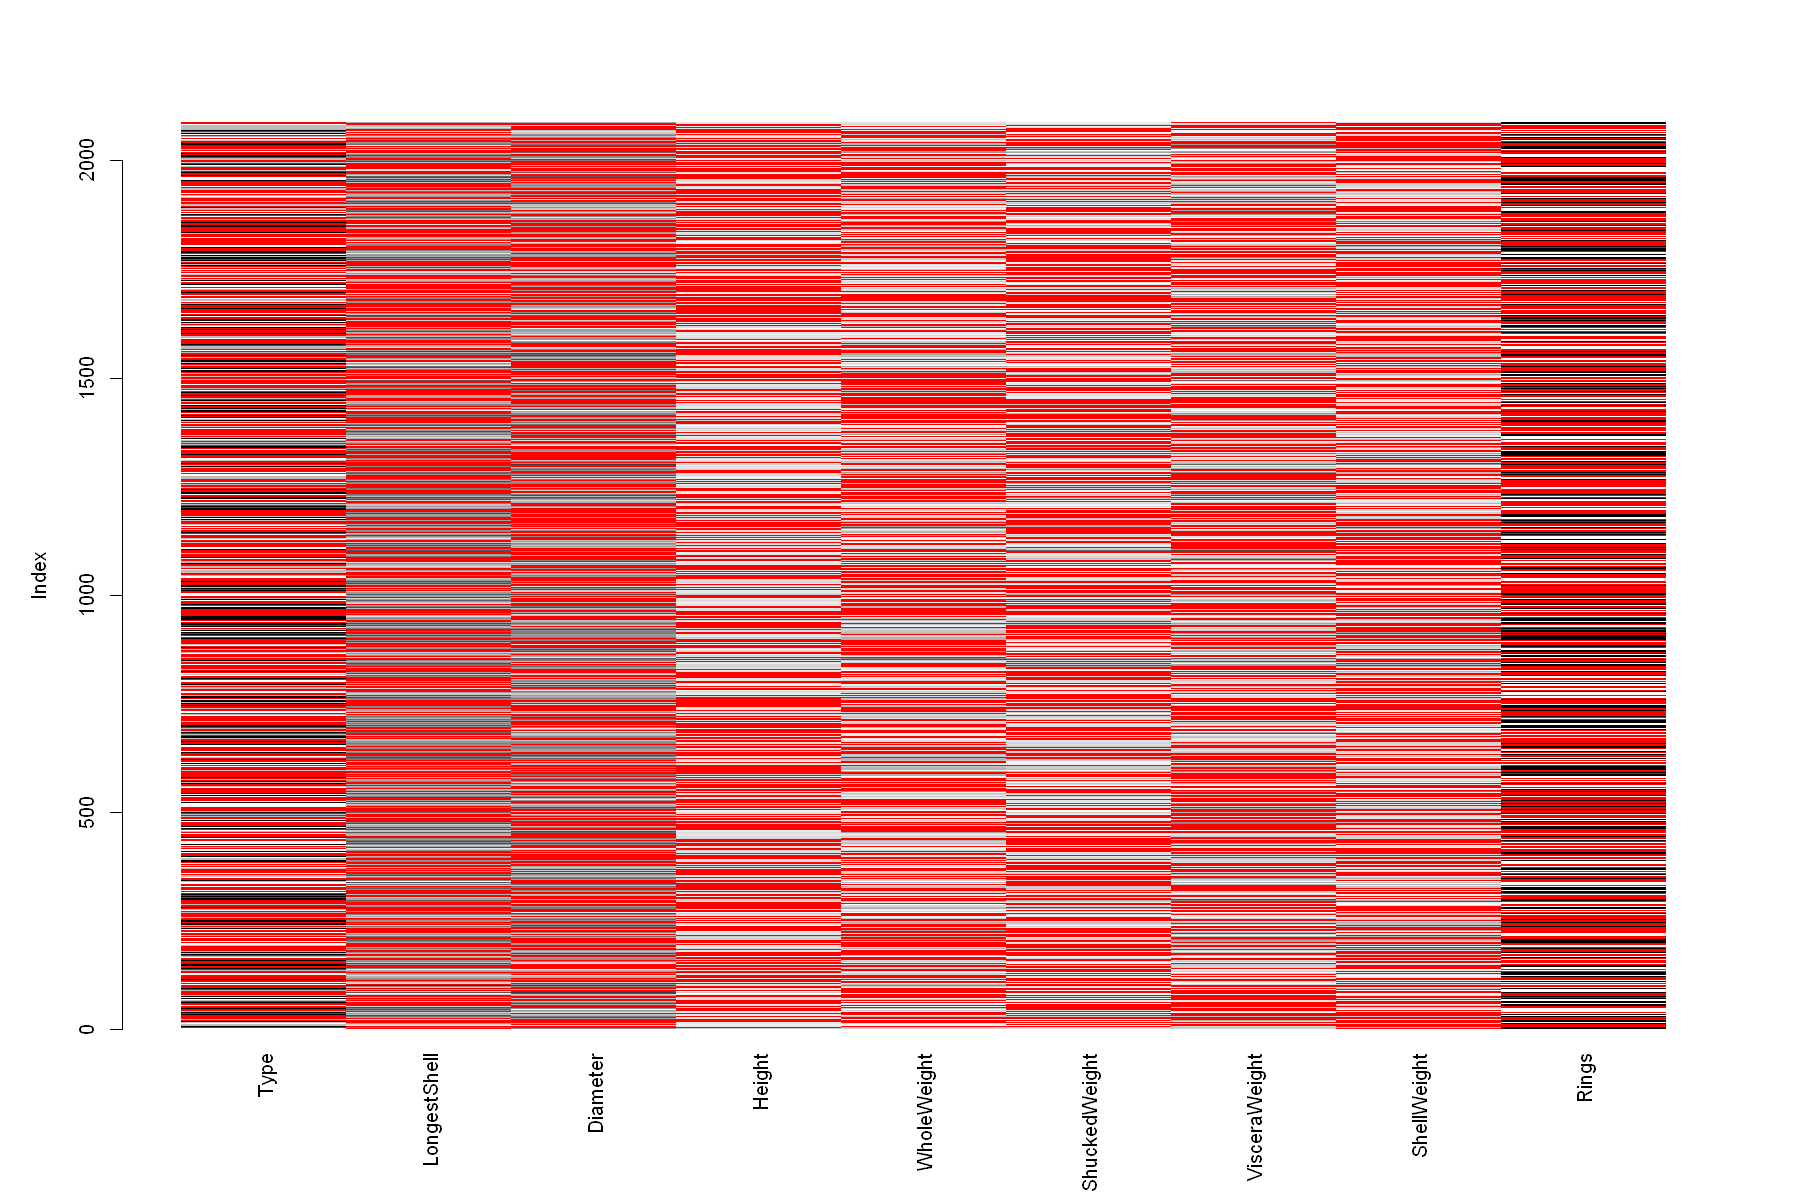

In [40]:
set.seed(81)
train_ab_mis <- prodNA(train_ab, 0.5)

par(oma = c(2,1,1,1))
matrixplot(train_ab_mis)    

不填补缺失值的情形：

In [41]:
set.seed(2)    #固定xstd：xerror具有随机性--数据随机分割的原因
ct_ab_mis <- rpart(Rings ~ ., data = train_ab_mis, method = "class", cp = 0)  
cto_ab_mis <- prune_se(ct_ab_mis, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2776448

填补后的情形：

In [42]:
train_ab_mis_r <- missRanger(train_ab_mis, seed = 10, verbose = 0)   ##填补训练集缺失值

set.seed(2) 
ct_ab_mis_r <- rpart(Rings ~ ., data = train_ab_mis_r, method = "class", cp = 0)  
cto_ab_mis_r <- prune_se(ct_ab_mis_r, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis_r, test_ab, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2398277

可见，若测试集完整，填补后得到的决策树针的测试集错判率优于未填补的。

## 测试集缺失

--测试集的所有特征一定程度缺失，训练集完整，比较随机森林算法测试集填补前后rpart决策树的测试集错判率。

In [1]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 22, repr.plot.height = 10) # 满幅

p_load(rpart, missForest, VIM, missRanger, treemisc, AppliedPredictiveModeling, skimr)
s <- skim_tee

Warning message:
"package 'pacman' was built under R version 4.3.3"


In [2]:
data(abalone)
ab <- abalone
ab$Rings <- factor((ab$Rings) > 9, labels = c("L", "H")) # 处理成二类，逻辑型factor的levels的排序默认是：FALSE,TRUE，分别对应于"L","H"

# 将数据集1:1随机分割成训练集和测试集
set.seed(100)
I <- sample(nrow(ab), nrow(ab) * 0.5)
train_ab <- ab[I, ]
test_ab <- ab[-I, ]

#### 各特征缺失10%

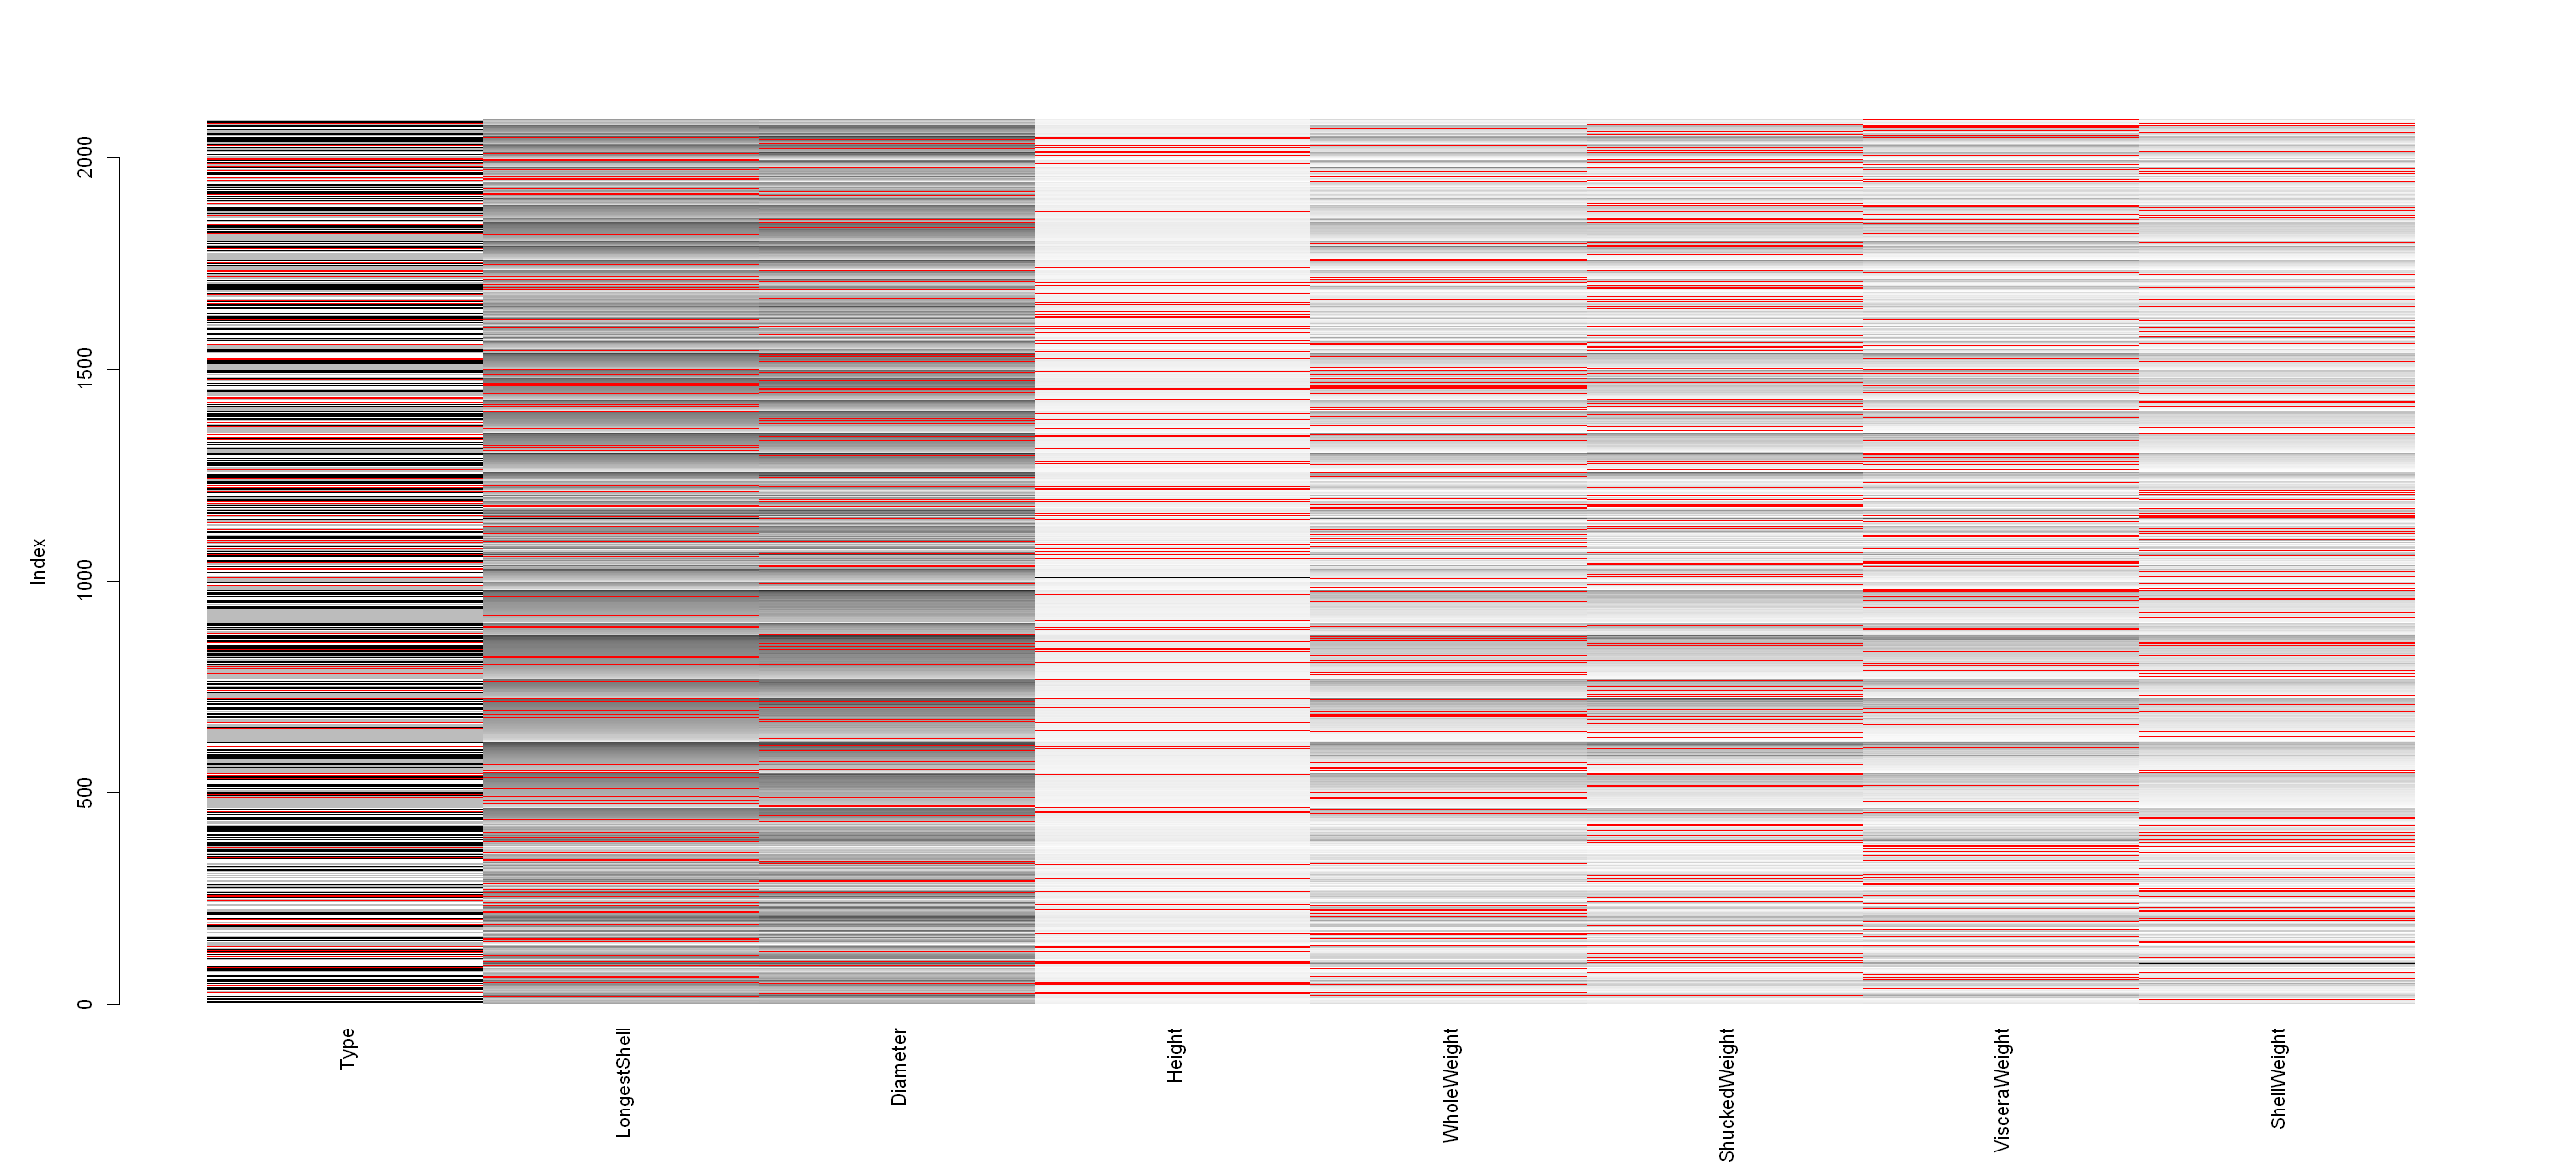

In [3]:
set.seed(81)
test_ab_mis <- test_ab[,-9]
test_ab_mis <- prodNA(test_ab_mis, 0.1)

par(oma = c(2,1,1,1))
matrixplot(test_ab_mis)    

In [4]:
ct_ab <- rpart(Rings ~ ., data = train_ab, method = "class", cp = 0)  
cto_ab <- prune_se(ct_ab, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab, test_ab_mis, type = "class") != test_ab$Rings))    #测试集的错判率

[1] 0.2273815

In [7]:
test_ab_mis_r <- missRanger(test_ab_mis, seed = 10, verbose = 0)   ##填补训练集缺失值

(mean(predict(cto_ab, test_ab_mis_r, type = "class") != test_ab$Rings))    #测试集的错判率

[1] 0.2240306

#### 各特征缺失20%

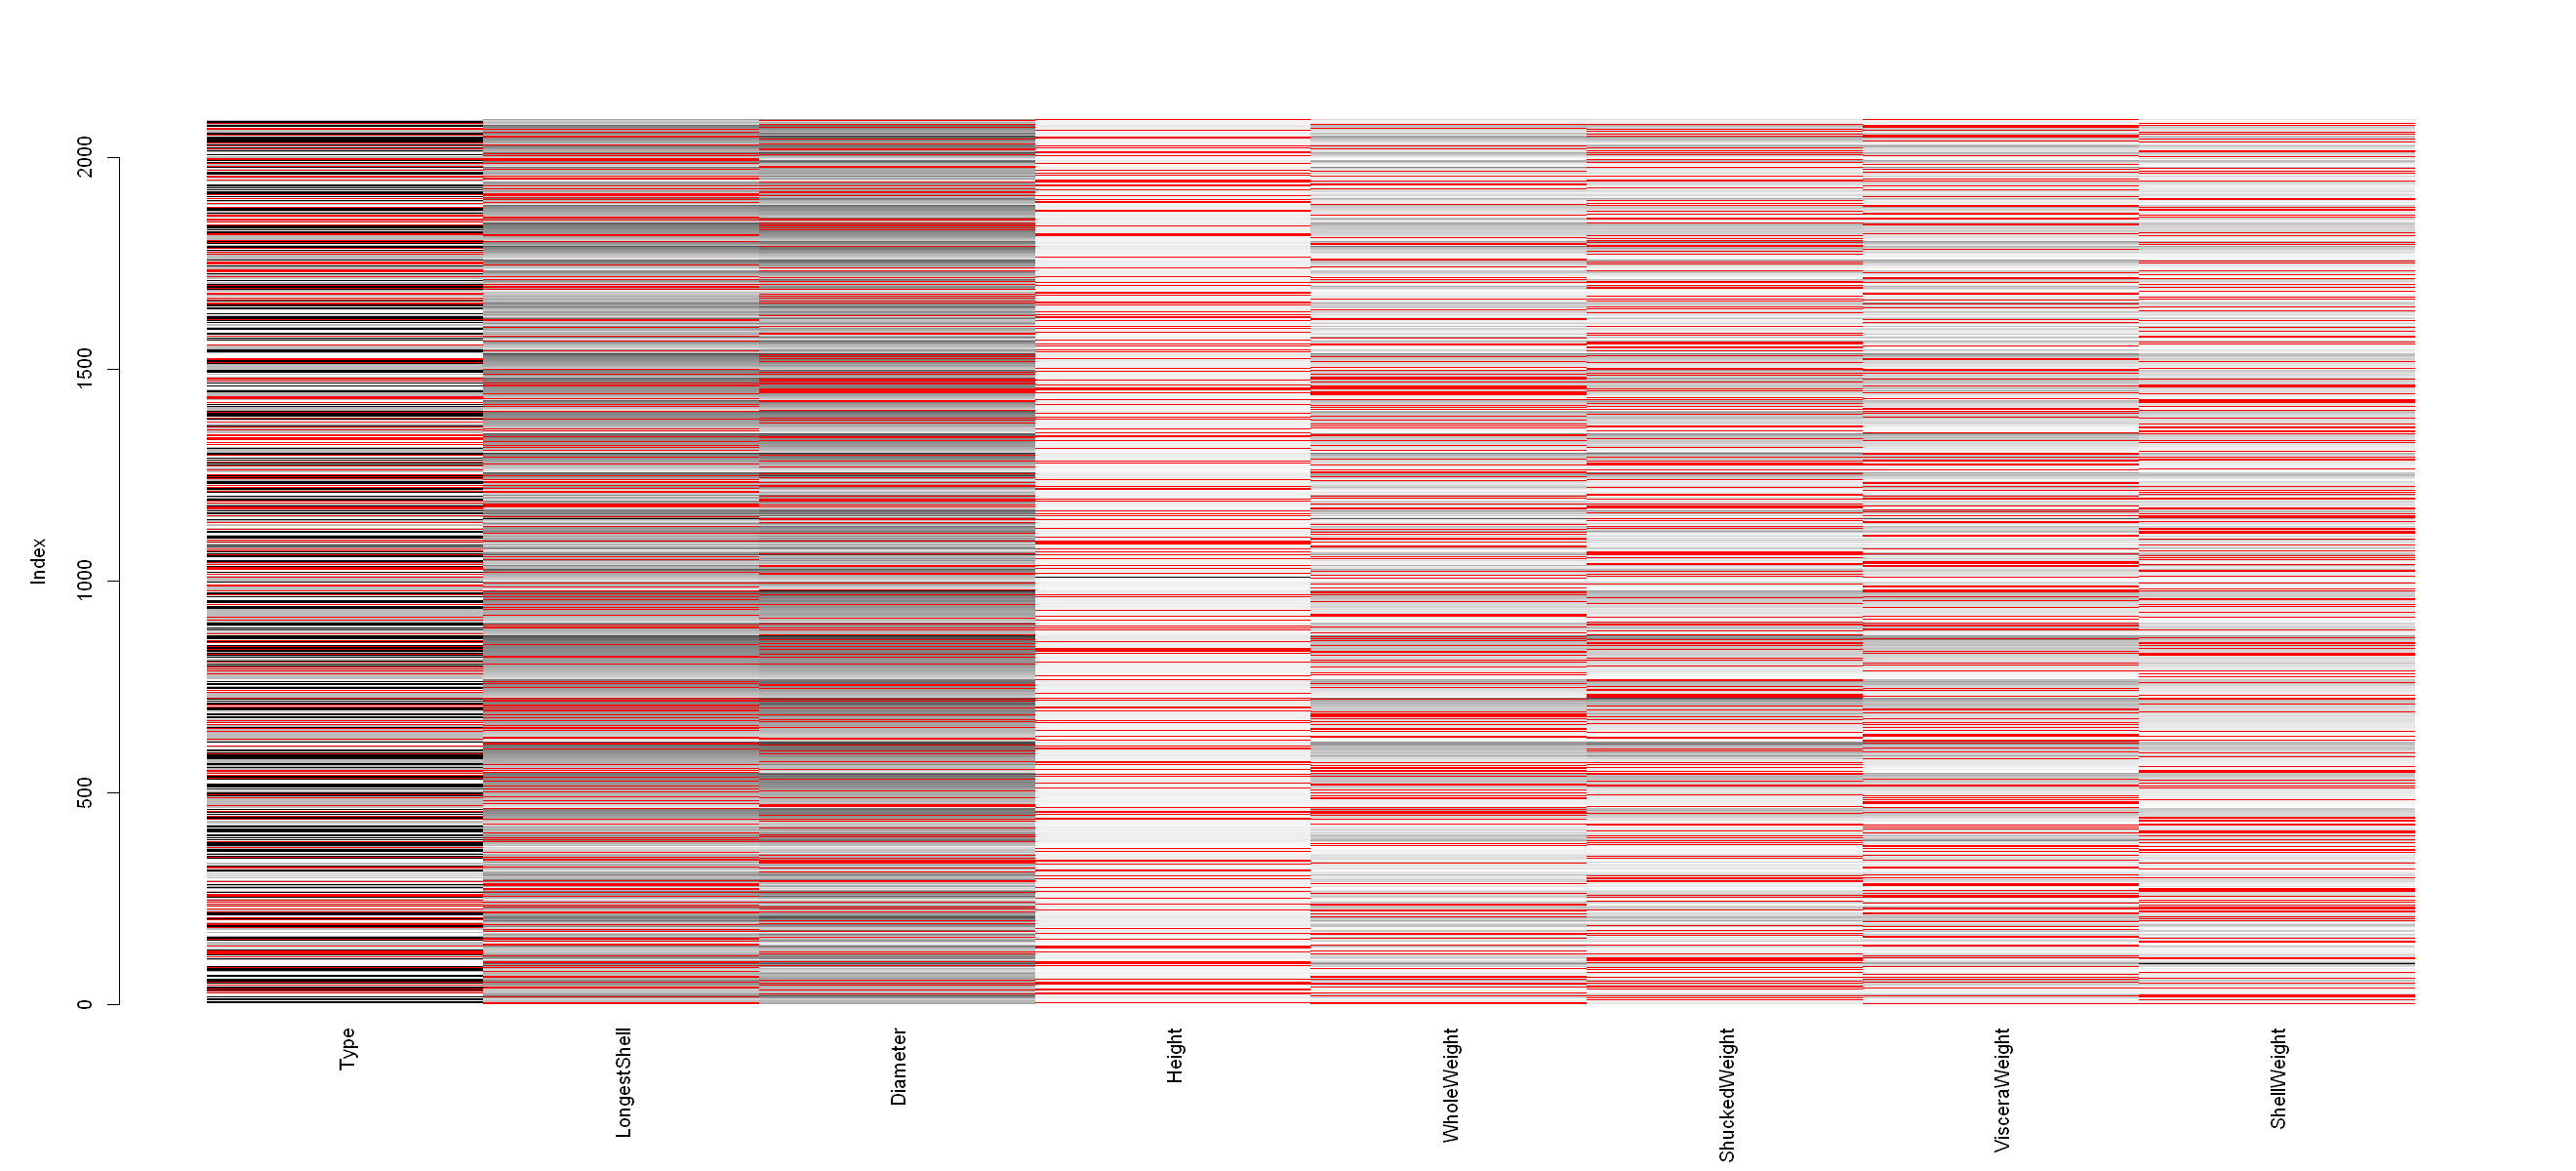

In [6]:
set.seed(81)
test_ab_mis <- test_ab[,-9]
test_ab_mis <- prodNA(test_ab_mis, 0.2)

par(oma = c(2,1,1,1))
matrixplot(test_ab_mis)    

In [8]:
(mean(predict(cto_ab, test_ab_mis, type = "class") != test_ab$Rings))    #测试集的错判率

[1] 0.2307324

In [9]:
test_ab_mis_r <- missRanger(test_ab_mis, seed = 10, verbose = 0)   ##填补训练集缺失值
(mean(predict(cto_ab, test_ab_mis_r, type = "class") != test_ab$Rings))    #测试集的错判率

[1] 0.2240306

#### 各特征缺失30%

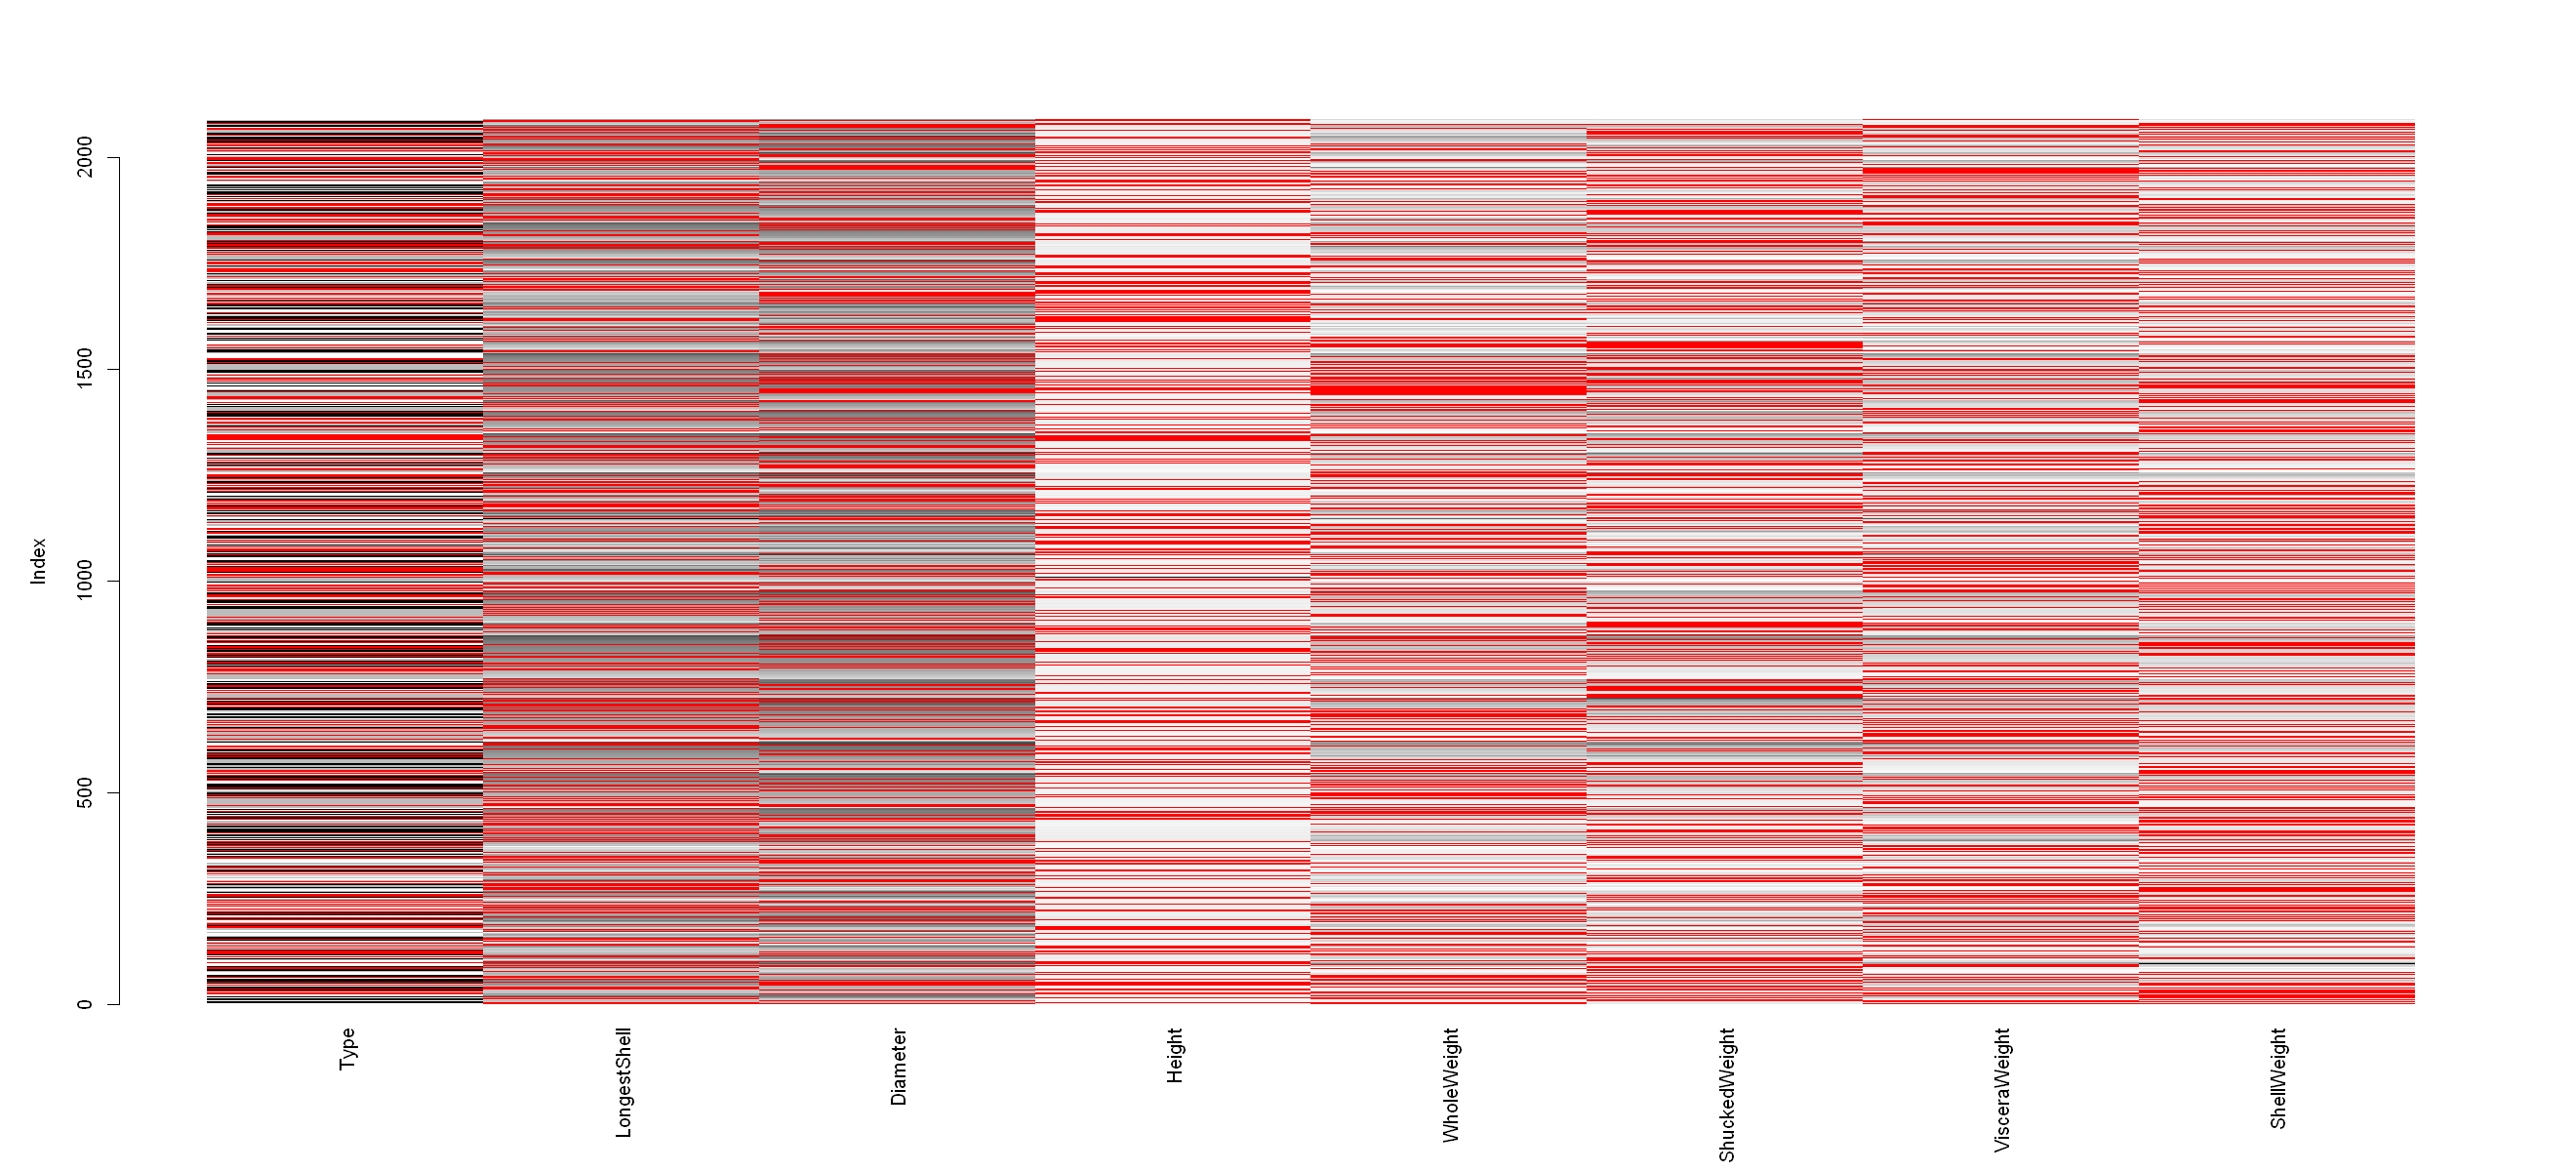

In [10]:
set.seed(81)
test_ab_mis <- test_ab[,-9]
test_ab_mis <- prodNA(test_ab_mis, 0.3)

par(oma = c(2,1,1,1))
matrixplot(test_ab_mis)    

In [11]:
(mean(predict(cto_ab, test_ab_mis, type = "class") != test_ab$Rings))    #测试集的错判率

[1] 0.239349

In [12]:
test_ab_mis_r <- missRanger(test_ab_mis, seed = 10, verbose = 0)   ##填补训练集缺失值
(mean(predict(cto_ab, test_ab_mis_r, type = "class") != test_ab$Rings))    #测试集的错判率

[1] 0.2316898

#### 各特征缺失40%

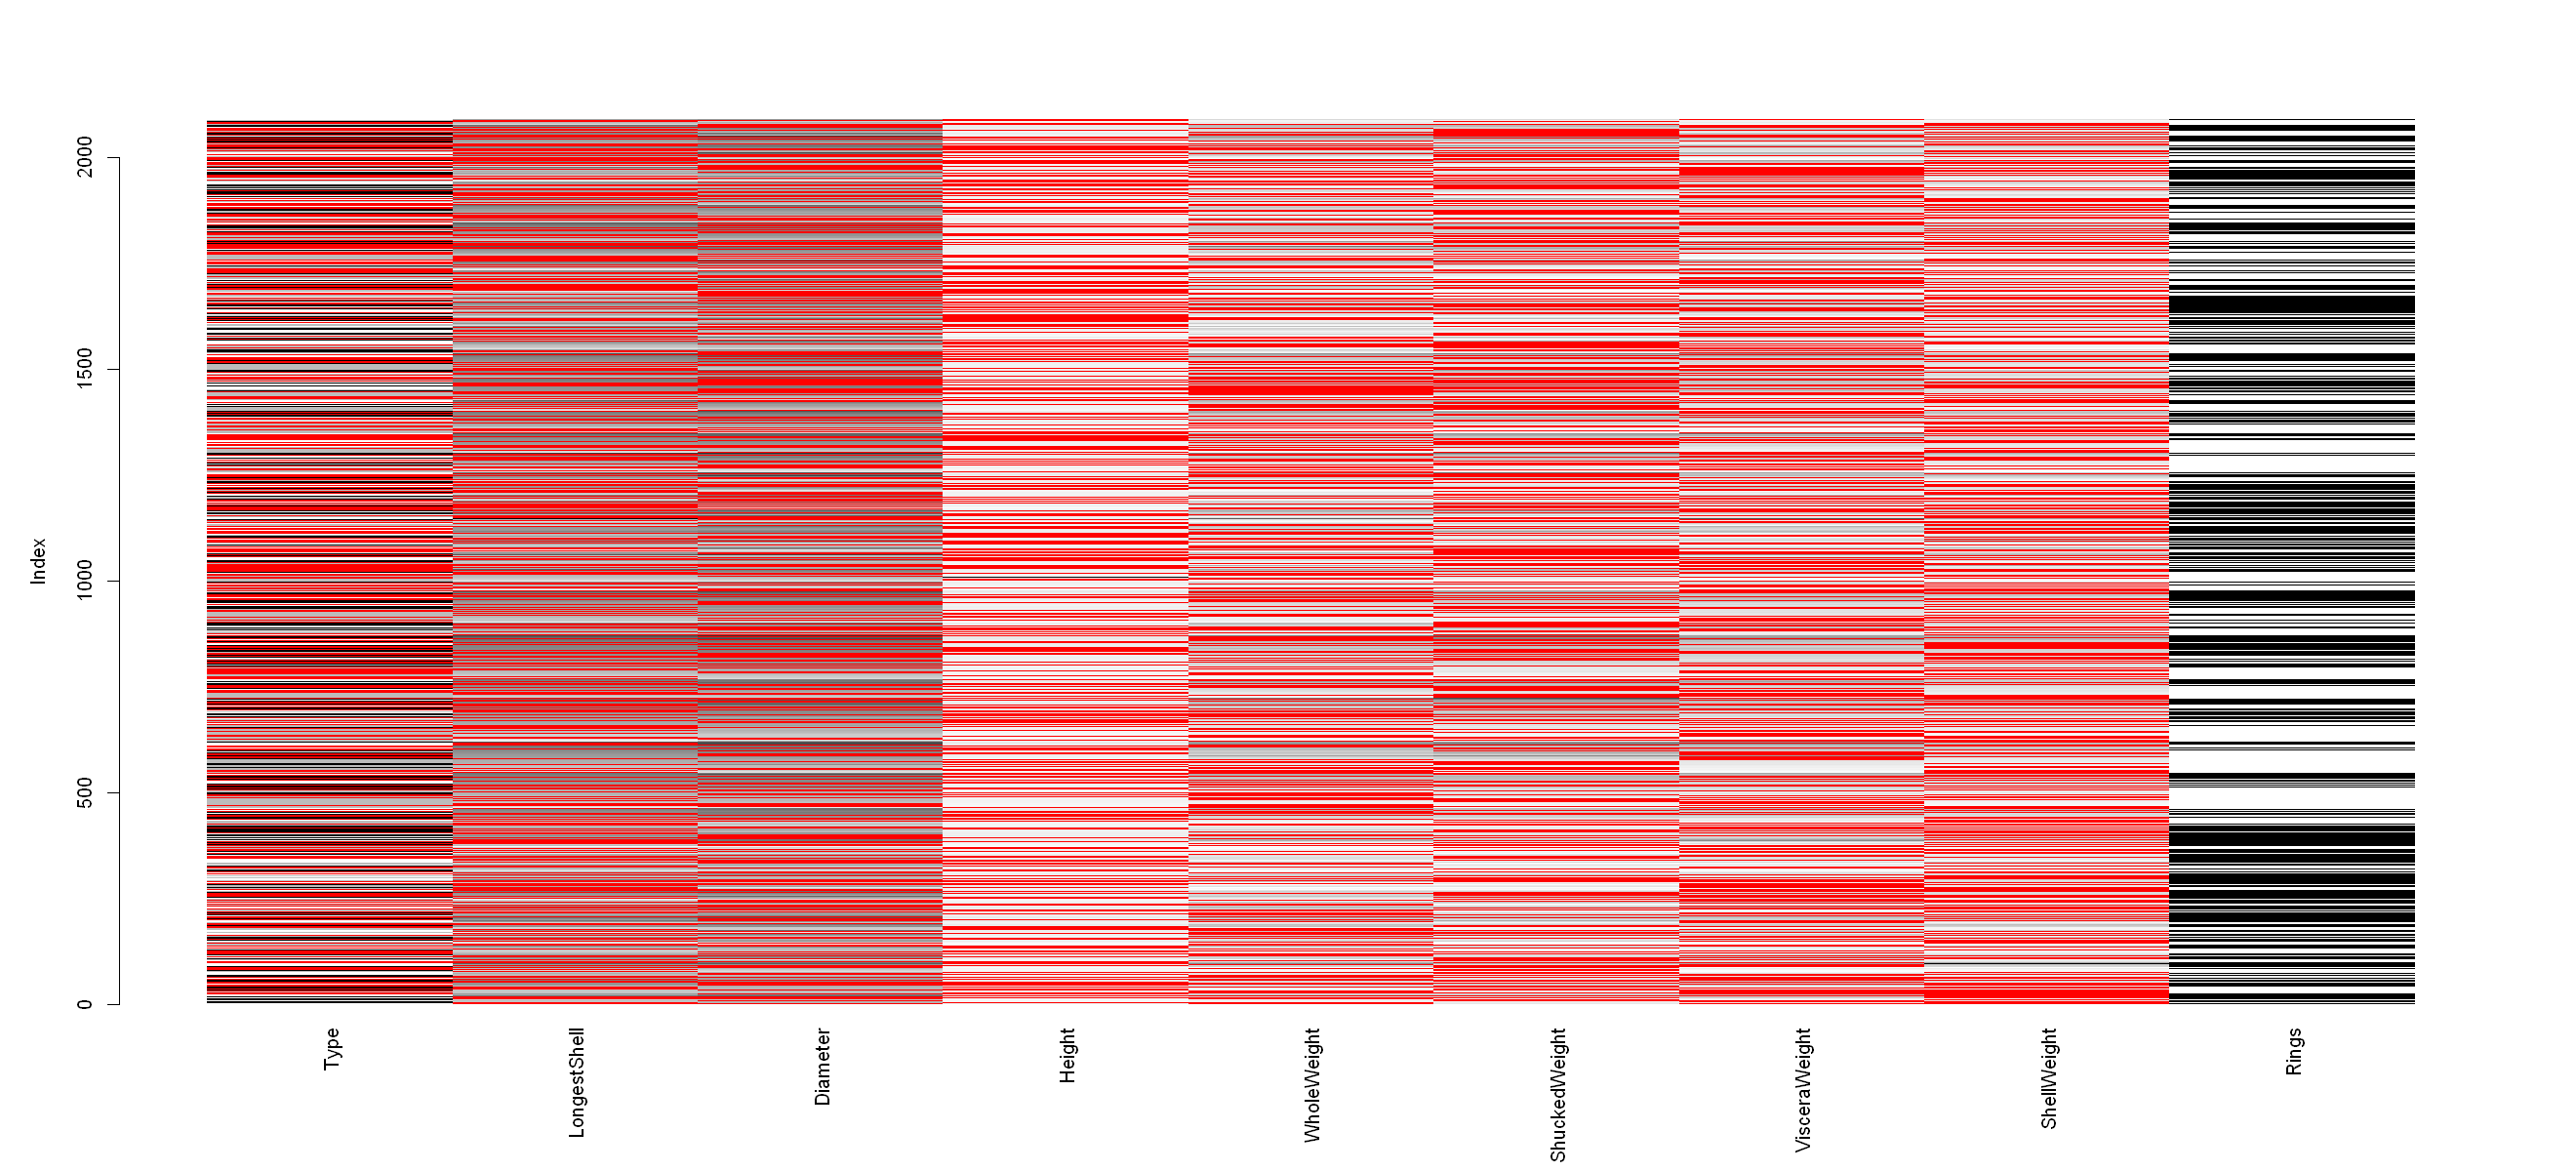

In [13]:
set.seed(81)
test_ab_mis <- test_ab
test_ab_mis[,-9] <- prodNA(test_ab[,-9], 0.4)

par(oma = c(2,1,1,1))
matrixplot(test_ab_mis)    

In [14]:
(mean(predict(cto_ab, test_ab_mis, type = "class") != test_ab$Rings))    #测试集的错判率

[1] 0.2450933

In [15]:
test_ab_mis_r <- missRanger(test_ab_mis, seed = 10, verbose = 0)   ##填补训练集缺失值
(mean(predict(cto_ab, test_ab_mis_r, type = "class") != test_ab$Rings))    #测试集的错判率

[1] 0.2173289

可见，若训练集完整，填补后的测试集错判率优于测试集未填补的。

## 建模及预测时都缺失

--训练集的所有变量(自变量和因变量)和测试集的自变量一定程度缺失，比较随机森林算法填补前后rpart决策树的测试集错判率。

In [12]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 22, repr.plot.height = 10) # 满幅

p_load(rpart, missForest, VIM, missRanger, treemisc, AppliedPredictiveModeling, skimr)
s <- skim_tee

In [13]:
data(abalone)
ab <- abalone
ab$Rings <- factor((ab$Rings) > 9, labels = c("L", "H")) # 处理成二类，逻辑型factor的levels的排序默认是：FALSE,TRUE，分别对应于"L","H"
s(ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             4177  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   2     
  numeric                  7     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts               
1 Type                  0             1 FALSE          3 M: 1528, I: 1342, F: 1307
2 Rings                 0             1 FALSE          2 L: 2096, H: 2081         

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50   p75  p100 h

### 缺失10%

--指的是训练集的自变量、因变量以及测试集的自变量都缺失10%，以下均是类似的含义

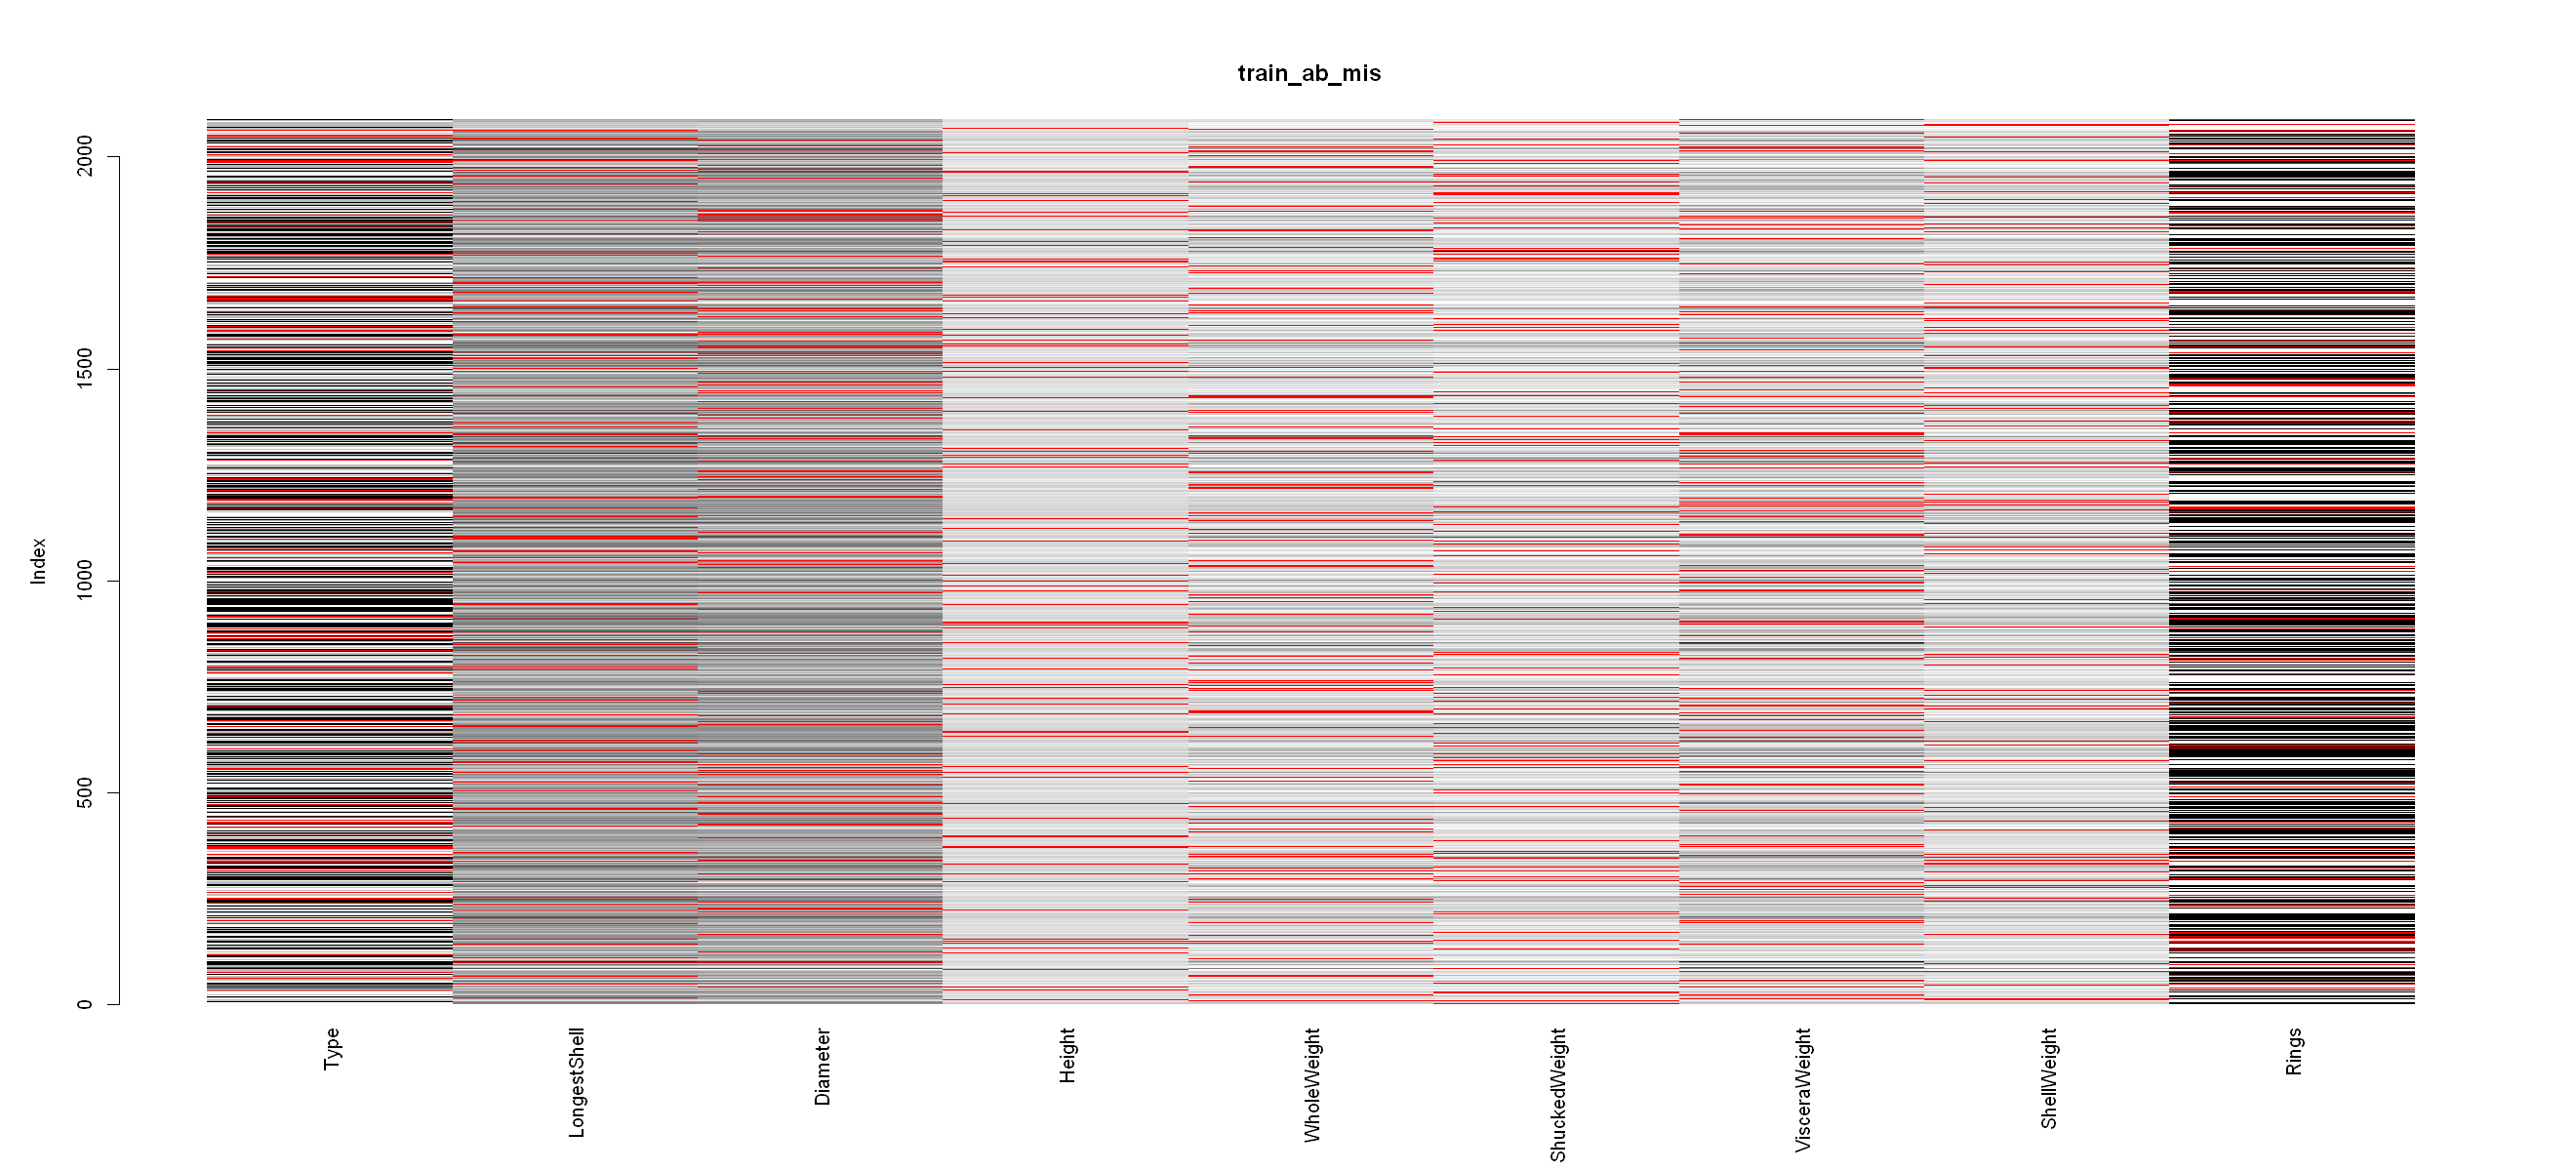

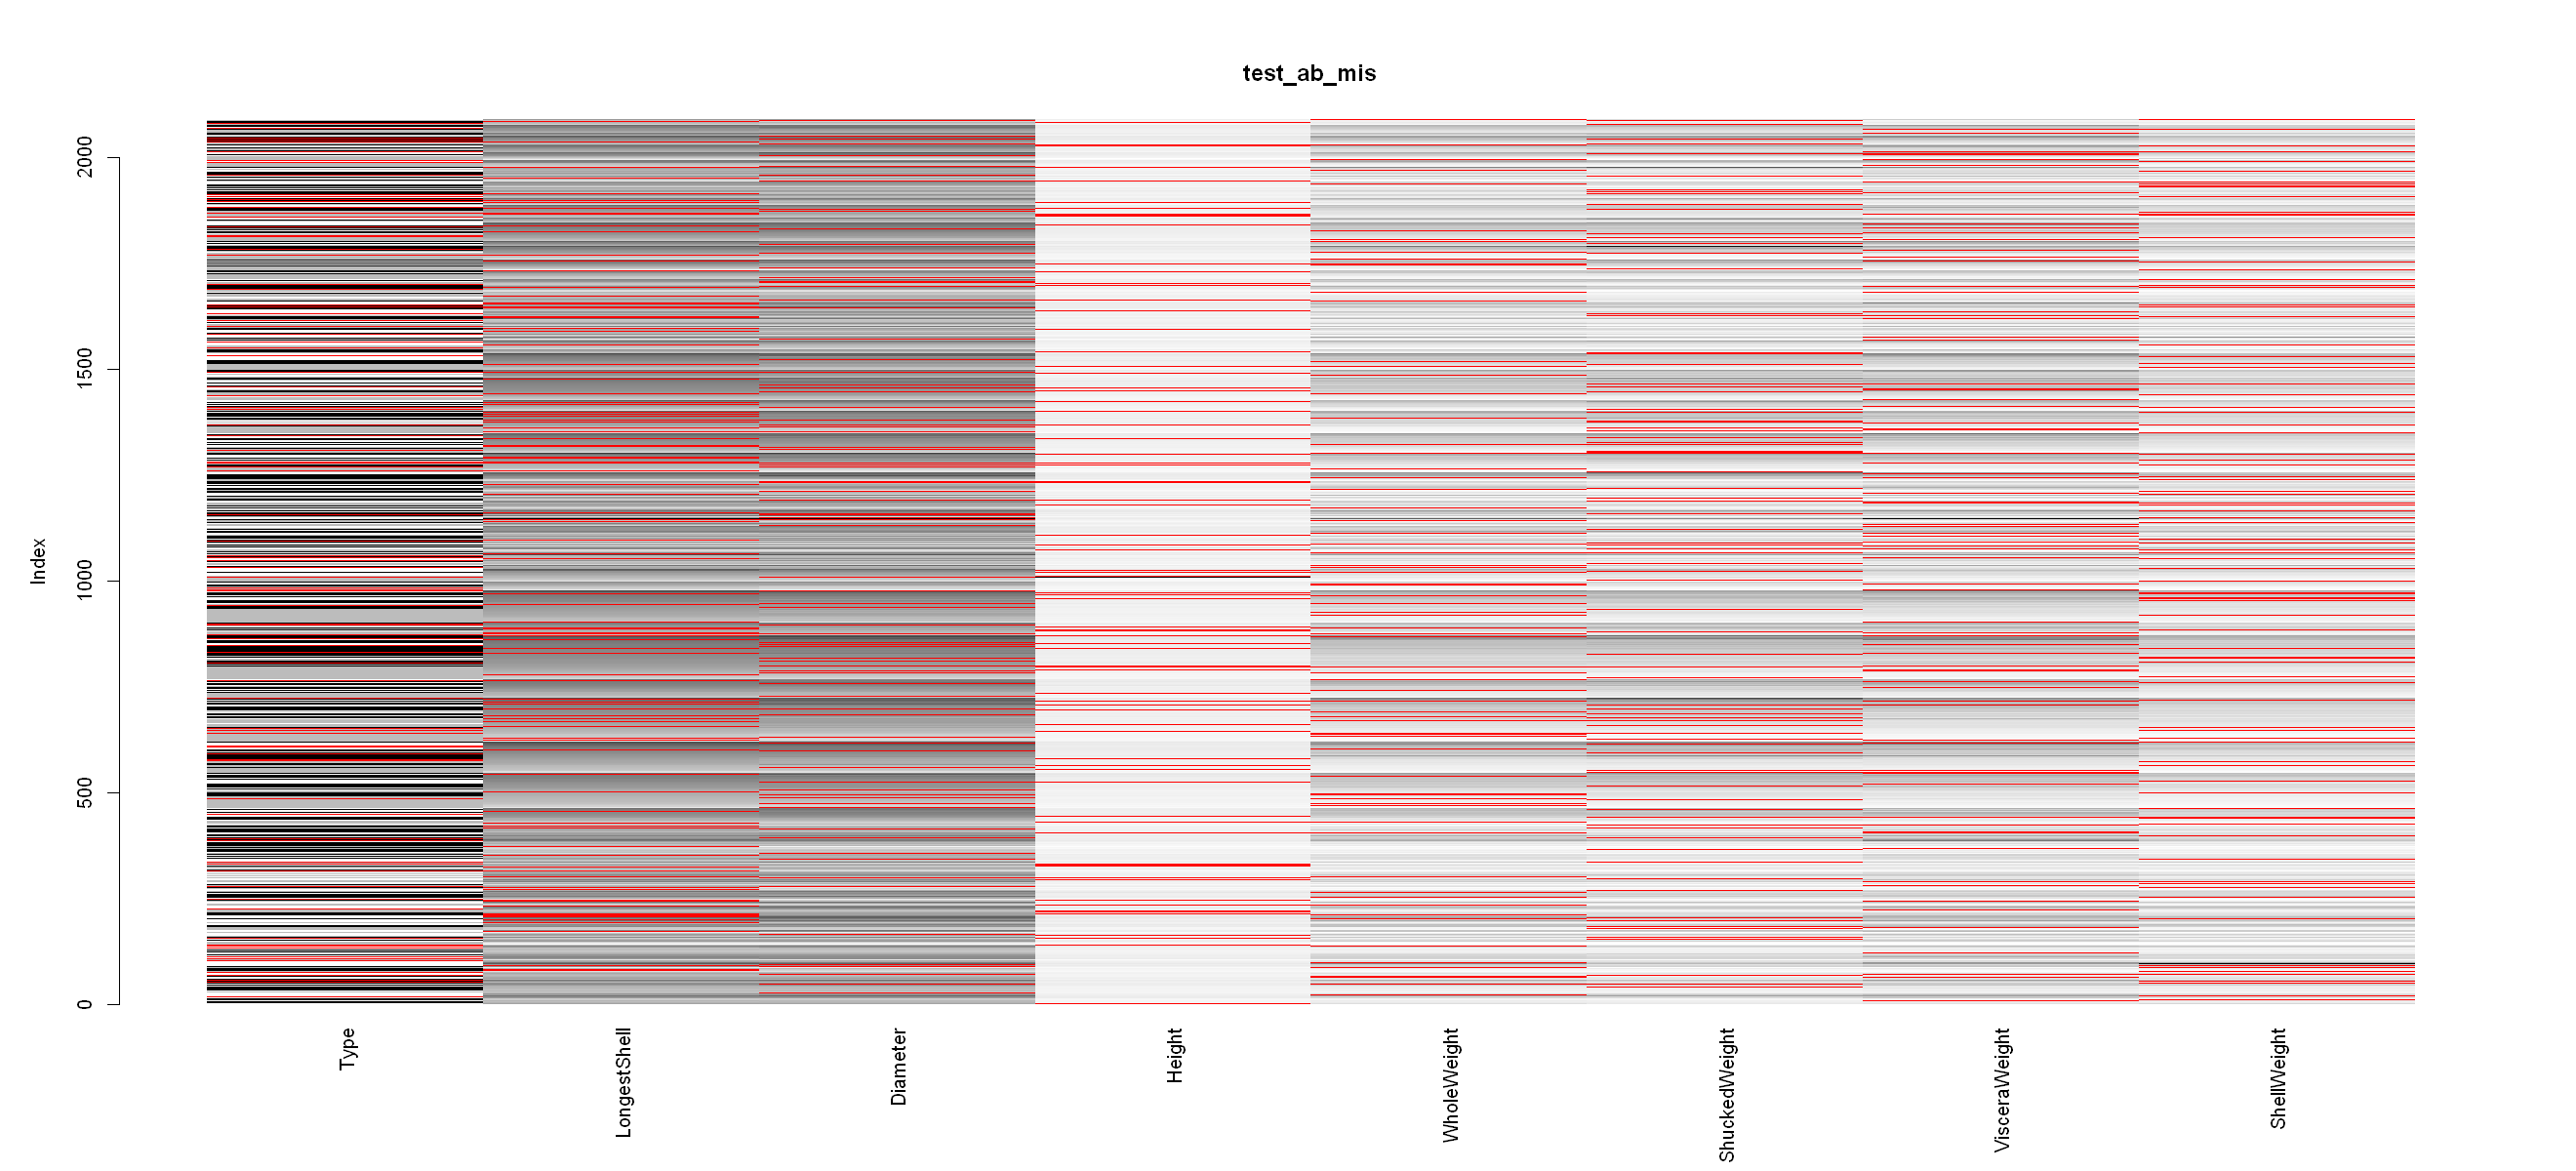

In [33]:
set.seed(100)
I <- sample(nrow(ab), nrow(ab) * 0.5) # 将数据集1:1随机分割成训练集和测试集
test_ab <- ab[-I, ]

ab_mis <- prodNA(ab, 0.1)   #各变量均缺失10%
ab_mis[-I, 9] <- NA         #测试集的目标变量值置为缺失
train_ab_mis <- ab_mis[I,]  #训练集
test_ab_mis <- ab_mis[-I, -9] #测试集  

par(oma = c(2,1,1,1))
matrixplot(train_ab_mis, main = "train_ab_mis")    
matrixplot(test_ab_mis, main = "test_ab_mis") 

In [15]:
#用填补前的训练集得到决策树预测填补前的测试集
set.seed(2)    #固定xstd：xerror具有随机性--数据随机分割的原因
ct_ab_mis <- rpart(Rings ~ ., data = train_ab_mis, method = "class", cp = 0)  
cto_ab_mis <- prune_se(ct_ab_mis, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis, test_ab_mis, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.218765

In [17]:
#随机森林算法填补训练集和测试集
train_ab_mis_r <- missRanger(train_ab_mis, seed = 10, verbose = 0)
test_ab_mis_r <- missRanger(test_ab_mis, seed = 10, verbose = 0)

#matrixplot(train_ab_mis_r, main = "train_ab_mis")    
#matrixplot(test_ab_mis_r, main = "test_ab_mis") 

#用填补后的训练集得到决策树预测填补后的测试集
set.seed(2)
ct_ab_mis_r <- rpart(Rings ~ ., data = train_ab_mis_r, method = "class", cp = 0)  
cto_ab_mis_r <- prune_se(ct_ab_mis_r, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis_r, test_ab_mis_r, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2178076

### 缺失20%

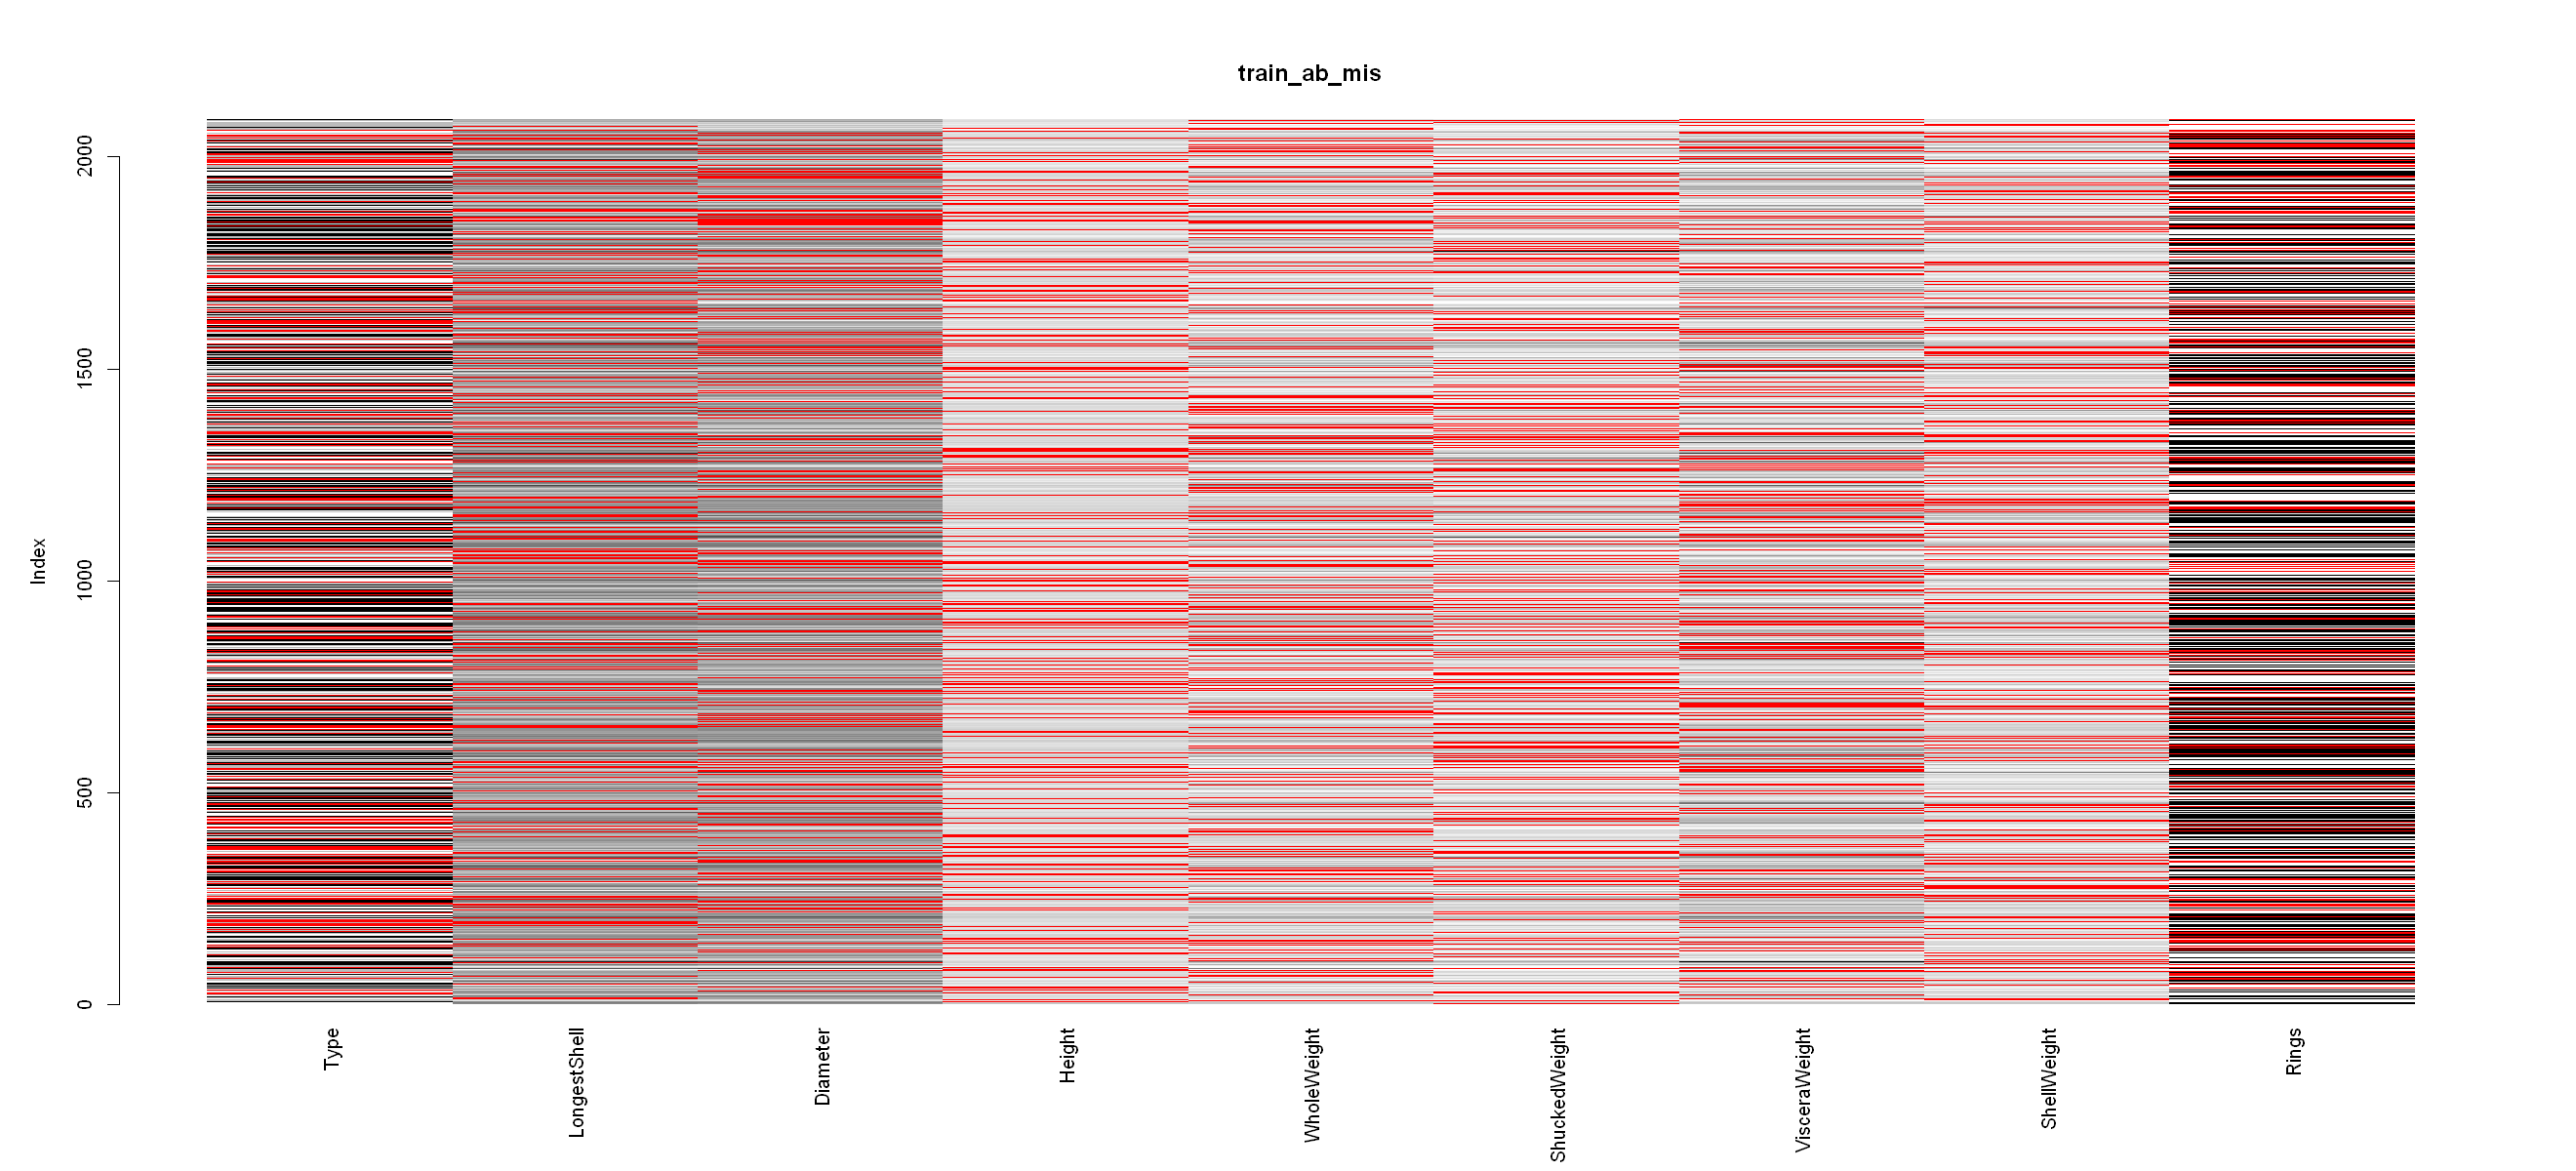

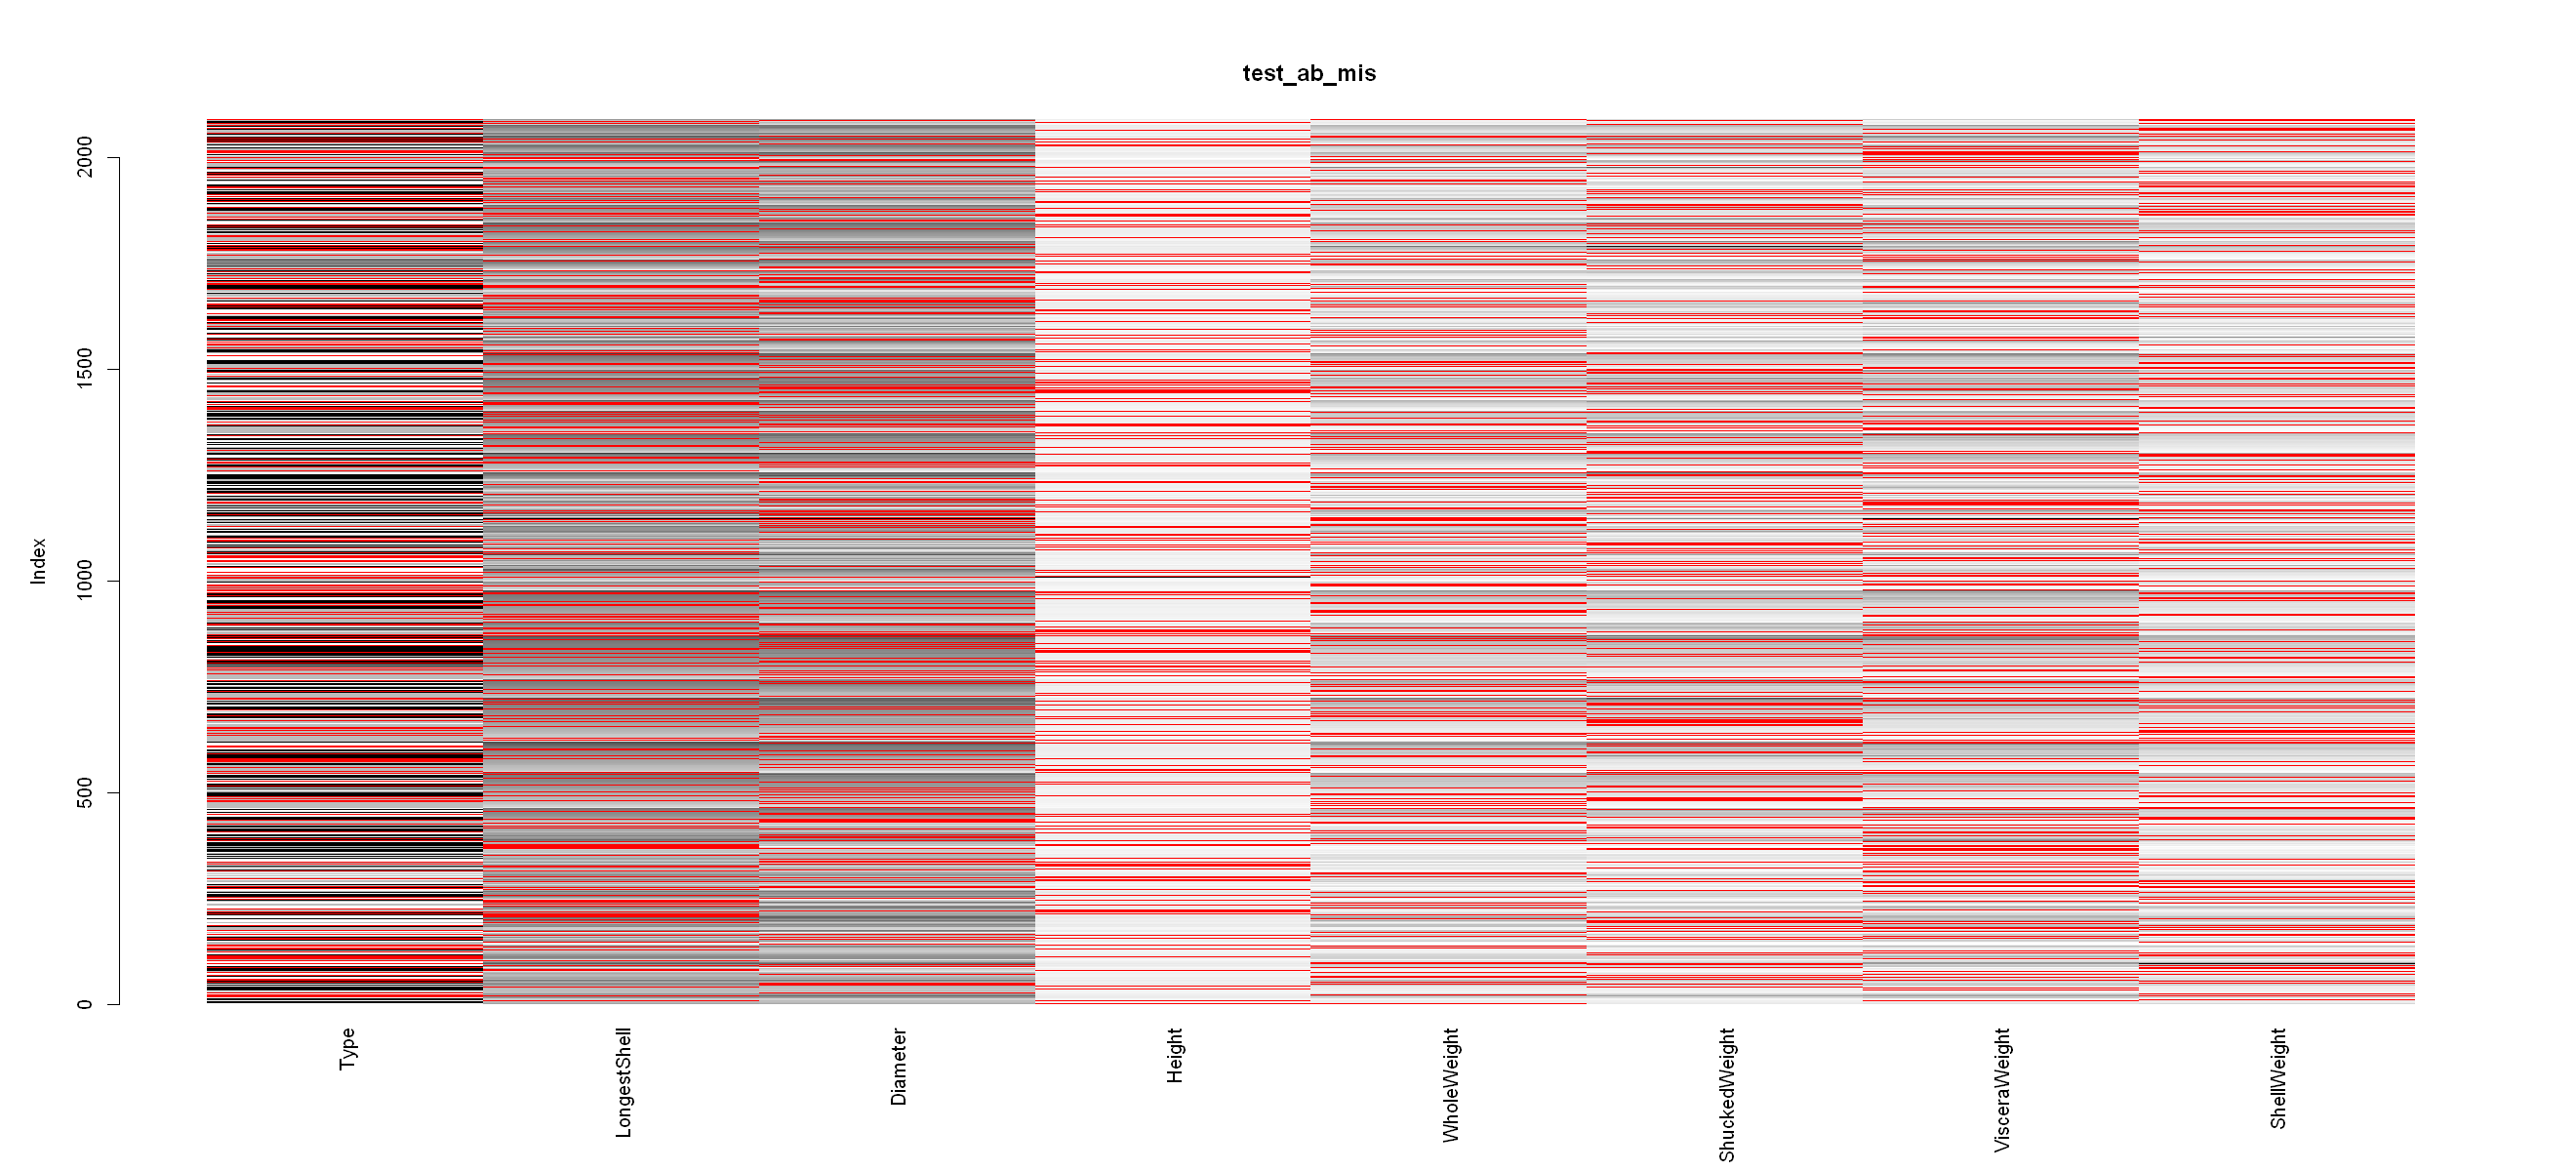

In [19]:
set.seed(100)
I <- sample(nrow(ab), nrow(ab) * 0.5) # 将数据集1:1随机分割成训练集和测试集
test_ab <- ab[-I, ]

ab_mis <- prodNA(ab, 0.2)   #各变量均缺失10%
ab_mis[-I, 9] <- NA         #测试集的目标变量值置为缺失
train_ab_mis <- ab_mis[I,]  #训练集
test_ab_mis <- ab_mis[-I, -9] #测试集  

par(oma = c(2,1,1,1))
matrixplot(train_ab_mis, main = "train_ab_mis")    
matrixplot(test_ab_mis, main = "test_ab_mis") 

In [20]:
#用填补前的训练集得到决策树预测填补前的测试集
set.seed(2)    #固定xstd：xerror具有随机性--数据随机分割的原因
ct_ab_mis <- rpart(Rings ~ ., data = train_ab_mis, method = "class", cp = 0)  
cto_ab_mis <- prune_se(ct_ab_mis, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis, test_ab_mis, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2388703

In [21]:
#随机森林算法填补训练集和测试集
train_ab_mis_r <- missRanger(train_ab_mis, seed = 10, verbose = 0)
test_ab_mis_r <- missRanger(test_ab_mis, seed = 10, verbose = 0)

#matrixplot(train_ab_mis_r, main = "train_ab_mis")    
#matrixplot(test_ab_mis_r, main = "test_ab_mis") 

#用填补后的训练集得到决策树预测填补后的测试集
set.seed(2)
ct_ab_mis_r <- rpart(Rings ~ ., data = train_ab_mis_r, method = "class", cp = 0)  
cto_ab_mis_r <- prune_se(ct_ab_mis_r, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis_r, test_ab_mis_r, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.224988

### 缺失30%

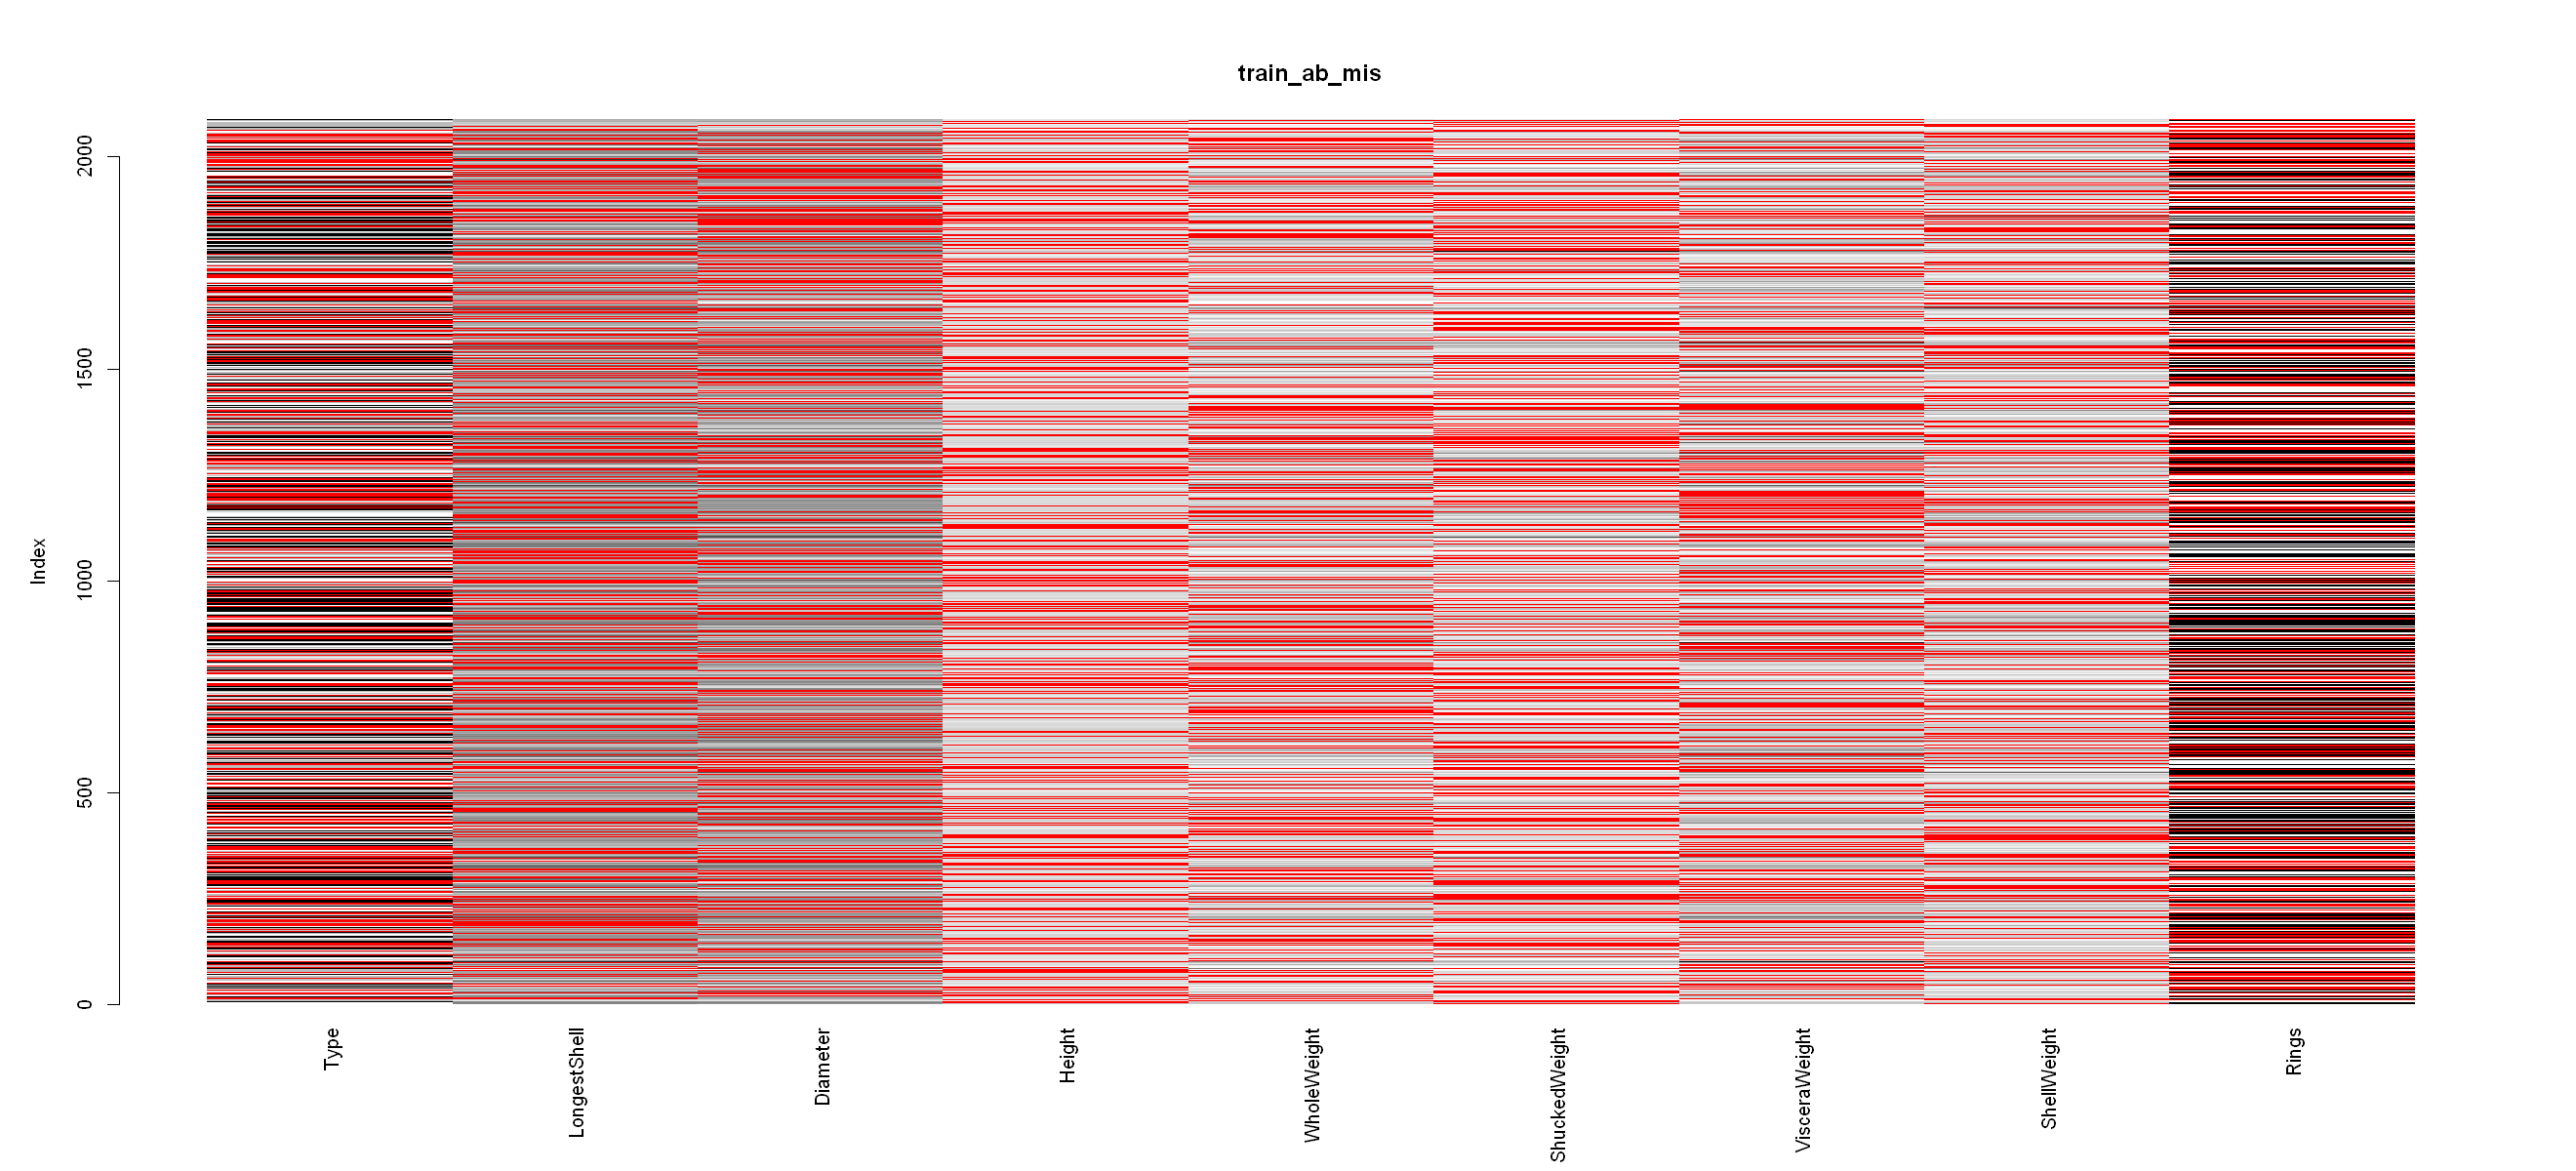

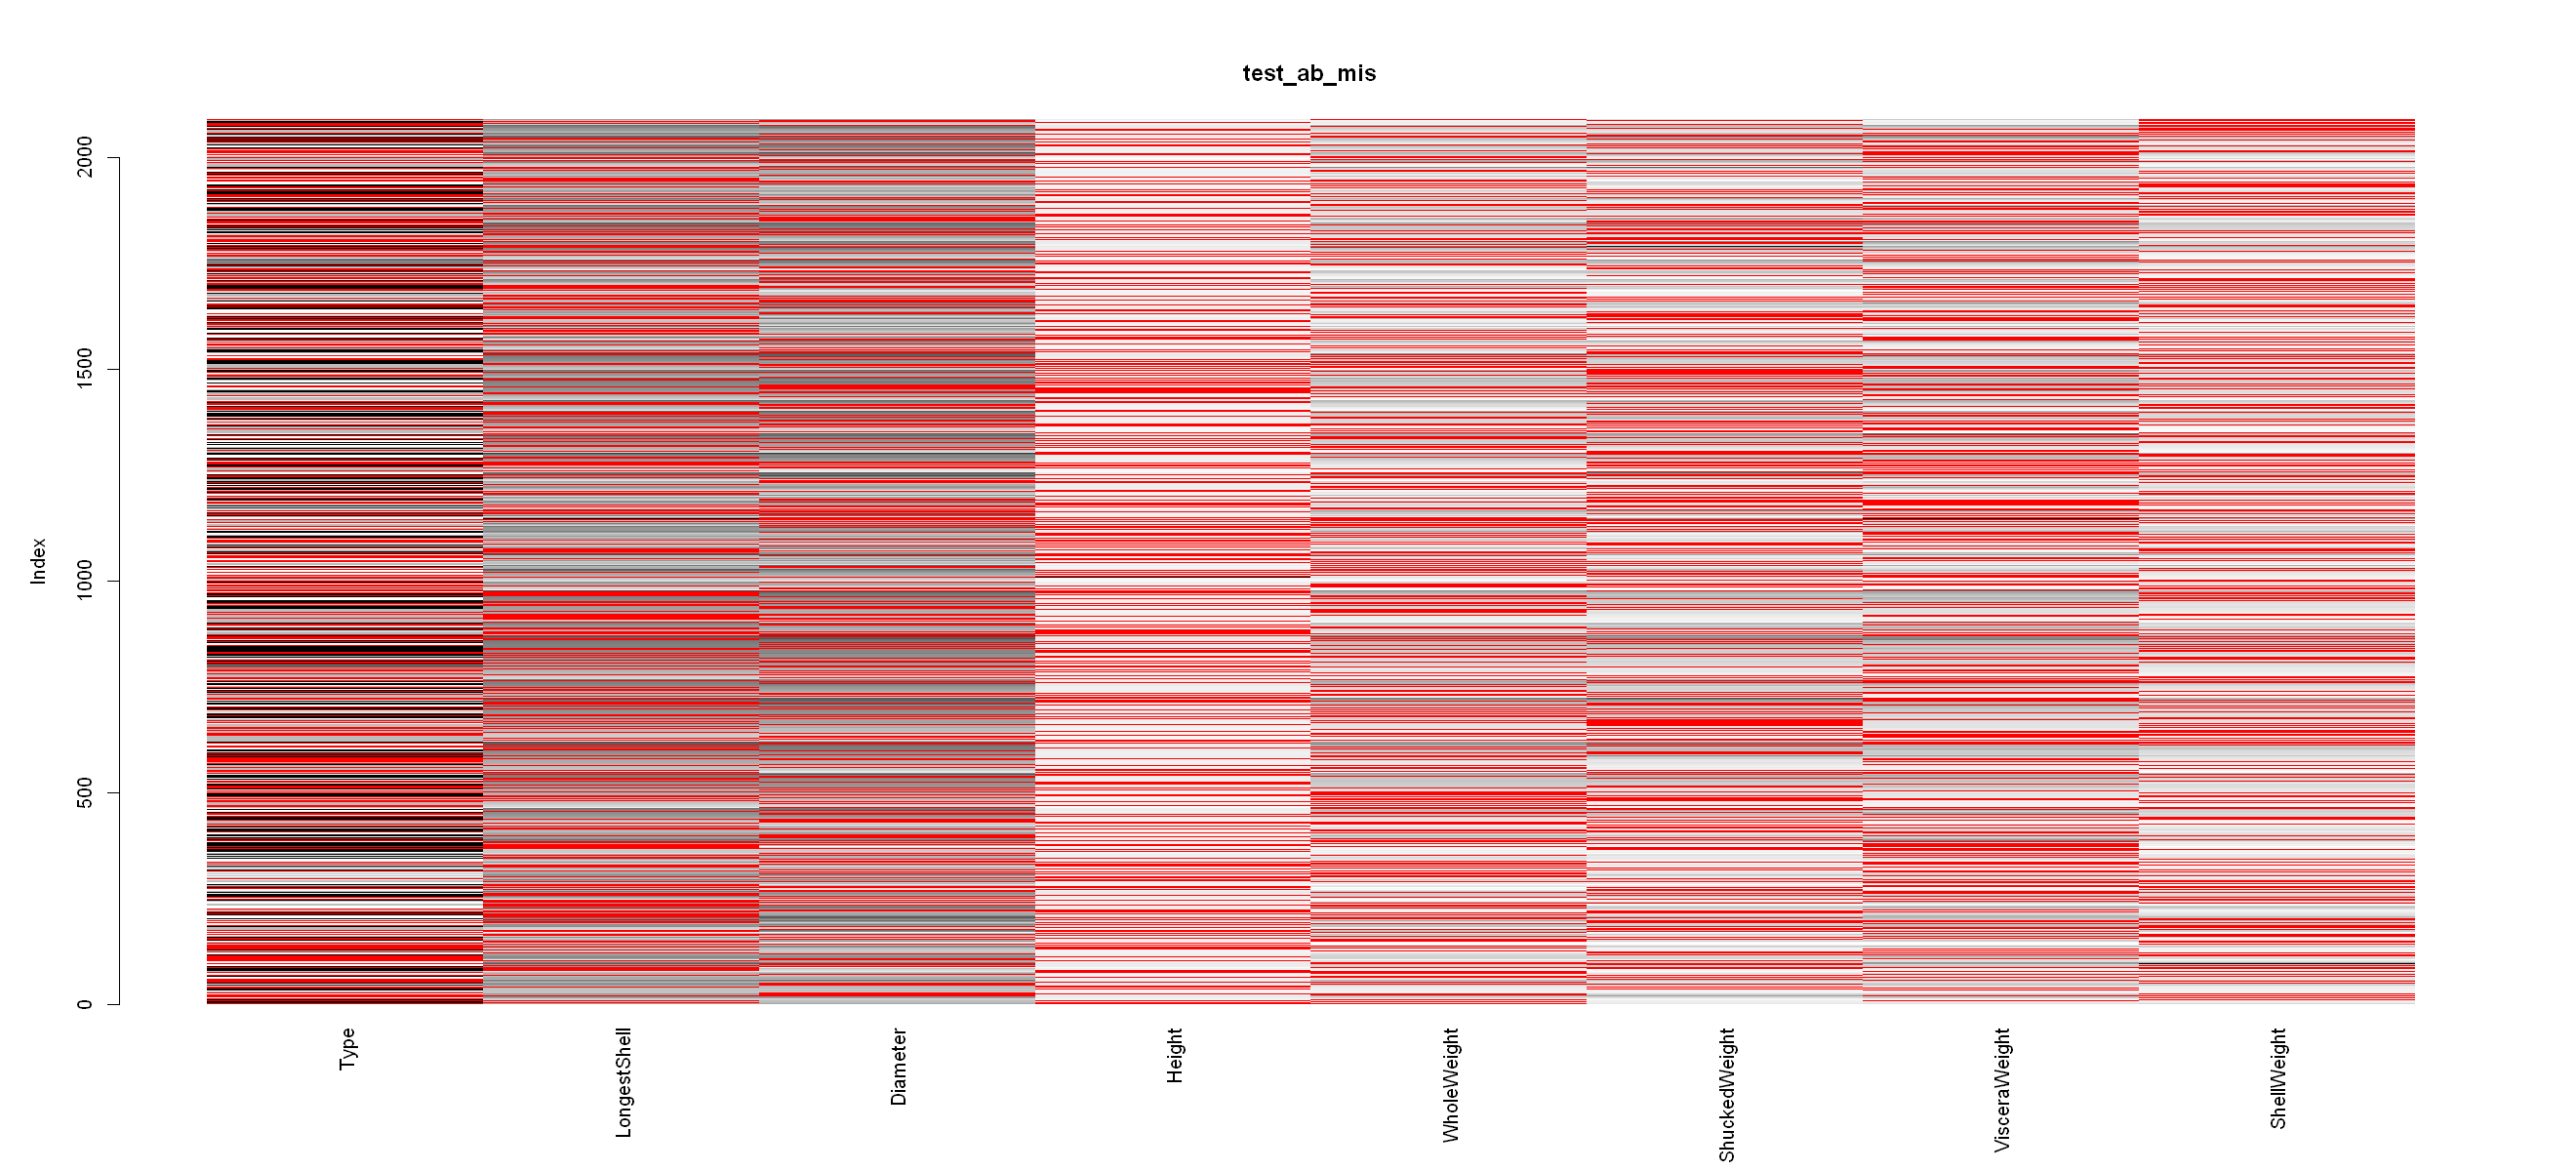

In [23]:
set.seed(100)
I <- sample(nrow(ab), nrow(ab) * 0.5) # 将数据集1:1随机分割成训练集和测试集
test_ab <- ab[-I, ]

ab_mis <- prodNA(ab, 0.3)   #各变量均缺失10%
ab_mis[-I, 9] <- NA         #测试集的目标变量值置为缺失
train_ab_mis <- ab_mis[I,]  #训练集
test_ab_mis <- ab_mis[-I, -9] #测试集  

par(oma = c(2,1,1,1))
matrixplot(train_ab_mis, main = "train_ab_mis")    
matrixplot(test_ab_mis, main = "test_ab_mis") 

In [24]:
#用填补前的训练集得到决策树预测填补前的测试集
set.seed(2)    #固定xstd：xerror具有随机性--数据随机分割的原因
ct_ab_mis <- rpart(Rings ~ ., data = train_ab_mis, method = "class", cp = 0)  
cto_ab_mis <- prune_se(ct_ab_mis, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis, test_ab_mis, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2436573

In [25]:
#随机森林算法填补训练集和测试集
train_ab_mis_r <- missRanger(train_ab_mis, seed = 10, verbose = 0)
test_ab_mis_r <- missRanger(test_ab_mis, seed = 10, verbose = 0)

#matrixplot(train_ab_mis_r, main = "train_ab_mis")    
#matrixplot(test_ab_mis_r, main = "test_ab_mis") 

#用填补后的训练集得到决策树预测填补后的测试集
set.seed(2)
ct_ab_mis_r <- rpart(Rings ~ ., data = train_ab_mis_r, method = "class", cp = 0)  
cto_ab_mis_r <- prune_se(ct_ab_mis_r, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis_r, test_ab_mis_r, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2359981

### 缺失40%

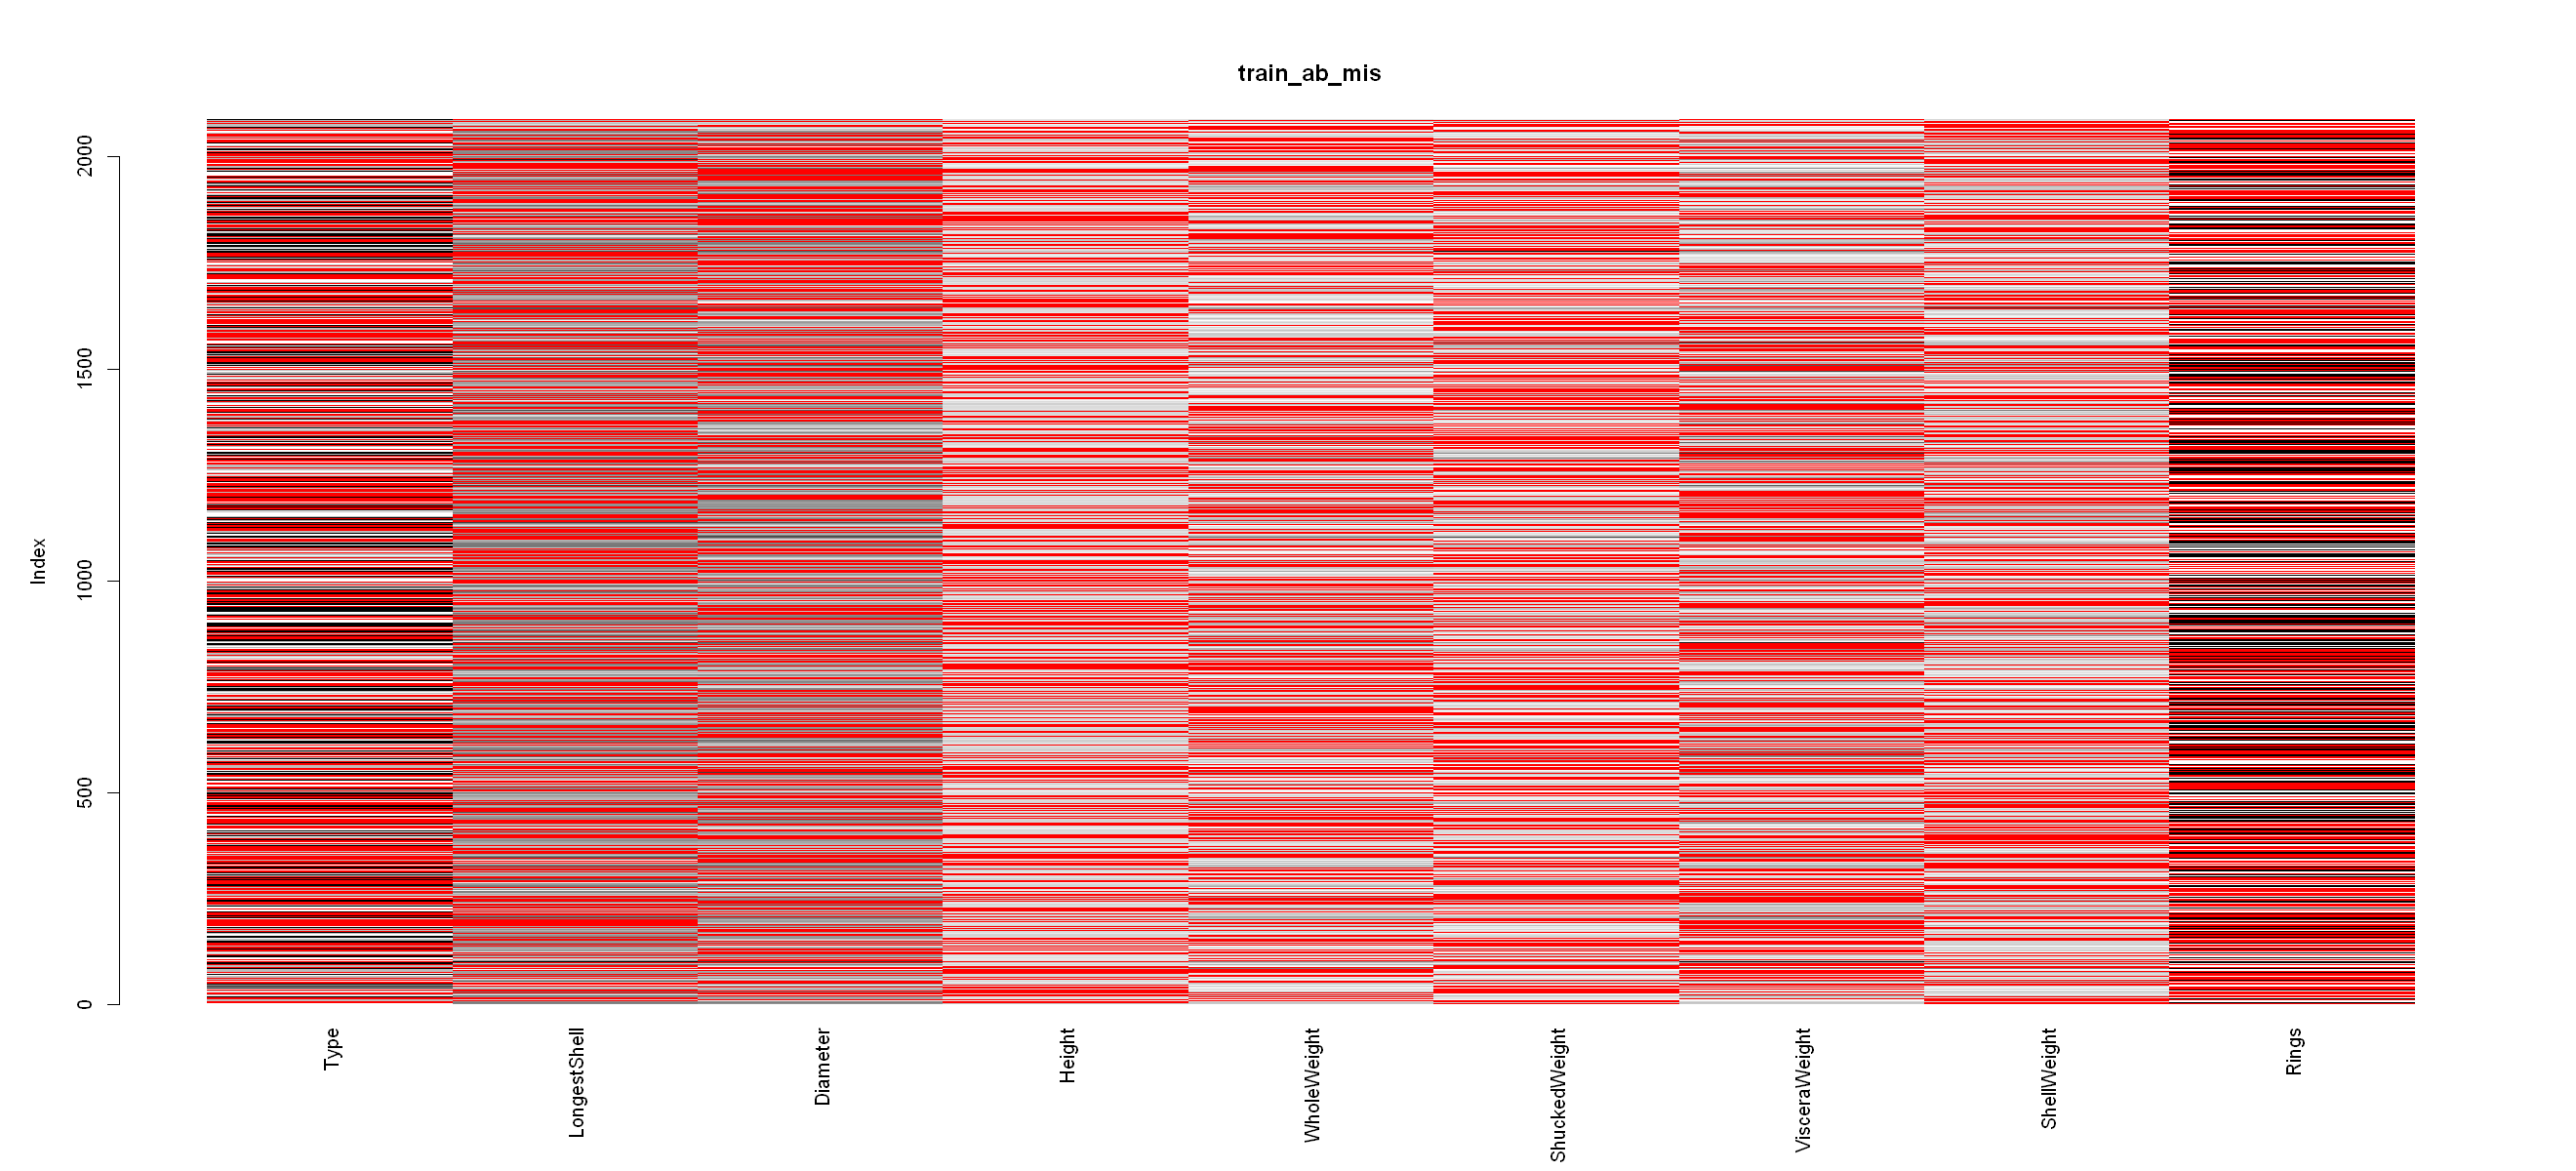

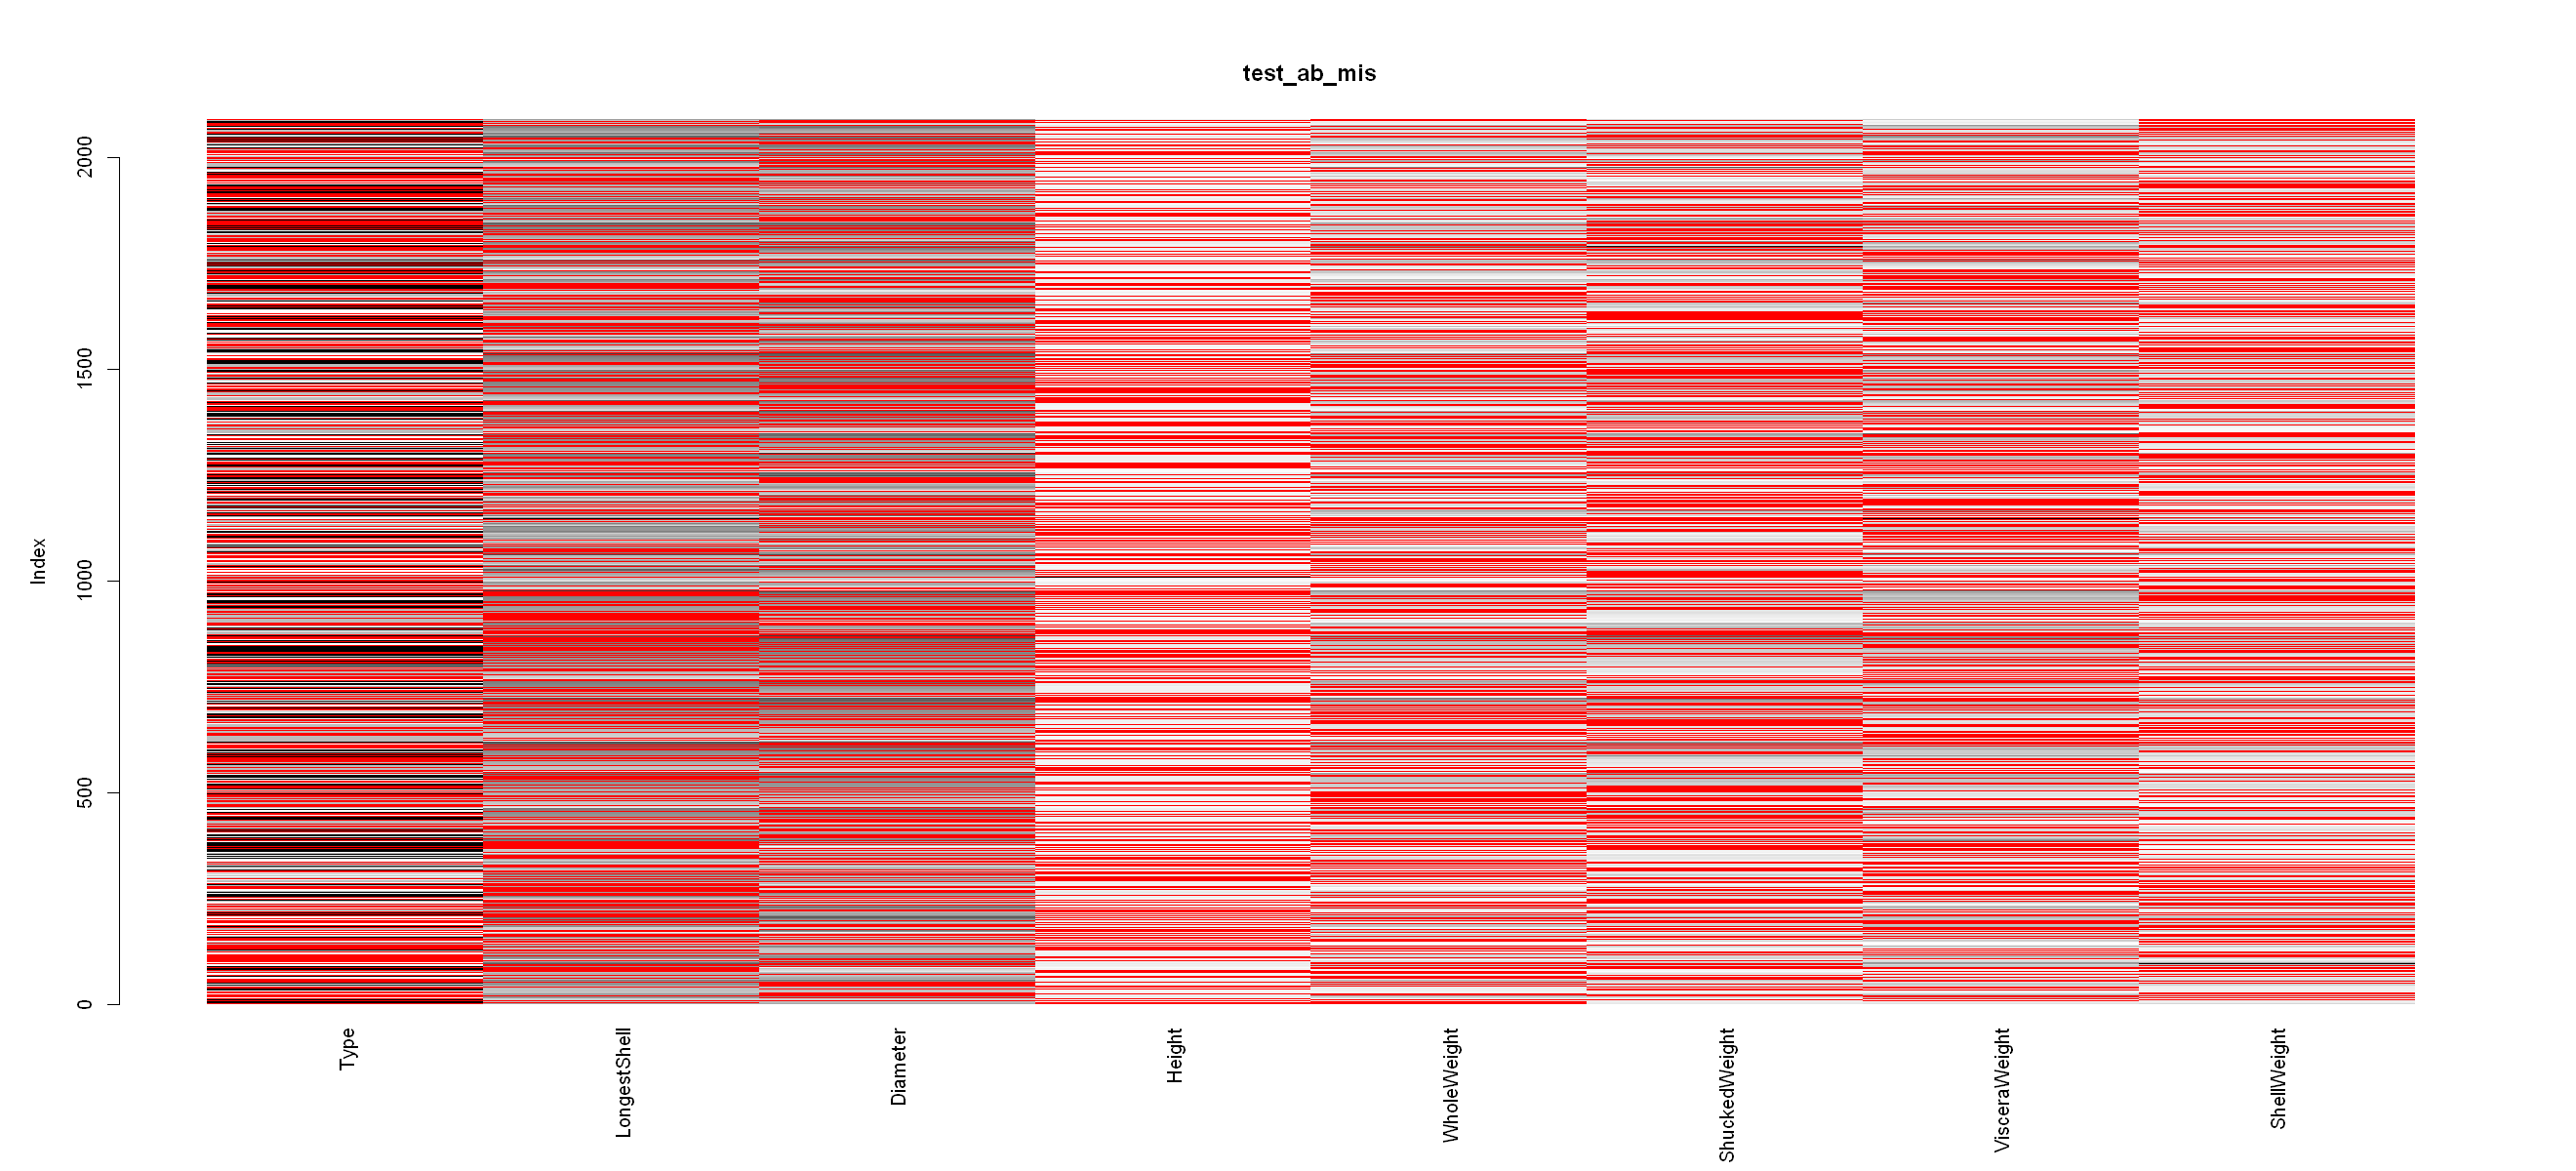

In [26]:
set.seed(100)
I <- sample(nrow(ab), nrow(ab) * 0.5) # 将数据集1:1随机分割成训练集和测试集
test_ab <- ab[-I, ]

ab_mis <- prodNA(ab, 0.4)   #各变量均缺失10%
ab_mis[-I, 9] <- NA         #测试集的目标变量值置为缺失
train_ab_mis <- ab_mis[I,]  #训练集
test_ab_mis <- ab_mis[-I, -9] #测试集  

par(oma = c(2,1,1,1))
matrixplot(train_ab_mis, main = "train_ab_mis")    
matrixplot(test_ab_mis, main = "test_ab_mis") 

In [27]:
#用填补前的训练集得到决策树预测填补前的测试集
set.seed(2)    #固定xstd：xerror具有随机性--数据随机分割的原因
ct_ab_mis <- rpart(Rings ~ ., data = train_ab_mis, method = "class", cp = 0)  
cto_ab_mis <- prune_se(ct_ab_mis, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis, test_ab_mis, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2680708

In [28]:
#随机森林算法填补训练集和测试集
train_ab_mis_r <- missRanger(train_ab_mis, seed = 10, verbose = 0)
test_ab_mis_r <- missRanger(test_ab_mis, seed = 10, verbose = 0)

#matrixplot(train_ab_mis_r, main = "train_ab_mis")    
#matrixplot(test_ab_mis_r, main = "test_ab_mis") 

#用填补后的训练集得到决策树预测填补后的测试集
set.seed(2)
ct_ab_mis_r <- rpart(Rings ~ ., data = train_ab_mis_r, method = "class", cp = 0)  
cto_ab_mis_r <- prune_se(ct_ab_mis_r, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis_r, test_ab_mis_r, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2398277

### 缺失50%

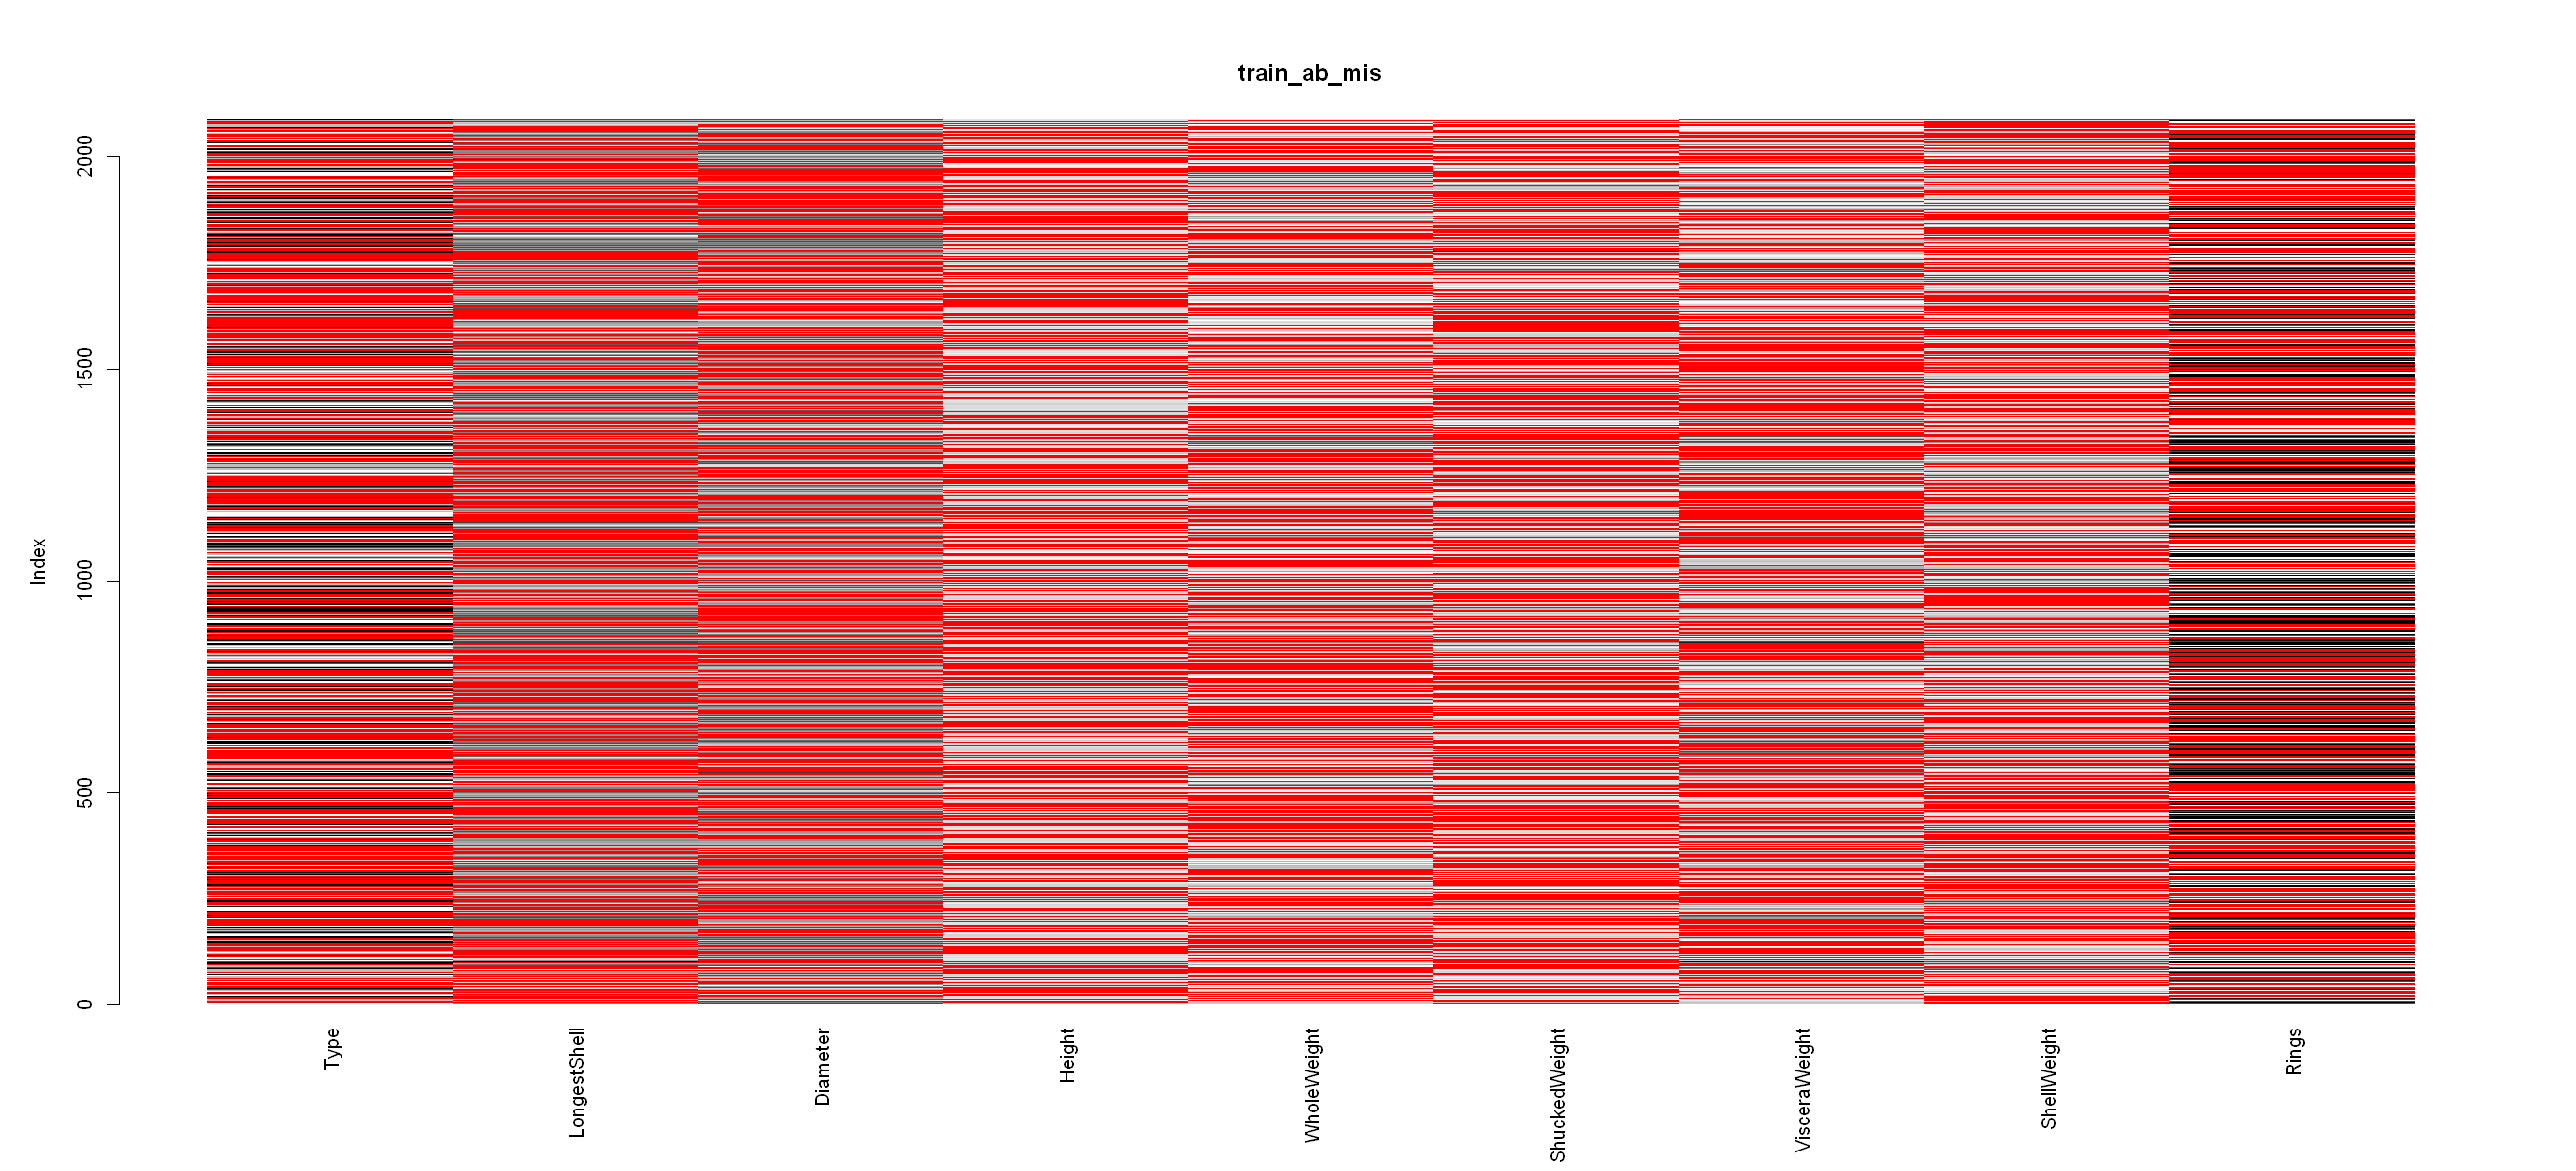

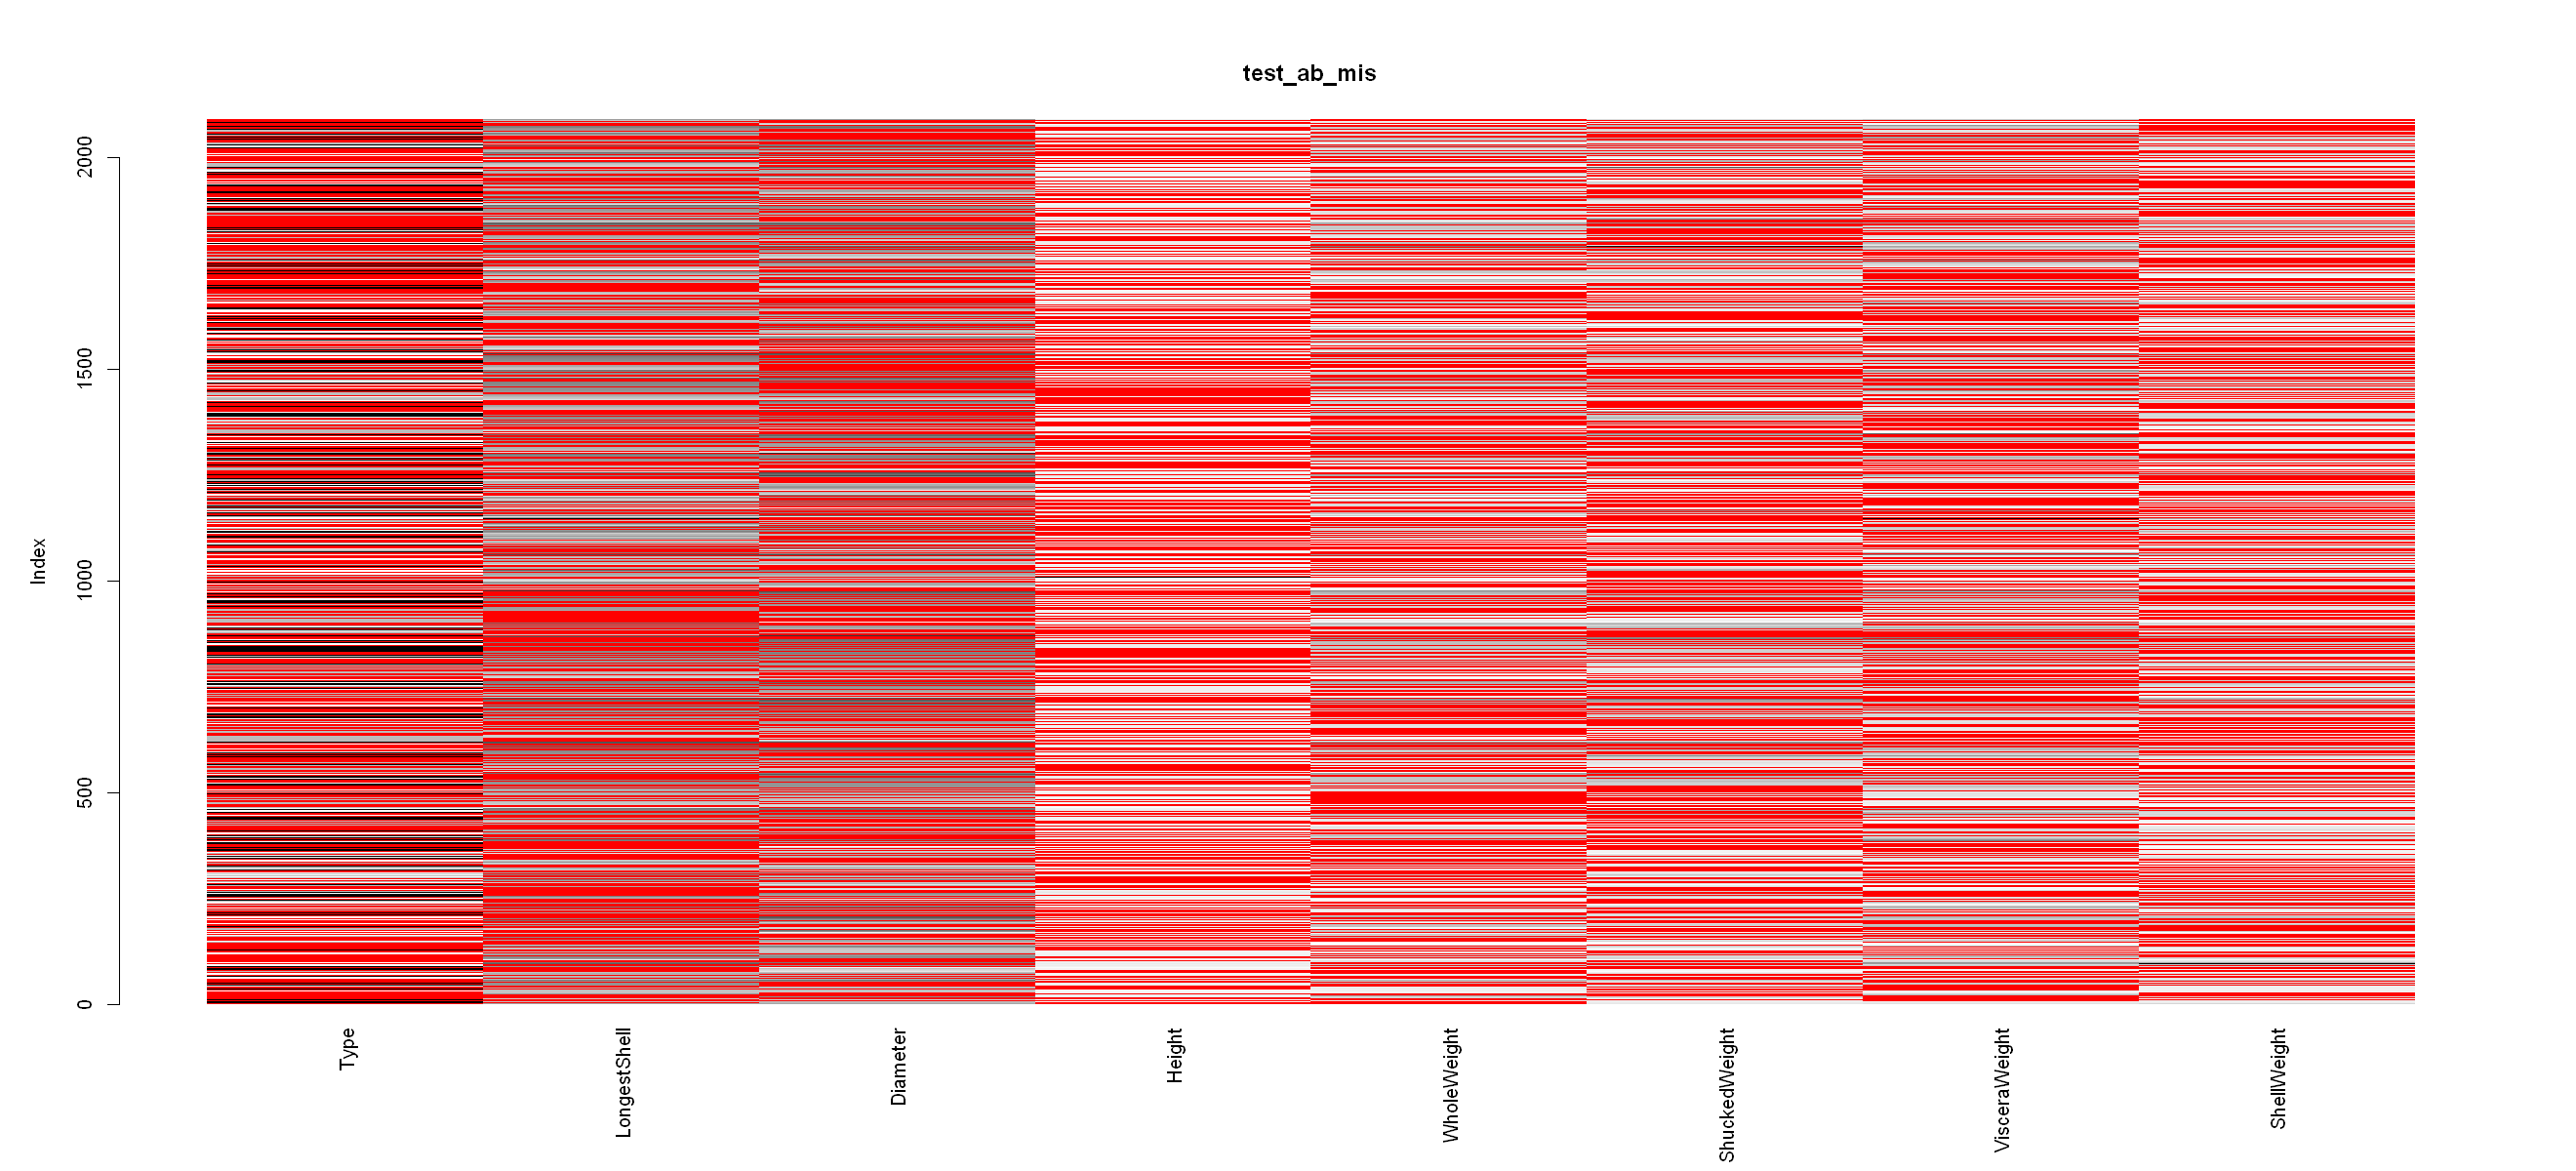

In [30]:
set.seed(100)
I <- sample(nrow(ab), nrow(ab) * 0.5) # 将数据集1:1随机分割成训练集和测试集
test_ab <- ab[-I, ]

ab_mis <- prodNA(ab, 0.5)   #各变量均缺失10%
ab_mis[-I, 9] <- NA         #测试集的目标变量值置为缺失
train_ab_mis <- ab_mis[I,]  #训练集
test_ab_mis <- ab_mis[-I, -9] #测试集  

par(oma = c(2,1,1,1))
matrixplot(train_ab_mis, main = "train_ab_mis")    
matrixplot(test_ab_mis, main = "test_ab_mis") 

In [31]:
#用填补前的训练集得到决策树预测填补前的测试集
set.seed(2)    #固定xstd：xerror具有随机性--数据随机分割的原因
ct_ab_mis <- rpart(Rings ~ ., data = train_ab_mis, method = "class", cp = 0)  
cto_ab_mis <- prune_se(ct_ab_mis, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis, test_ab_mis, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2876975

In [32]:
#随机森林算法填补训练集和测试集
train_ab_mis_r <- missRanger(train_ab_mis, seed = 10, verbose = 0)
test_ab_mis_r <- missRanger(test_ab_mis, seed = 10, verbose = 0)

#matrixplot(train_ab_mis_r, main = "train_ab_mis")    
#matrixplot(test_ab_mis_r, main = "test_ab_mis") 

#用填补后的训练集得到决策树预测填补后的测试集
set.seed(2)
ct_ab_mis_r <- rpart(Rings ~ ., data = train_ab_mis_r, method = "class", cp = 0)  
cto_ab_mis_r <- prune_se(ct_ab_mis_r, prune = TRUE, se = 1)   #1-SE最优树
(mean(predict(cto_ab_mis_r, test_ab_mis_r, type = "class")  != test_ab$Rings))    #测试集的错判率

[1] 0.2608904

可见训练集和测试集的填补均有利于错判率的降低